In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import t
from matplotlib.ticker import MultipleLocator
from scipy.stats import t as t_dist


# Functions

In [2]:
# Funzione gaussiana
def gaussian_offset(x, A, mu, sigma, m, q):
    return A*(1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2)) + m *x +q


In [3]:
def chi_square_func(exp, theo, err, popt):
    dof = len(exp)-len(popt)
    chi = np.sum(((exp-theo)/ err)**2 )
    chi_red = chi/dof
    return chi, chi_red

In [33]:
def fit_func(spectrum, center, dx=15, kev=False, energies=None, plot = True, ax=None):
    center = int(round(center))  # <-- Add this
    if kev:
        
        mask = (energies > center - dx) & (energies < center + dx)
        x_data = energies[mask]
        y_data = spectrum[mask]
    else:
        window = dx       
        x_data = np.arange(center - window, center + window + 1)
        y_data = spectrum[center - window:center + window + 1]


    y_data = [y + 1 if y == 0 else y for y in y_data]

    

    dof = len(x_data) -5

    err_counts = [np.sqrt(c) if c > 0 else 1 for c in y_data]
    for i in range(len(err_counts)):
        if err_counts[i]==0:
            print(i)

    initial_guess = [max(y_data), center, 1, 0, 10]
    bounds = (
        [0, center - 5, 0.0001, -10000, 1],
        [100000* max(y_data), center + 5, 10, 1000000, max(y_data)]
    )

    popt, pcov = curve_fit(gaussian_offset, x_data, y_data, sigma=err_counts, p0=initial_guess, bounds=bounds)
    err = np.sqrt(np.diag(pcov))

    if ax is None:
        ax = plt.gca()

    bins = np.linspace(min(x_data), max(x_data), len(x_data)+1)

    if plot:
        
        counts, bin_edges, _ = ax.hist(x_data, bins=bins, weights=y_data,
                                      histtype='step', color = 'black', label='Hist data')
        '''ax.errorbar(x_data, y_data, yerr = err_counts, 
                    markersize = 5,
                    capsize=5,
                    alpha = 0.86,
                    fmt = 'o',
                    color='dimgray',
                   label = 'Data')'''
        
        db = bin_edges[1]-bin_edges[0]
        
        xfit = np.linspace(x_data[0], x_data[-1]+1, 500)
        yfit = gaussian_offset(xfit, *popt)
        ax.plot(xfit, yfit, color='deepskyblue', lw=2, label='Gaussian fit')
        ax.set_xlim(min(x_data), max(x_data))
        if kev:
            dx = 2
            dy = 1
            ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
            ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
            ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
            ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

            ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f} keV')
            ax.set_xlabel('E [keV]', size = 12)
            ax.set_title(f'Gaussian fit @ {center} keV', size = 15)
            ax.set_ylabel(f'Counts / {db:.1f} keV', size = 12)
        else:

            dx = 10
            dy = 1
            ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
            ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
            ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
            ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

            
            ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--', label=f'Peak: {popt[1]:.2f}')
            ax.set_xlabel('Channel', size = 12)
            ax.set_title(f'Gaussian fit @ {center} chn', size = 15)
            ax.set_ylabel(f'Counts / {db:.0f} chn', size = 12)
        ax.grid(alpha=0.25)
        ax.legend(loc = 'upper left')

    chi, chi_red = chi_square_func(x_data, gaussian_offset(x_data, *popt), err_counts, popt)
     
 #   print(r"$\chi^2$", chi)
 #   print(r'$\chi^2$/ dof', chi_red)
    

    return popt, err, dof




In [5]:
def k_calibration(E_chn, a, b):
    return E_chn * a + b

In [6]:
def t_test_theoretical(x_exp, sigma, x_theo, dof):
    t_stat = (x_exp - x_theo) / sigma
    print(f't = {t_stat:.2f}')
    
    # p-value a due code
    p_value = 2 * t_dist.sf(abs(t_stat), df=dof)

    if p_value < 0.05:
        print('❌ p < 0.05 ')
    else:
        print('✅ p > 0.05 ')
    print(f'p-value = {p_value:.4f}')
    return t_stat, p_value

In [7]:
def fhwm_func(E, a, b):
    return np.sqrt( (a / np.sqrt(E))**2 + b**2)


In [8]:
import numpy as np

def fwhm_percentuale(sigma, delta_sigma, E, delta_E):

    sigma = np.array(sigma)
    delta_sigma = np.array(delta_sigma)
    E = np.array(E)
    delta_E = np.array(delta_E)

    # Calcolo FWHM percentuale: (2.355 * sigma) / E 
    fwhm_perc = (2.355 * sigma / E) 

    # Propagazione dell'errore relativa
    rel_err_sigma = delta_sigma / sigma
    rel_err_E = delta_E / E
    delta_fwhm_perc = fwhm_perc * np.sqrt(rel_err_sigma**2 + rel_err_E**2)

    return fwhm_perc, delta_fwhm_perc


In [9]:
def fit_func_sottratto(spectrum, background, center, dx=50, kev=False, energies=None, ax=None):
    if kev:
        if energies is None:
            raise ValueError("Devi fornire 'energies' se kev=True")
        mask = (energies > center - dx) & (energies < center + dx + 1)
        x_data = energies[mask]
        y_data = spectrum[mask]
        y_bkg = background[mask]
    else:
        window = dx
        x_data = np.arange(center - window, center + window + 1)
        y_data = spectrum[center - window:center + window + 1]
        y_bkg = background[center - window:center + window + 1]

    y_sub = y_data - y_bkg
    if center == 1661.28:
        y_sub[y_sub <= 0] = 300
    else:
        y_sub[y_sub < 0] = 0
    
    err_counts = [np.sqrt(d + b) if (d + b) > 0 else 1 for d, b in zip(y_data, y_bkg)]

    valid_mask = y_sub > 0
    x_data = x_data[valid_mask]
    y_sub = y_sub[valid_mask]
    y_sub = [y + 250000 if y == 0 else y for y in y_sub]
    err_counts = np.array(err_counts)[valid_mask]
    dof = len(x_data) -5

    initial_guess = [max(y_sub), center, 5, 0, 1100]
    bounds = (
        [0, center - 1, 0.01, -1000, 0],
        [1000 * max(y_sub), center + 1, 25, 1000, np.inf]
    )

    popt, pcov = curve_fit(gaussian_offset, x_data, y_sub, sigma=err_counts, p0=initial_guess, bounds=bounds)
    err = np.sqrt(np.diag(pcov))

    if ax is None:
        ax = plt.gca()
    bins = np.linspace(min(x_data), max(x_data), len(x_data)+1)
    counts, bin_edges, _ = ax.hist(x_data, bins=bins, weights=y_sub,
                                   histtype='step', color='black', label='Hist data')
    '''
    ax.errorbar(x_data, y_sub, yerr=err_counts,
                markersize=5,
                capsize=5,
                alpha=0.86,
                fmt='o',
                color='dimgray',
                label='Data')
    '''
    xfit = np.linspace(min(x_data), max(x_data), 500)
    yfit = gaussian_offset(xfit, *popt)
    ax.plot(xfit, yfit, color='deepskyblue', lw=2, label='Gaussian fit')
    ax.set_xlim(min(x_data), max(x_data))

    ax.vlines(popt[1], 0, max(gaussian_offset(x_data, *popt)), color='deepskyblue', lw=2, linestyle='--',
              label=f'Peak: {popt[1]:.2f} {"keV" if kev else ""}')

    # Label e titolo coerenti con fit_func
    if kev:
        ax.set_xlabel('E [keV]', size=12)
        ax.set_title(f'Gaussian fit @ {center} keV', size=15)
    else:
        ax.set_xlabel('Channel', size=12)
        ax.set_title(f'Gaussian fit @ {center} chn', size=15)

    ax.set_ylabel('Counts', size=12)
    ax.grid(alpha=0.25)
    ax.legend()

    return popt, err, dof


In [10]:
def get_eff_value(energia, x_eff, eff_value):
    idx = np.abs(x_eff - energia).argmin()
    return eff_value[idx]

# Background

In [13]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto
D_b = (t_real_b/t_live_b)


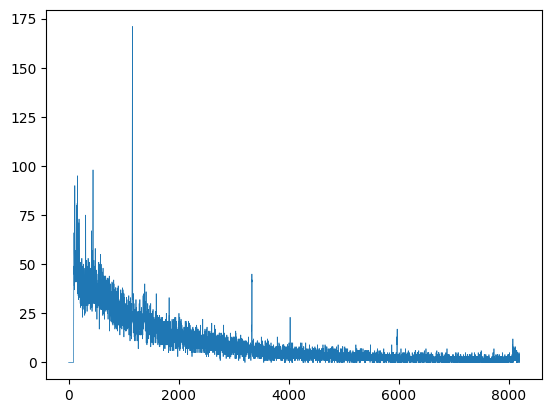

In [15]:
plt.plot(spectrum_bkg, lw=0.5, label='Spectrum')

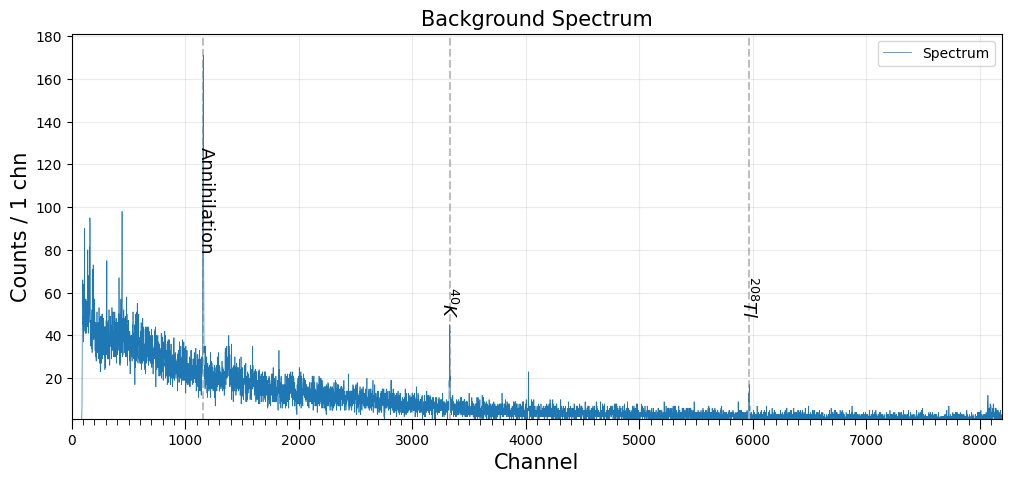

In [27]:
plt.figure(figsize=(12, 5))

# === IMPOSTA TICKS X PRIMA DEL PLOT ===
dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero


chn = np.arange(len(spectrum_bkg))  # canali da 0 a N-1
#plt.bar(chn, spectrum_bkg, width=1.0, label='Spectrum')
#plt.plot(spectrum_bkg, lw = 0.5, label='Spectrum')
#bins = np.linspace(min(chn), max(chn), len(chn)+1)
#counts, bin_edges, _ = plt.hist(chn, bins=bins, weights=spectrum_bkg,
                                      #histtype='step', label='Hist data')
plt.plot(chn, spectrum_bkg, lw=0.5, label='Spectrum')
db = chn[1]-chn[0]
plt.xlabel('Channel', size = 15)
plt.ylabel(f'Counts / {db:.0f} chn', size = 15)
plt.title('Background Spectrum', size = 15)
plt.text(1100,  80, "Annihilation", rotation=270,  size = 13)
plt.text(3229 , 0.5e2, r'$^{40}K$', rotation=270,  size = 13)
plt.text(5865 , 50, r'$^{208}Tl$', rotation=270,  size = 13)
plt.vlines(1157,  0, max(spectrum_bkg)+10 , color = 'grey', alpha = 0.5, ls = '--')
plt.vlines(3329,  0, max(spectrum_bkg) + 10, color = 'grey', alpha = 0.5, ls = '--')
plt.vlines(5965,  0, max(spectrum_bkg) +10 , color = 'grey', alpha = 0.5, ls = '--')
plt.xlim(0, len(spectrum_bkg))
plt.ylim(1,max(spectrum_bkg)+10)
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new image/ HPGe background", dpi=300, bbox_inches='tight')

In [764]:
65/4

16.25

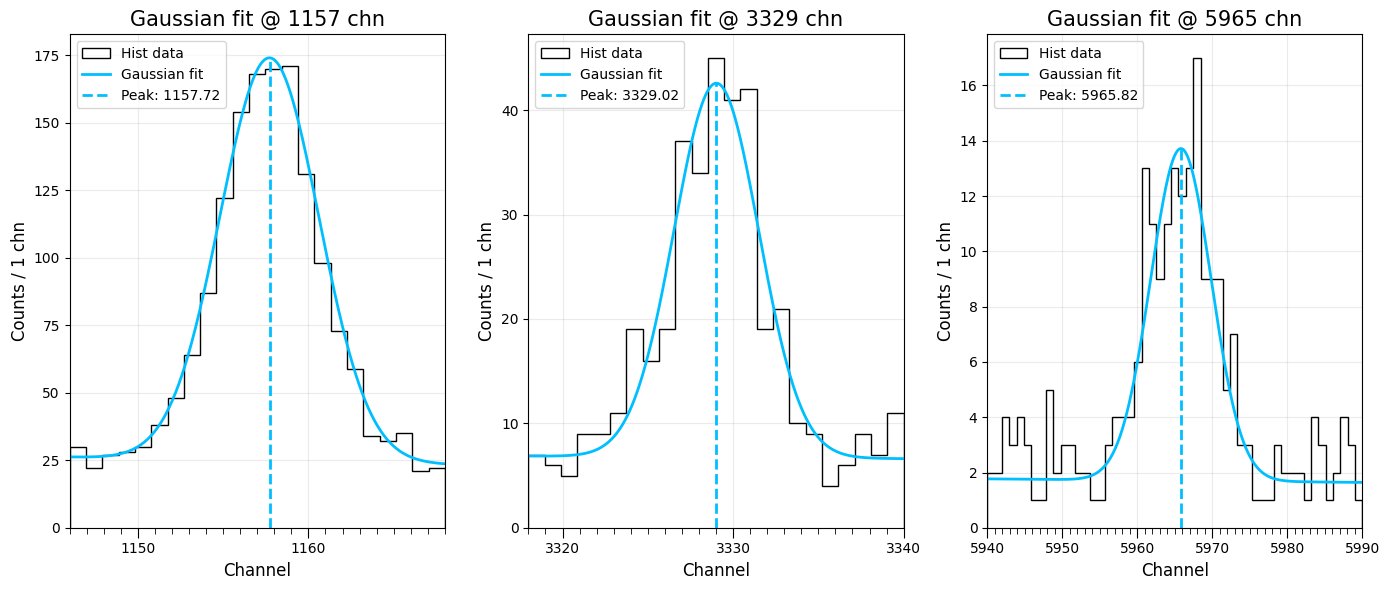

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  # 1 riga, 3 colonne

E_chn = [1157, 3329, 5965] 
popt_chn = []
popt_chn_err = []

for i, e in enumerate(E_chn):
    dx = 25 if e == E_chn[-1] else 11
    popt, err, _ = fit_func(spectrum_bkg, e, dx=dx, ax=axes[i])
    popt_chn.append(popt)
    popt_chn_err.append(err)

popt_chn = np.vstack(popt_chn)

popt_chn_err = np.vstack(popt_chn_err)
plt.savefig("new image/ chn_bkg_peaks", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [36]:
popt_chn

array([[ 1.08581849e+03,  1.15771829e+03,  2.90176863e+00,
        -1.26334733e-01,  1.71000000e+02],
       [ 2.22953291e+02,  3.32902157e+03,  2.48296127e+00,
        -1.14899491e-02,  4.50000000e+01],
       [ 1.21511255e+02,  5.96582233e+03,  4.03546054e+00,
        -2.56363951e-03,  1.70000000e+01]])

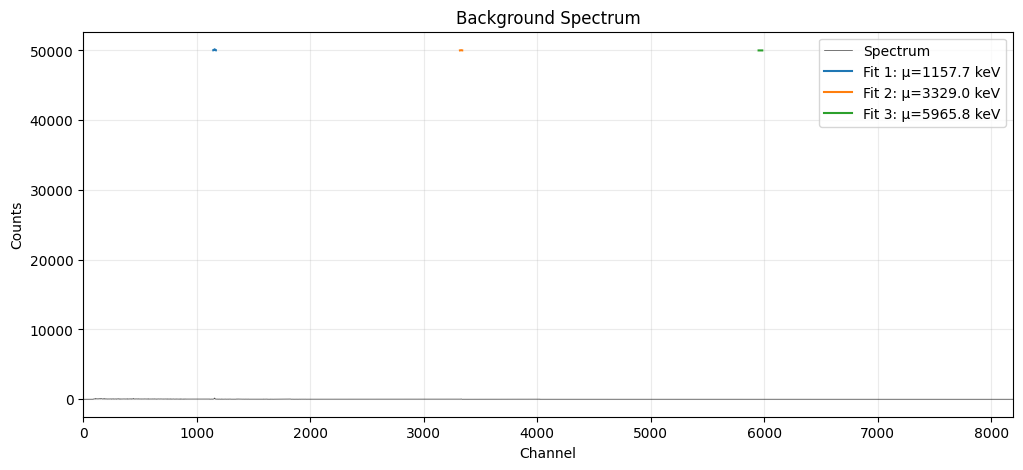

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(spectrum_bkg, color = 'black', lw = 0.46, alpha = 0.8, label='Spectrum')
for i, popt in enumerate(popt_chn):
    A, mu, sigma, m, q = popt
    x_fit = np.linspace(mu - 4*sigma, mu + 4*sigma, 300)
    y_fit = gaussian_offset(x_fit, A, mu, sigma,m, q+50000)
    plt.plot(x_fit, y_fit,  label=f'Fit {i+1}: μ={mu:.1f} keV')


plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Background Spectrum')
plt.xlim(0, len(spectrum_bkg))
#plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.show()

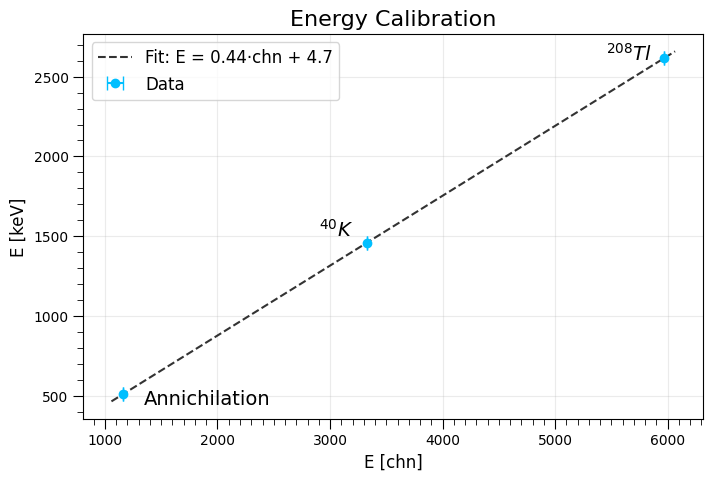

In [38]:
E_kev = [511, 1460.830, 2614] #kev

plt.figure(figsize=(8, 5))


dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

dx = 500
dy = 100
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.yaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='y', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='y', which='minor', length=4, labelsize=0)   # tacche piccole, no numero



plt.errorbar( popt_chn[:,1],E_kev, xerr=popt_chn_err[:,1], fmt='o', color = 'deepskyblue', capsize=5, label='Data')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, popt_chn[:,1], E_kev, p0=p0 )
# Incertezze
perr = np.sqrt(np.diag(pcov))
a_bkg = popt[0]
b_bkg = popt[1]

# Plot
x_fit = np.linspace(min(popt_chn[:,1])-100, max(popt_chn[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)
plt.text(1350 , 450, "Annichilation", rotation=0,  size = 14)
plt.text(2900 , 1500, r'$^{40}K$', rotation=0,  size = 14)
plt.text(5450 , 2600, r'$^{208}Tl$', rotation=0,  size = 14)
plt.legend(fontsize = 12)
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("new image/ E_cal_bkg", dpi=300, bbox_inches='tight')

In [39]:
##### print(a_bkg , '+/-', perr[0])
print(b_bkg , '+/-', perr[1])

4.679438014857306 +/- 0.12562759527503078


In [40]:
channels_bkg = np.arange(len(spectrum_bkg))         # x originale
energies_bkg = a_bkg * channels_bkg + b_bkg  
energies_bkg_err = np.sqrt(np.diag(pcov))[0]*channels_bkg + np.sqrt(np.diag(pcov))[1]

In [41]:
b_bkg

np.float64(4.679438014857306)

In [42]:
energies_bkg[1]-energies_bkg[0]

np.float64(0.43738478665371794)

In [48]:
mask = (energies_bkg > 60) & (energies_bkg < 3000)
spectr_3Mev = spectrum_bkg[mask]

print(np.sum(spectr_3Mev))
print(f'attività grezza {np.sum(spectr_3Mev)/(t_live_b):.0f} cps')

75423
attività grezza 1 cps


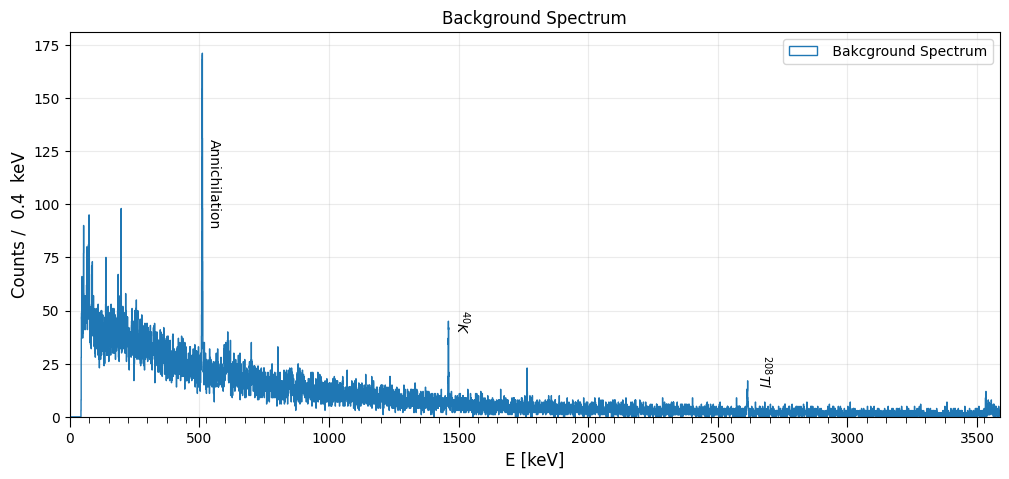

In [55]:
plt.figure(figsize=(12,5))

dx = 500
dy = 75
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




bins = np.linspace(min(energies_bkg), max(energies_bkg), len(energies_bkg))
counts, bin_edge, _ = plt.hist(energies_bkg, bins = bins, weights = spectrum_bkg, lw = 0.5,  histtype='step',label=' Bakcground Spectrum')
db = bin_edge[1]- bin_edge[0]
plt.xlabel('E [keV]', size = 12)
plt.ylabel(f'Counts / {db: .1f}  keV', size = 12)
plt.title('Background Spectrum')
plt.xlim(0, max(energies_bkg))
plt.ylim(0, max(spectrum_bkg)+10)
plt.text(530 , 0.9e2, "Annichilation", rotation=270,  size = 10)
plt.text(1480 , 40, r'$^{40}K$', rotation=270,  size = 10)
plt.text(2645 , 15, r'$^{208}Tl$', rotation=270,  size = 10)
plt.savefig("HPGe images/ spectrum_bkg_kev", dpi=300, bbox_inches='tight')
plt.legend(loc = 'upper right')
plt.grid(alpha = 0.25)
plt.savefig("new image/bkg_spectrum_kev", dpi=300, bbox_inches='tight')

In [56]:
for i in range(0,len(energies_bkg)):
    if spectrum_bkg[i] != 0:
        print(f' Energy threshold at {energies_bkg[i] + 15 : .2f} keV' )
        break

 Energy threshold at  58.61 keV


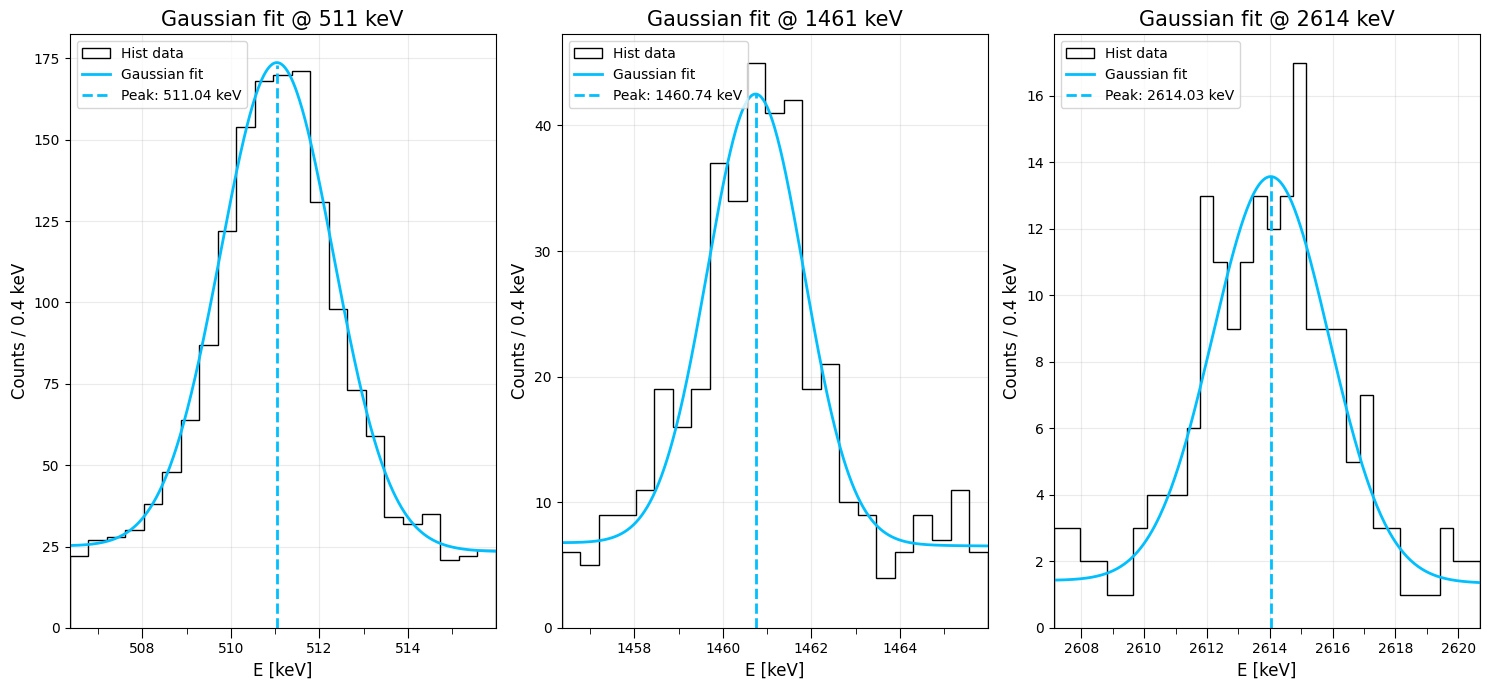

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))  # 1 riga, 3 colonne
E_kev = np.sort([ 511, 1460.83, 2614 ]) #kev
popt_kev = []
popt_kev_err = []
dofs = []
for i, e in enumerate(E_kev):
    if e == 2614:
        dx = 7
    else:
        dx = 5
    popt, err, dof = fit_func( spectrum_bkg, e, dx = dx, kev = True, energies = energies_bkg, ax=axes[i])
    popt_kev.append(popt)
    popt_kev_err.append(err)
    dofs.append(dof)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)
#dofs = np.vstack(dofs)

plt.tight_layout()
plt.savefig("new image/energy_peak_fit_bkg", dpi=300, bbox_inches='tight')
plt.show()


In [58]:
dofs 

[18, 18, 27]

In [59]:
for i in range(0, len(popt_kev[:,1])):
    mu_kev = popt_kev[:,1]
    mu_kev_err = popt_kev_err[:,1]
    mu_theo = E_kev[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo, dof = dofs[i])
    

t = 1.30
✅ p > 0.05 
p-value = 0.2084
t = -0.88
✅ p > 0.05 
p-value = 0.3928
t = 0.20
✅ p > 0.05 
p-value = 0.8401


incertezza grandi solo 3 punti del fit
paramters: [1.13218501e-01 1.39487485e-17]
Errori: [4.67059887e-02 5.72543797e+02]


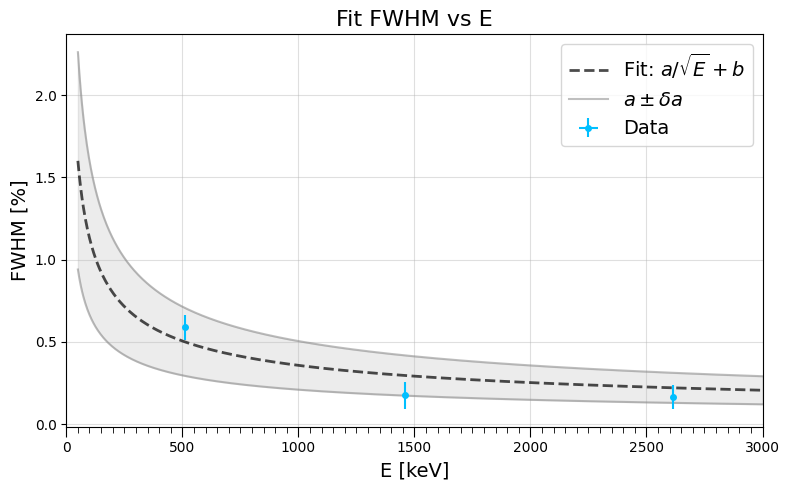

In [60]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,100])
p0=[3,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma= FWHM_err, p0=p0, bounds=boundary)
perr_back_res = np.sqrt(np.diag(pcov))
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))

dx = 500
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero





plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, *popt)*100, label=r'Fit: $a/\sqrt{E} + b$',  color='black', ls = '--', alpha = 0.7, lw=2)

upper_curve = fhwm_func(E_fit, popt[0] + perr_back_res[0], popt[1]) * 100
lower_curve = fhwm_func(E_fit, popt[0] - perr_back_res[0], popt[1]) * 100

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.5, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.5)

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*5*100,
             fmt='o',  
             color = 'deepskyblue', 
             markersize=4,               # dimensione punto
             label='Data')

a_res_bkg = popt[0]
b_res_bkg  = popt[1]

# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.xlim(0, 3000)
plt.title('Fit FWHM vs E',  size = 16)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig("new image/FWHM_bkg", dpi=300, bbox_inches='tight')
plt.show()

# Background open

In [63]:
# Load the spectrum data
file_path = "Bckg_OPEN.csv"
data = pd.read_csv(file_path, header=None)


# Ensure data is 1D (each count per channel/bin)
spectrum_open = data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_open = 58348
t_real_open = 58394
# correggo subito per il tempo morto

spectrum_open[spectrum_open < 0] = 0 


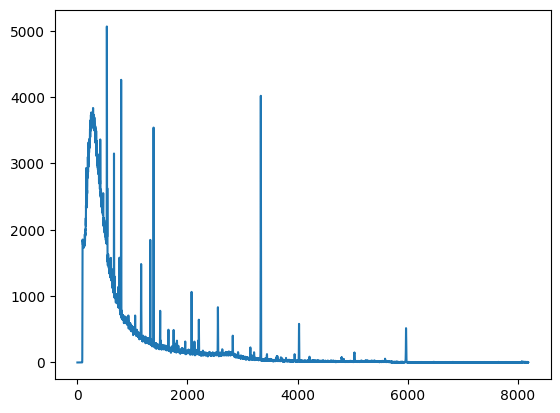

In [67]:
plt.plot(spectrum_open)

In [68]:
1-t_live_open/t_real_open

0.0007877521663184339

In [69]:
E_chn_plot = [535, 665, 763 ,795,  1324, 1383, 1503,  2074 , 2206 ,2552, 2822, 3141, 3442, 3196,
        3331,  3947, 4026,  5032 ,5971]

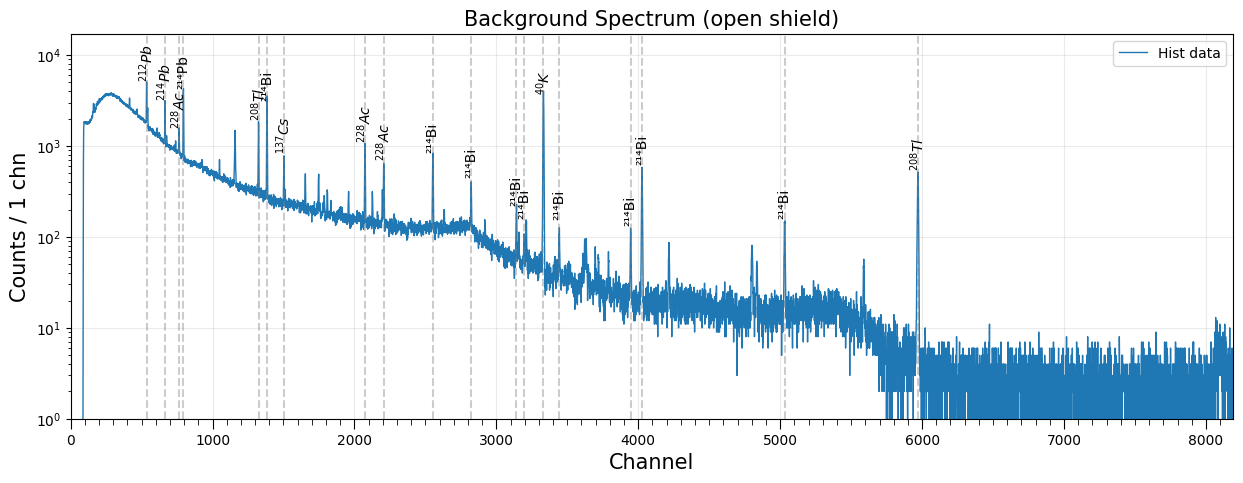

In [86]:
plt.figure(figsize=(15, 5))


dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




chn = np.arange(len(spectrum_open))
plt.plot(spectrum_open, lw = 1,label='Hist data')

isotopes= ['$^{212}Pb$','$^{214}Pb$',
           '$^{228}Ac $',  '²¹⁴Pb', 
               '$^{208}Tl $','²¹⁴Bi',
           '$^{137}Cs $','$^{228}Ac $','$^{228}Ac $',
               '²¹⁴Bi','²¹⁴Bi',
               '²¹⁴Bi','²¹⁴Bi',
                '$^{40}K $',
                '²¹⁴Bi','²¹⁴Bi',
              '²¹⁴Bi', '²¹⁴Bi','$^{208}Tl $']



db = chn[1]-chn[0]
plt.xlabel('Channel', size = 15)
plt.ylabel(f'Counts / {db:.0f} chn', size = 15)
plt.title('Background Spectrum (open shield)', size = 15)
plt.xlim(0, len(spectrum_open))
plt.ylim(1,max(spectrum_open)+12000)
E_chn = np.sort(E_chn_plot)
for i, (chn, iso) in enumerate(zip(E_chn, isotopes)):
    if chn < len(spectrum_open):
        # Alterna l'altezza del testo tra 1x e 3x
        factor = 50 if i % 2 == 0 else 20
        plt.text(chn, spectrum_open[chn] + factor , f"{iso}",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
        plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)
'''
plt.text(2132, 1e7, r"$^{60}Co$",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
plt.axvline(x=2132, color='gray', linestyle='--', alpha=0.4)

plt.text(2632, 1e7, r"$^{60}Co$",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
plt.axvline(x=2632, color='gray', linestyle='--', alpha=0.4)
'''
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.25)
plt.savefig("new image/spettro_chn_op", dpi=300, bbox_inches='tight')

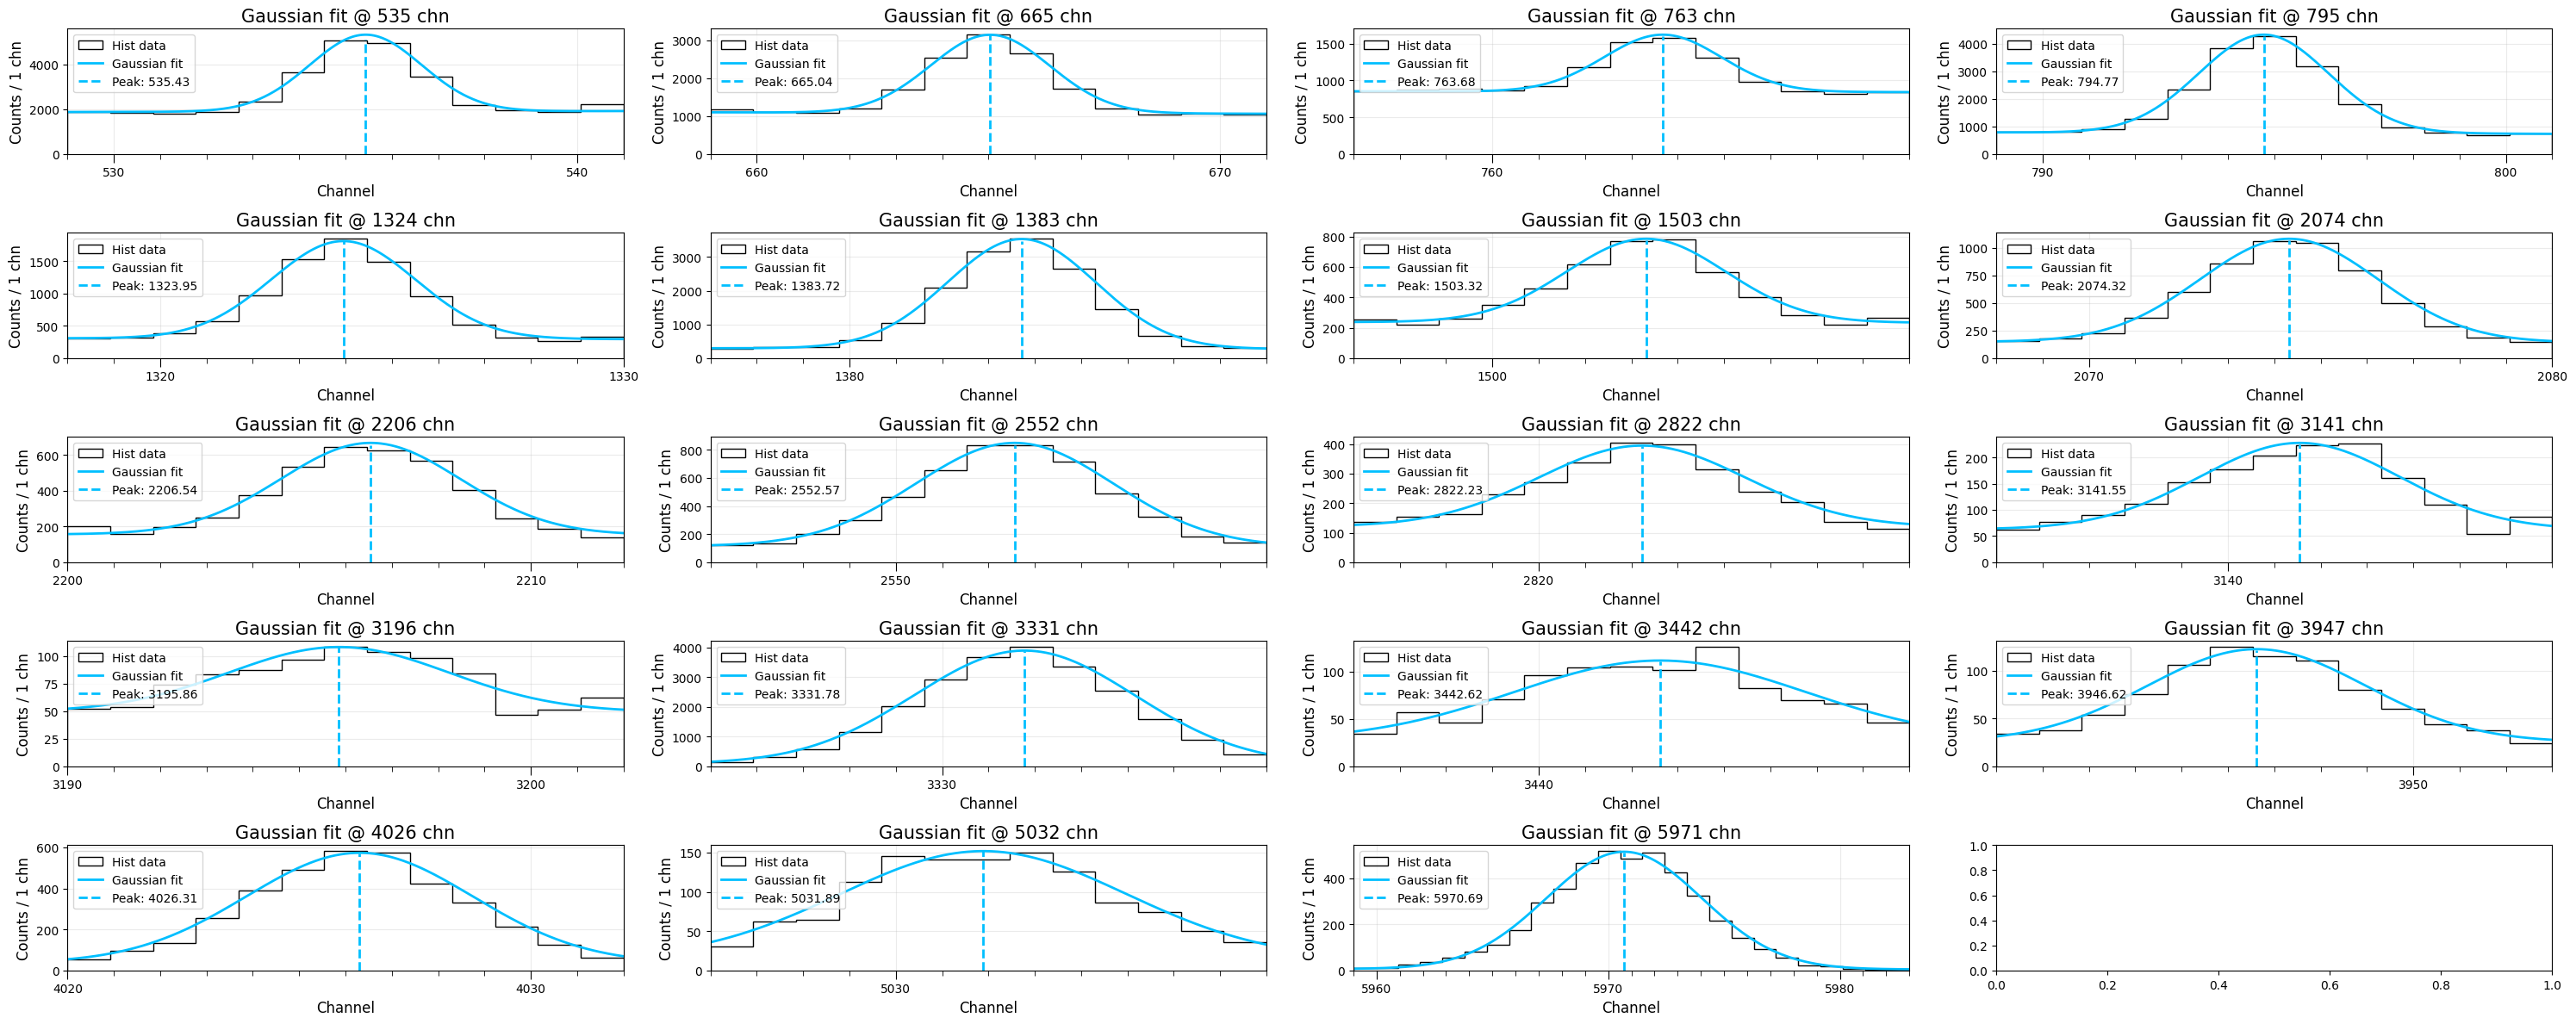

In [87]:
fig, axes = plt.subplots(5, 4, figsize=(30, 12))  # 1 riga, 3 colonne
E_chnt = [535, 665, 763 ,795,  1324, 1383, 1503,  2074 , 2206 ,2552, 2632, 2822, 3141, 3442, 3196,
        3331,  3947, 4026,  5032 ,5971]
#E_chn = [1158, 3331, 5970] 
popt_chn = []
popt_chn_err = []
axes = axes.flatten() 
for i, e in enumerate(E_chn):
   # print(i+1)
    ax = axes[i]
    if e == E_chn[-1]:
        dx =12
    else:
        dx = 6
    popt, err, _ = fit_func(spectrum_open, e, dx=dx, ax=ax)
    popt_chn.append(popt)
    popt_chn_err.append(err)

popt_chn = np.vstack(popt_chn)

popt_chn_err = np.vstack(popt_chn_err)
plt.savefig("new image/chn_bkg_peaks", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


In [88]:
len(E_kev)

3

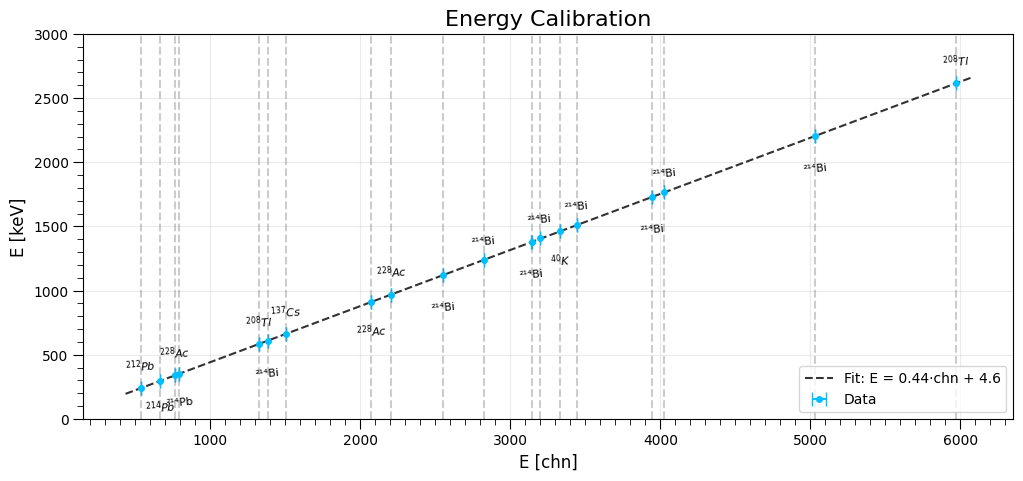

In [89]:
#E_kev = [511, 1460.830, 2614] #kev
E_kev_plot = [238.632, 338.32, 351.932, 295,  583, 609,  661.66,911.20, 969, 1120, 1238, 1377, 1407, 1460.83, 1509.228, 1729, 1764,2204, 2614]
E_chn = np.sort(E_chn_plot)
E_kev = np.sort(E_kev_plot)
popt_chn_arr = np.sort( popt_chn[:,1])


plt.figure(figsize=(12, 5))



dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

dx = 500
dy = 100
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.yaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='y', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='y', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




plt.errorbar(popt_chn_arr,E_kev, xerr=popt_chn_err[:,1], fmt='o', color = 'deepskyblue', markersize = 4, capsize=5, label='Data')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, popt_chn_arr, E_kev, p0=p0 )
# Incertezze
perr = np.sqrt(np.diag(pcov))
a_open = popt[0]
b_open = popt[1]

for i, (chn, iso) in enumerate(zip(popt_chn_arr, isotopes)):
    if chn < len(spectrum_open):  # Controllo sicurezza
        if i< 5:
            dy = 275
        else:
            dy = 300
        y_pos = E_kev[i] + (100 if i % 2 == 0 else -dy)  # Alterna altezza per evitare sovrapposizione
        x_pos = popt_chn_arr[i] + (-100 if i % 2 == 0 else 100) 
        plt.text(chn, y_pos, iso,
                 rotation=5, va='bottom', ha='center', fontsize=8, color='black')
        plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)

# Plot
x_fit = np.linspace(min(popt_chn[:,1])-100, max(popt_chn[:,1])+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', markersize = 0.05, alpha = 0.8)

plt.ylim(0, 3000)
plt.legend(fontsize = 10)
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("new image/E_cal_bkg", dpi=300, bbox_inches='tight')

In [90]:
 print(a_open , '+/-', perr[0])
print(b_open , '+/-', perr[1])

0.4371358930269658 +/- 0.00021073181099265698
4.560320928188184 +/- 0.6253459880649931


In [91]:
channels_open = np.arange(len(spectrum_open))         # x originale
energies_open = a_open * channels_open + b_open

In [92]:
122/170

0.7176470588235294

In [202]:
mask = (energies_open > 60) & (energies_open < 3000)
spectr_3Mev = spectrum_open[mask]

print(np.sum(spectr_3Mev))
print('attività grezza', np.sum(spectr_3Mev)/(t_live_open), 'cps')

2171343
attività grezza 37.21366627819291 cps


In [178]:
E_kev

array([ 238.632,  295.   ,  338.32 ,  351.932,  583.   ,  609.   ,
        661.66 ,  911.2  ,  969.   , 1120.   , 1238.   , 1377.   ,
       1407.   , 1460.83 , 1509.228, 1729.   , 1764.   , 2204.   ,
       2614.   ])

In [179]:
dofs

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 18, 18, 18, 18, 18, 18, 17, 18]

In [180]:
len(E_kev)

19

[4.69551541e+03 2.38617198e+02 5.41241532e-01 7.72715986e+00
 1.00000000e+00]
[1.51851204e+02 1.31731989e-02 1.51337086e-02 2.12636458e+01
 5.09333366e+03]
[ 2.92363650e+03  2.95272540e+02  5.64689600e-01 -7.01665209e+00
  3.15000000e+03]
[8.77450856e+01 1.05095432e-02 1.32982606e-02 1.24588842e+01
 3.65785898e+03]
[ 1.05867010e+03  3.38392147e+02  5.47975173e-01 -2.15489136e+00
  1.58000000e+03]
[5.52162741e+01 1.95721768e-02 2.35924369e-02 8.06472094e+00
 2.72036691e+03]
[ 5.45848797e+03  3.51985073e+02  6.11728909e-01 -9.94243181e+00
  4.26100000e+03]
[9.85931792e+01 8.41754570e-03 9.61833136e-03 1.07995558e+01
 3.80851375e+03]
[ 2.53679580e+03  5.83312257e+02  6.76587537e-01 -2.62830662e+00
  1.84800000e+03]
[1.15325785e+02 1.66566487e-02 2.14814599e-02 1.33950892e+01
 7.78476740e+03]
[ 5.67090806e+03  6.09435024e+02  6.96937992e-01 -5.33632323e+00
  3.54100000e+03]
[1.54813276e+02 1.15435078e-02 1.42468162e-02 1.59343921e+01
 9.67725656e+03]
[ 1.15118215e+03  6.61714492e+02  8.080

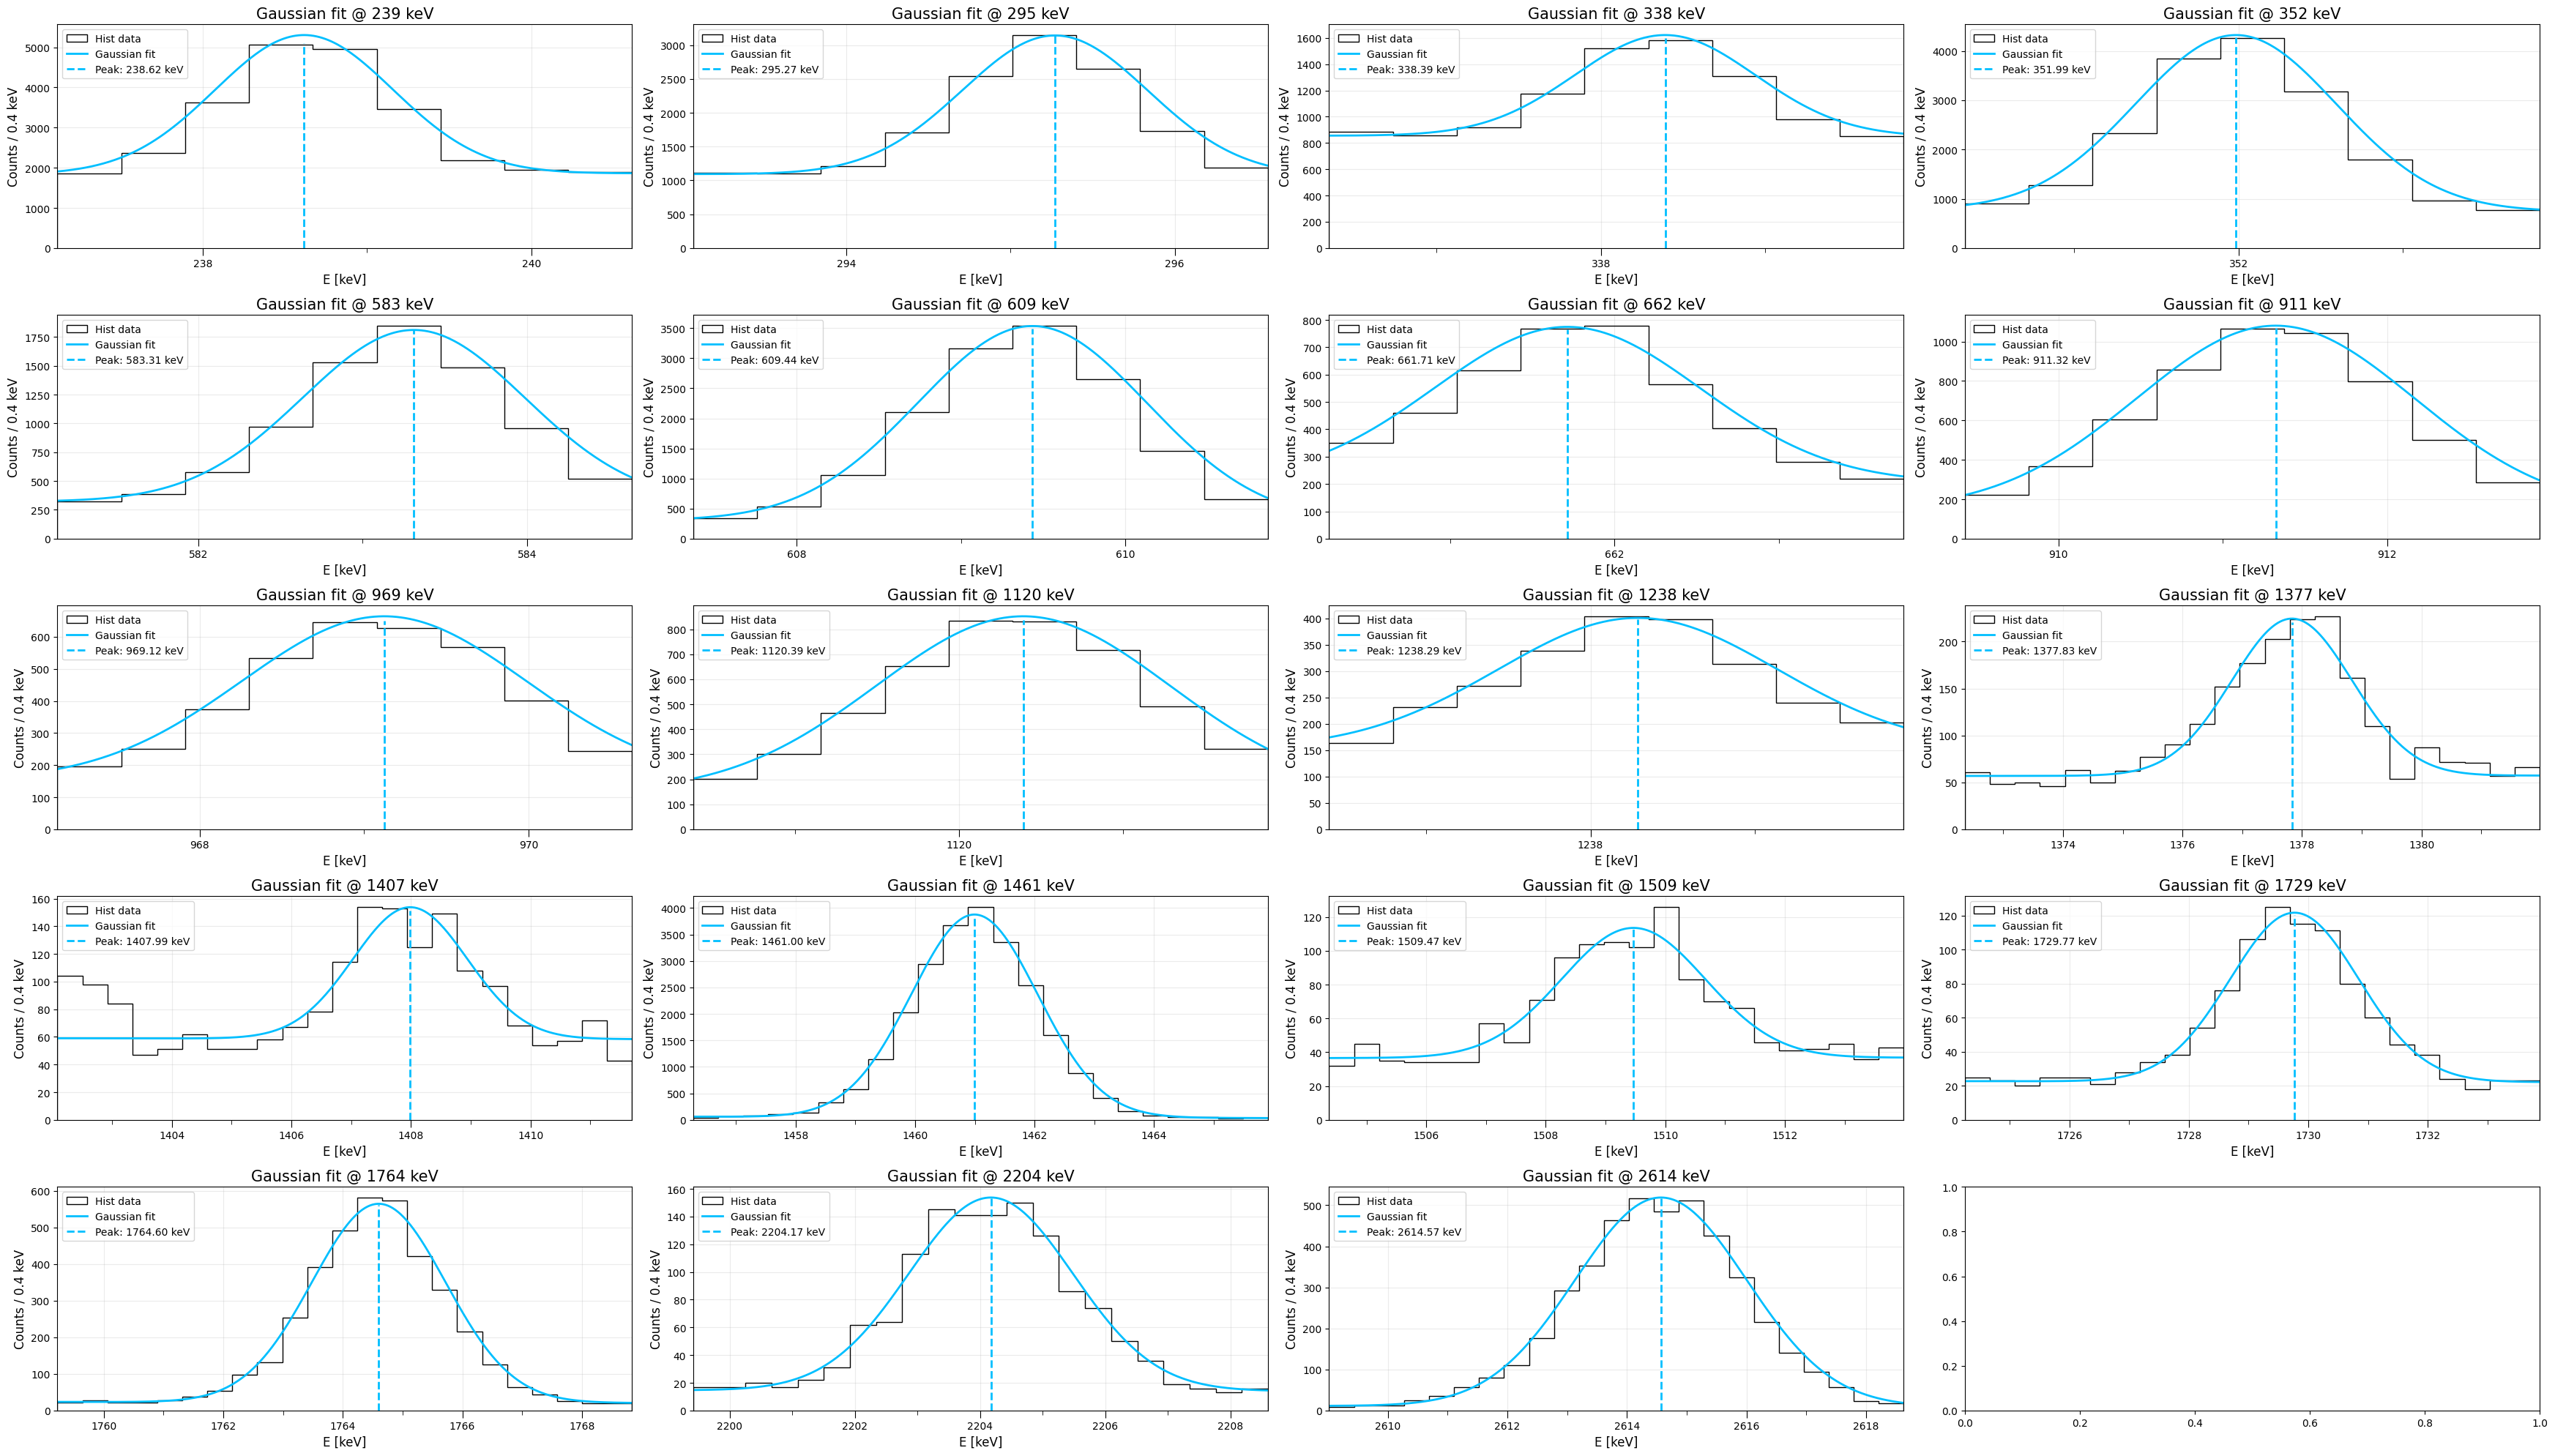

In [98]:
fig, axes = plt.subplots(5, 4, figsize=(35, 20))  # 1 riga, 3 colonne
#E_kev = np.sort([ 511, 1460.83, 2614 ]) #kev
popt_kev = []
popt_kev_err = []
dofs = []
axes = axes.flatten() 
for i, e in enumerate(E_kev):
    if i <=10:
        dx = 2
    else:
        dx = 5
    popt, err, dof = fit_func( spectrum_open, e, dx = dx, kev = True, energies = energies_open, ax=axes[i])
    print(popt)
    print(err)
    popt_kev.append(popt)
    popt_kev_err.append(err*2.5)
    dofs.append(dof)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)
#dofs = np.vstack(dofs)

plt.tight_layout()
plt.savefig("HPGE open background/energy_peak_fit_bkg", dpi=300, bbox_inches='tight')
plt.show()


In [99]:
dofs

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 18, 18, 18, 18, 18, 18, 17, 18]

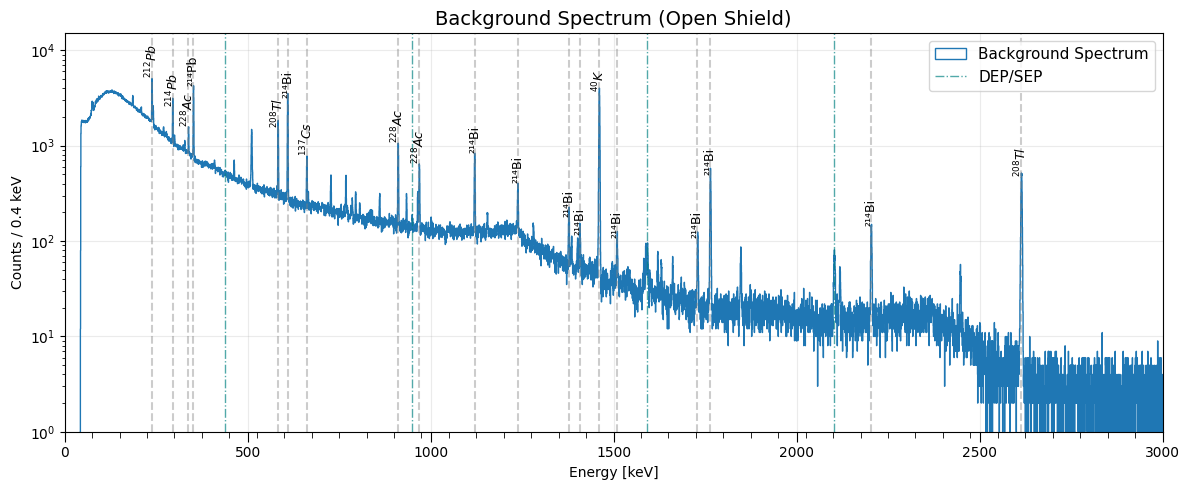

In [104]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np

plt.figure(figsize=(12, 5))

# Configurazione assi x
dx = 500
dy = 75
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=7, labelsize=10)
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)

# Istogramma
bins = np.linspace(min(energies_open), max(energies_open), len(energies_open))
counts, bin_edges, _ = plt.hist(energies_open, bins=bins, weights=spectrum_open,
                                lw=0.5, histtype='step', label='Background Spectrum')
db = bin_edges[1] - bin_edges[0]

# Annotazioni isotopi
for i, (energy, iso) in enumerate(zip(E_kev, isotopes)):
    if min(energies_open) < energy < max(energies_open):
        # Trova il bin index più vicino per posizionare correttamente l'etichetta
        idx = np.abs(energies_open - energy).argmin()
        y_val = spectrum_open[idx]
        y_pos = y_val + (2.5if i % 2 == 0 else 3)
        plt.text(energy, y_pos, iso,
                 rotation=90, va='bottom', ha='center', size=9, color='black')
        plt.axvline(x=energy, color='gray', linestyle='--', alpha=0.4)
'''
plt.text(1173, 5e5, r"$^{60}Co$",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
plt.axvline(x=1173, color='gray', linestyle='--', alpha=0.4)

plt.text(1332, 5e5, r"$^{60}Co$",
                 rotation=90, va='bottom', ha='center', size=10, color='black')
plt.axvline(x=1332, color='gray', linestyle='--', alpha=0.4)
'''
# Etichette assi e titolo
plt.xlabel('Energy [keV]', fontsize=10)
plt.ylabel(f'Counts / {db:.1f} keV', fontsize=10)
plt.title('Background Spectrum (Open Shield)', fontsize=14)




for i, v in enumerate(np.sort(mu_kev)):
    if v >= 1000:
        # Label only the first vertical line once
        label = 'DEP/SEP' if i == np.argmax(mu_kev) else None
        
        # DEP/SEP di 214-Bi 2204 keV
        plt.vlines(v-511, 1, np.max(spectrum_open)+10000,  color = 'teal', lw = 1, ls = '-.',alpha = 0.68, label = label)
        plt.vlines(v-511-511, 1, np.max(spectrum_open)+10000,  color = 'teal', lw = 1,ls = '-.', alpha = 0.68)


        


# Limiti assi
plt.xlim(0, 3000)
plt.ylim(1, np.max(spectrum_open)+10000)  # log scale → evitare zero

# Scala logaritmica y
plt.yscale('log')

# Legenda, griglia e salvataggio
plt.legend(loc='upper right', fontsize=11)
plt.grid(alpha=0.25)

plt.tight_layout()
plt.savefig("new image/spectrum_bkg_kev_open.png", dpi=300, bbox_inches='tight')


In [108]:
mask = (energies_open > 60) & (energies_open < 3000)
spectr_3Mev = spectrum_open[mask]

print(np.sum(spectr_3Mev))
print('attività grezza', np.sum(spectr_3Mev)/(t_live_open), 'cps')

2171343
attività grezza 37.21366627819291 cps


In [106]:
mask = (energies_open > 60) & (energies_open < 3000)

spectr_3Mev = spectrum_open[mask]
cps_total = np.sum(spectr_3Mev)/(t_live_open)

print(f'count rate totale {cps_total:.0f} cps')

count rate totale 37 cps


In [113]:
1/37

0.02702702702702703

In [114]:
for i in range(0, len(popt_kev[:,1])):
    mu_kev = popt_kev[:,1]
    mu_kev_err = popt_kev_err[:,1]
    mu_theo = E_kev[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo, dof = 1)
    

t = -0.45
✅ p > 0.05 
p-value = 0.7311
t = 10.37
✅ p > 0.05 
p-value = 0.0612
t = 1.47
✅ p > 0.05 
p-value = 0.3794
t = 2.52
✅ p > 0.05 
p-value = 0.2403
t = 7.50
✅ p > 0.05 
p-value = 0.0844
t = 15.07
❌ p < 0.05 
p-value = 0.0422
t = 0.35
✅ p > 0.05 
p-value = 0.7867
t = 2.51
✅ p > 0.05 
p-value = 0.2414
t = 0.91
✅ p > 0.05 
p-value = 0.5284
t = 7.00
✅ p > 0.05 
p-value = 0.0903
t = 1.46
✅ p > 0.05 
p-value = 0.3822
t = 4.22
✅ p > 0.05 
p-value = 0.1483
t = 2.52
✅ p > 0.05 
p-value = 0.2409
t = 5.49
✅ p > 0.05 
p-value = 0.1146
t = 1.00
✅ p > 0.05 
p-value = 0.5008
t = 8.23
✅ p > 0.05 
p-value = 0.0770
t = 12.18
✅ p > 0.05 
p-value = 0.0521
t = 1.41
✅ p > 0.05 
p-value = 0.3932
t = 7.67
✅ p > 0.05 
p-value = 0.0825


incertezza grandi solo 3 punti del fit
paramters: [6.70168209e-02 5.60830800e-31]
Errori: [2.76557387e-03 1.71994186e+01]


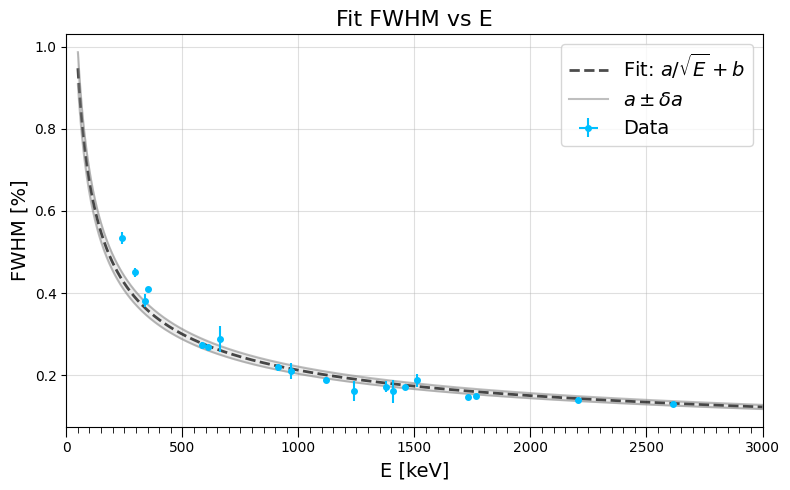

In [115]:
# Calcolo FWHM e incertezza
sigma= popt_kev[:,2]
sigma_err_kev=popt_kev_err[:,2]/2.5
mu_kev=popt_kev[:,1]
mu_kev_err =popt_kev_err[:,1]
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,100])
p0=[3,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma= FWHM_err, p0=p0, bounds=boundary)
perr_open_res = np.sqrt(np.diag(pcov))

a_open_res = popt[0]
b_open_res = popt[1]

print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))


dx = 500
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero




plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit, a_open_res, b_open_res)*100, label=r'Fit: $a/\sqrt{E} + b$',  color='black', ls = '--', alpha = 0.7, lw=2)

upper_curve = fhwm_func(E_fit, a_open_res + perr_open_res[0], b_open_res) * 100
lower_curve = fhwm_func(E_fit, a_open_res - perr_open_res[0], b_open_res) * 100

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.5, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.5)

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',  
             color = 'deepskyblue', 
             markersize=4,               # dimensione punto
             label='Data')

# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.xlim(0, 3000)
plt.title('Fit FWHM vs E',  size = 16)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig("new image/FWHM open baclground", dpi=300, bbox_inches='tight')
plt.show()

# Uranium Spectrum

In [116]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto
D_u = 1-(t_live_u/t_real_u)

spectrum_U = spectrum_U/D_u

In [117]:
E_chn_U = [ 415, 543,665,794, 1382, 1746,2125, 2550,4024]
E_kev_U = [ 185.712, 242,295.224, 351.932,  609.312,768.356, 934.061, 1120,  1764.494]
E_kev_U = [ 186.221, 242,295.224, 351.932,  609.312,768.356, 934.061, 1120,  1764.494]

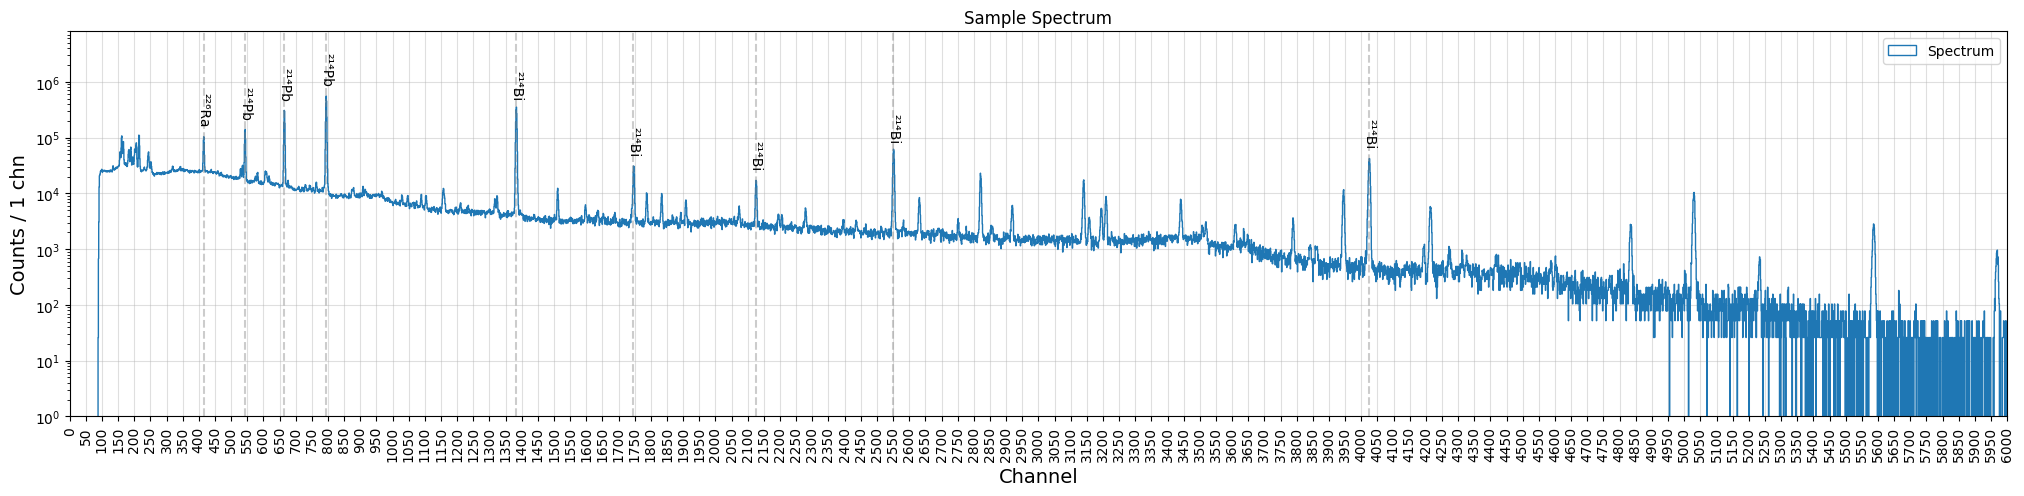

In [118]:
# Canali dei picchi identificati nello spettro
#E_chn_U = [415, 543, 665, 794, 1382, 1746, 2125, 4024]
# Isotopi corrispondenti
isotopes = ['²²⁶Ra', '²¹⁴Pb', '²¹⁴Pb', '²¹⁴Pb', '²¹⁴Bi', '²¹⁴Bi','²¹⁴Bi','²¹⁴Bi',  '²¹⁴Bi']

plt.figure(figsize=(25, 5))
#plt.plot(spectrum_U, lw=0.5, label='Spectrum')

chn =  np.arange(len(spectrum_U))
bins =  np.linspace(min(chn), max(chn), len(chn), +1 )
counts, bin_edge, _ = plt.hist(chn, bins = bins, weights = spectrum_U,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]
# Etichette degli isotopi sui picchi
for chn, iso in zip(E_chn_U, isotopes):
    plt.text(chn, spectrum_U[chn]*1.5, f"{iso}",
             rotation=270, va='bottom', ha='center', size=10, color='black')
    plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)
chn =  np.arange(len(spectrum_U))
plt.xticks(np.arange(min(chn), max(chn), 50), rotation=90)
plt.xlabel('Channel', size=14)
plt.ylabel(f'Counts / {db:.0f} chn', size=14)
plt.title('Sample Spectrum')
#plt.title('Uranium Spectrum', size=15)
#plt.xlim(0, 6000)
plt.xlim(0, 6000)
plt.ylim(1, 8e6)
plt.yscale('log')
plt.grid(alpha=0.4)
plt.legend()
plt.savefig("HPGe images/238U/ 238U_channel", dpi=300, bbox_inches='tight')
plt.show()

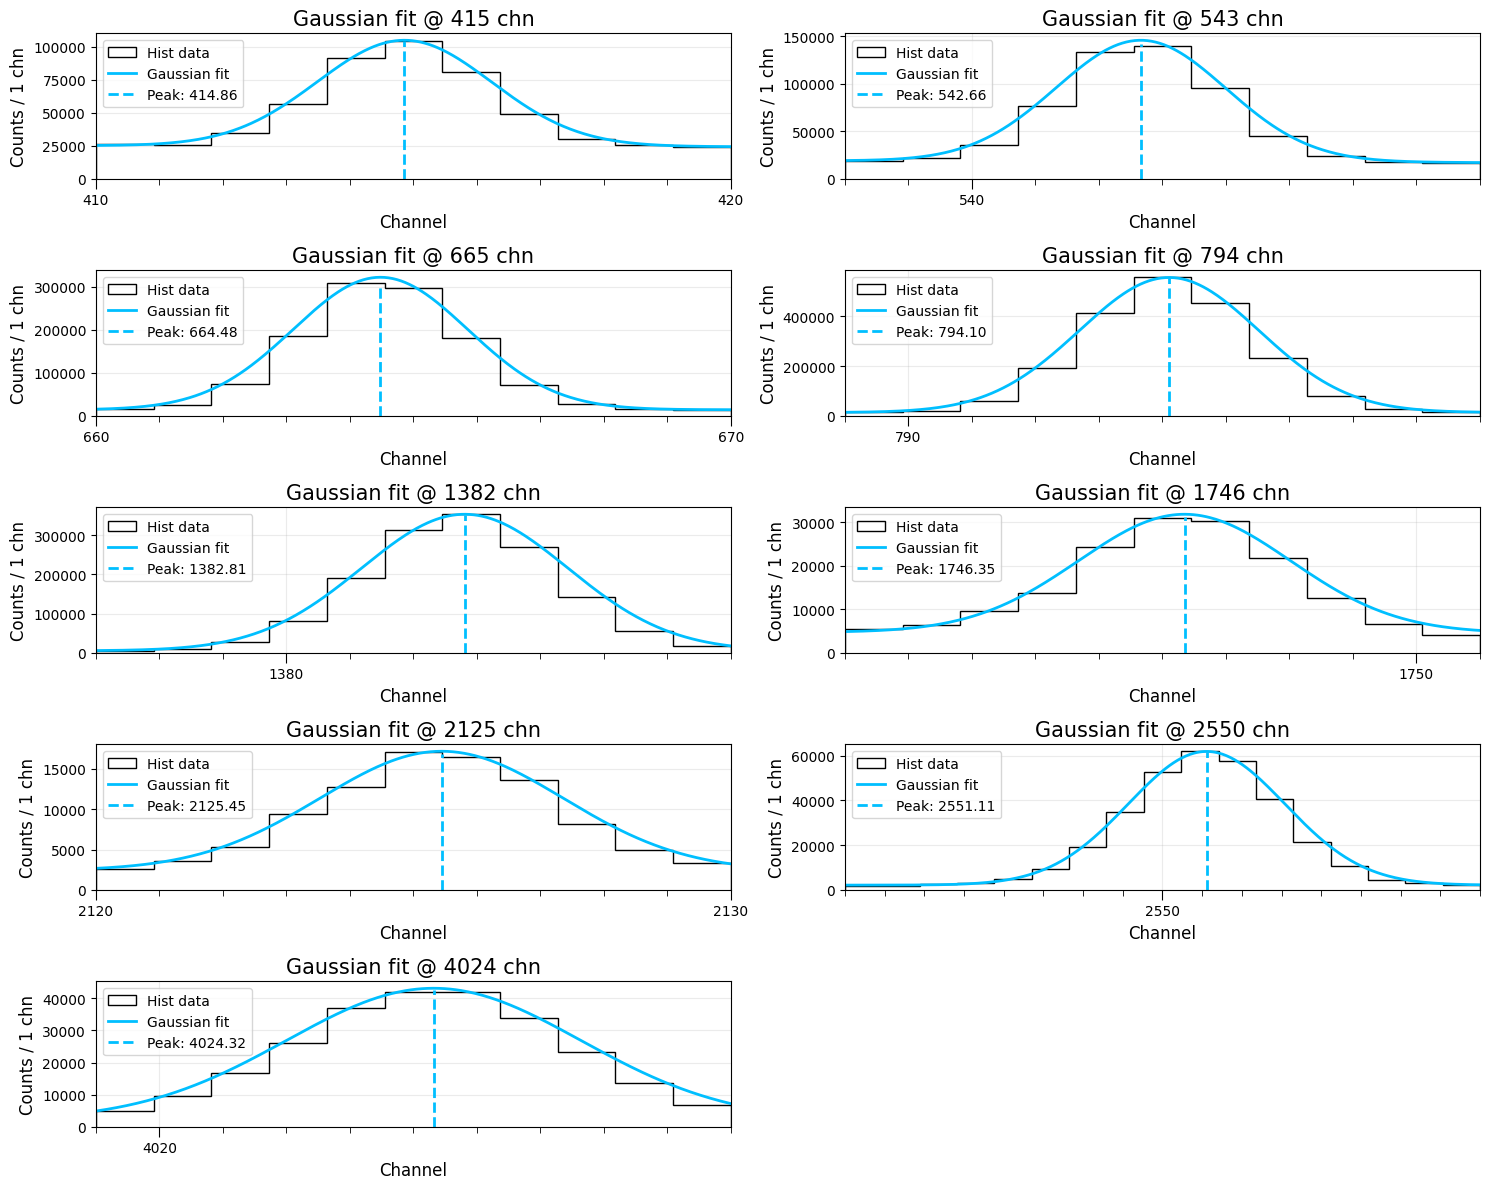

In [823]:
fig, axes = plt.subplots(5, 2, figsize=(15, 12))  # 10 subplot totali

popts_U = []
err_U = []

axes = axes.flatten()  # Rende la matrice 2D in un array 1D per iterare più facilmente

for i, e in enumerate(E_chn_U):
    ax = axes[i]
    dx = 8 if i == 7 else 5
    popt, err, _ = fit_func(spectrum_U, e, dx=dx, ax=ax)
    popts_U.append(popt)
    err_U.append(err)

# Rimuove i subplot vuoti
for j in range(len(E_chn_U), len(axes)):
    fig.delaxes(axes[j])

popts_U = np.vstack(popts_U)
err_U = np.vstack(err_U)

plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()


In [824]:
E_kev_U

[186.221, 242, 295.224, 351.932, 609.312, 768.356, 934.061, 1120, 1764.494]

Uncertainty on a: 0.000211, on b: 0.63


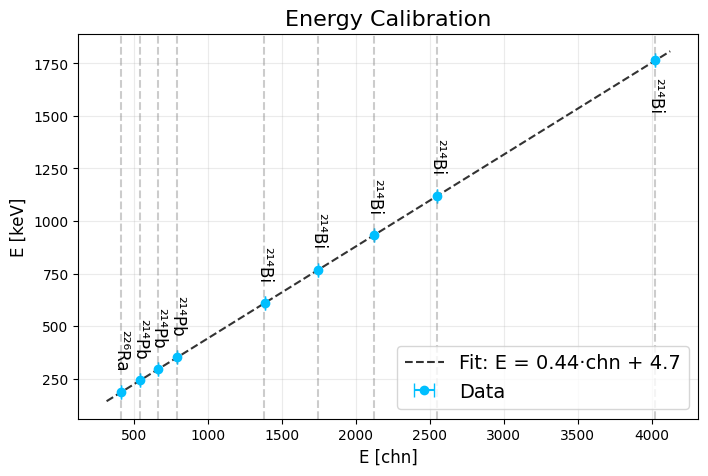

In [825]:
mu_chn = popts_U[:, 1]
mu_chn_err = err_U[:, 1]
plt.figure(figsize=(8, 5))
plt.errorbar( mu_chn,E_kev_U, xerr=mu_chn_err, fmt='o', color = 'deepskyblue', capsize=5, label='Data')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, mu_chn, E_kev_U, p0=p0 )
# Incertezze
perr_U = np.sqrt(np.diag(pcov))
print(f"Uncertainty on a: {perr[0]:.6f}, on b: {perr[1]:.2f}")
a = popt[0]
b = popt[1]

# Plot
x_fit = np.linspace(min(mu_chn)-100, max(mu_chn)+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)
for idx, (chn, iso) in enumerate(zip(E_chn_U, isotopes)):
    if idx == 8:
        plt.text(chn, E_chn_U[idx]*a + b - 250 , f"{iso}",
                 rotation=270, va='bottom', ha='center', size=12, color='black')
    else:
        plt.text(chn, E_chn_U[idx]*a + b + 100 , f"{iso}",
                 rotation=270, va='bottom', ha='center', size=12, color='black')
    plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.4)
plt.legend(fontsize = 14)
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("HPGe images/238U/E_ene_cal", dpi=300, bbox_inches='tight')

In [826]:
print('b', b)
print('b bkg', b_bkg)
print('a', a)
print('a bkg', a_bkg)

b 4.707398056912284
b bkg 4.682977688622721
a 0.4372576566898085
a bkg 0.43738294846886144


In [827]:
channels = np.arange(len(spectrum_U))         # x originale
energies = a * channels + b

In [828]:
for i in range(0,len(energies)):
    if spectrum_U[i] != 0:
        print(f' Energy threshold at {energies[i] + 15 : .2f} keV' )
        break

 Energy threshold at  58.19 keV


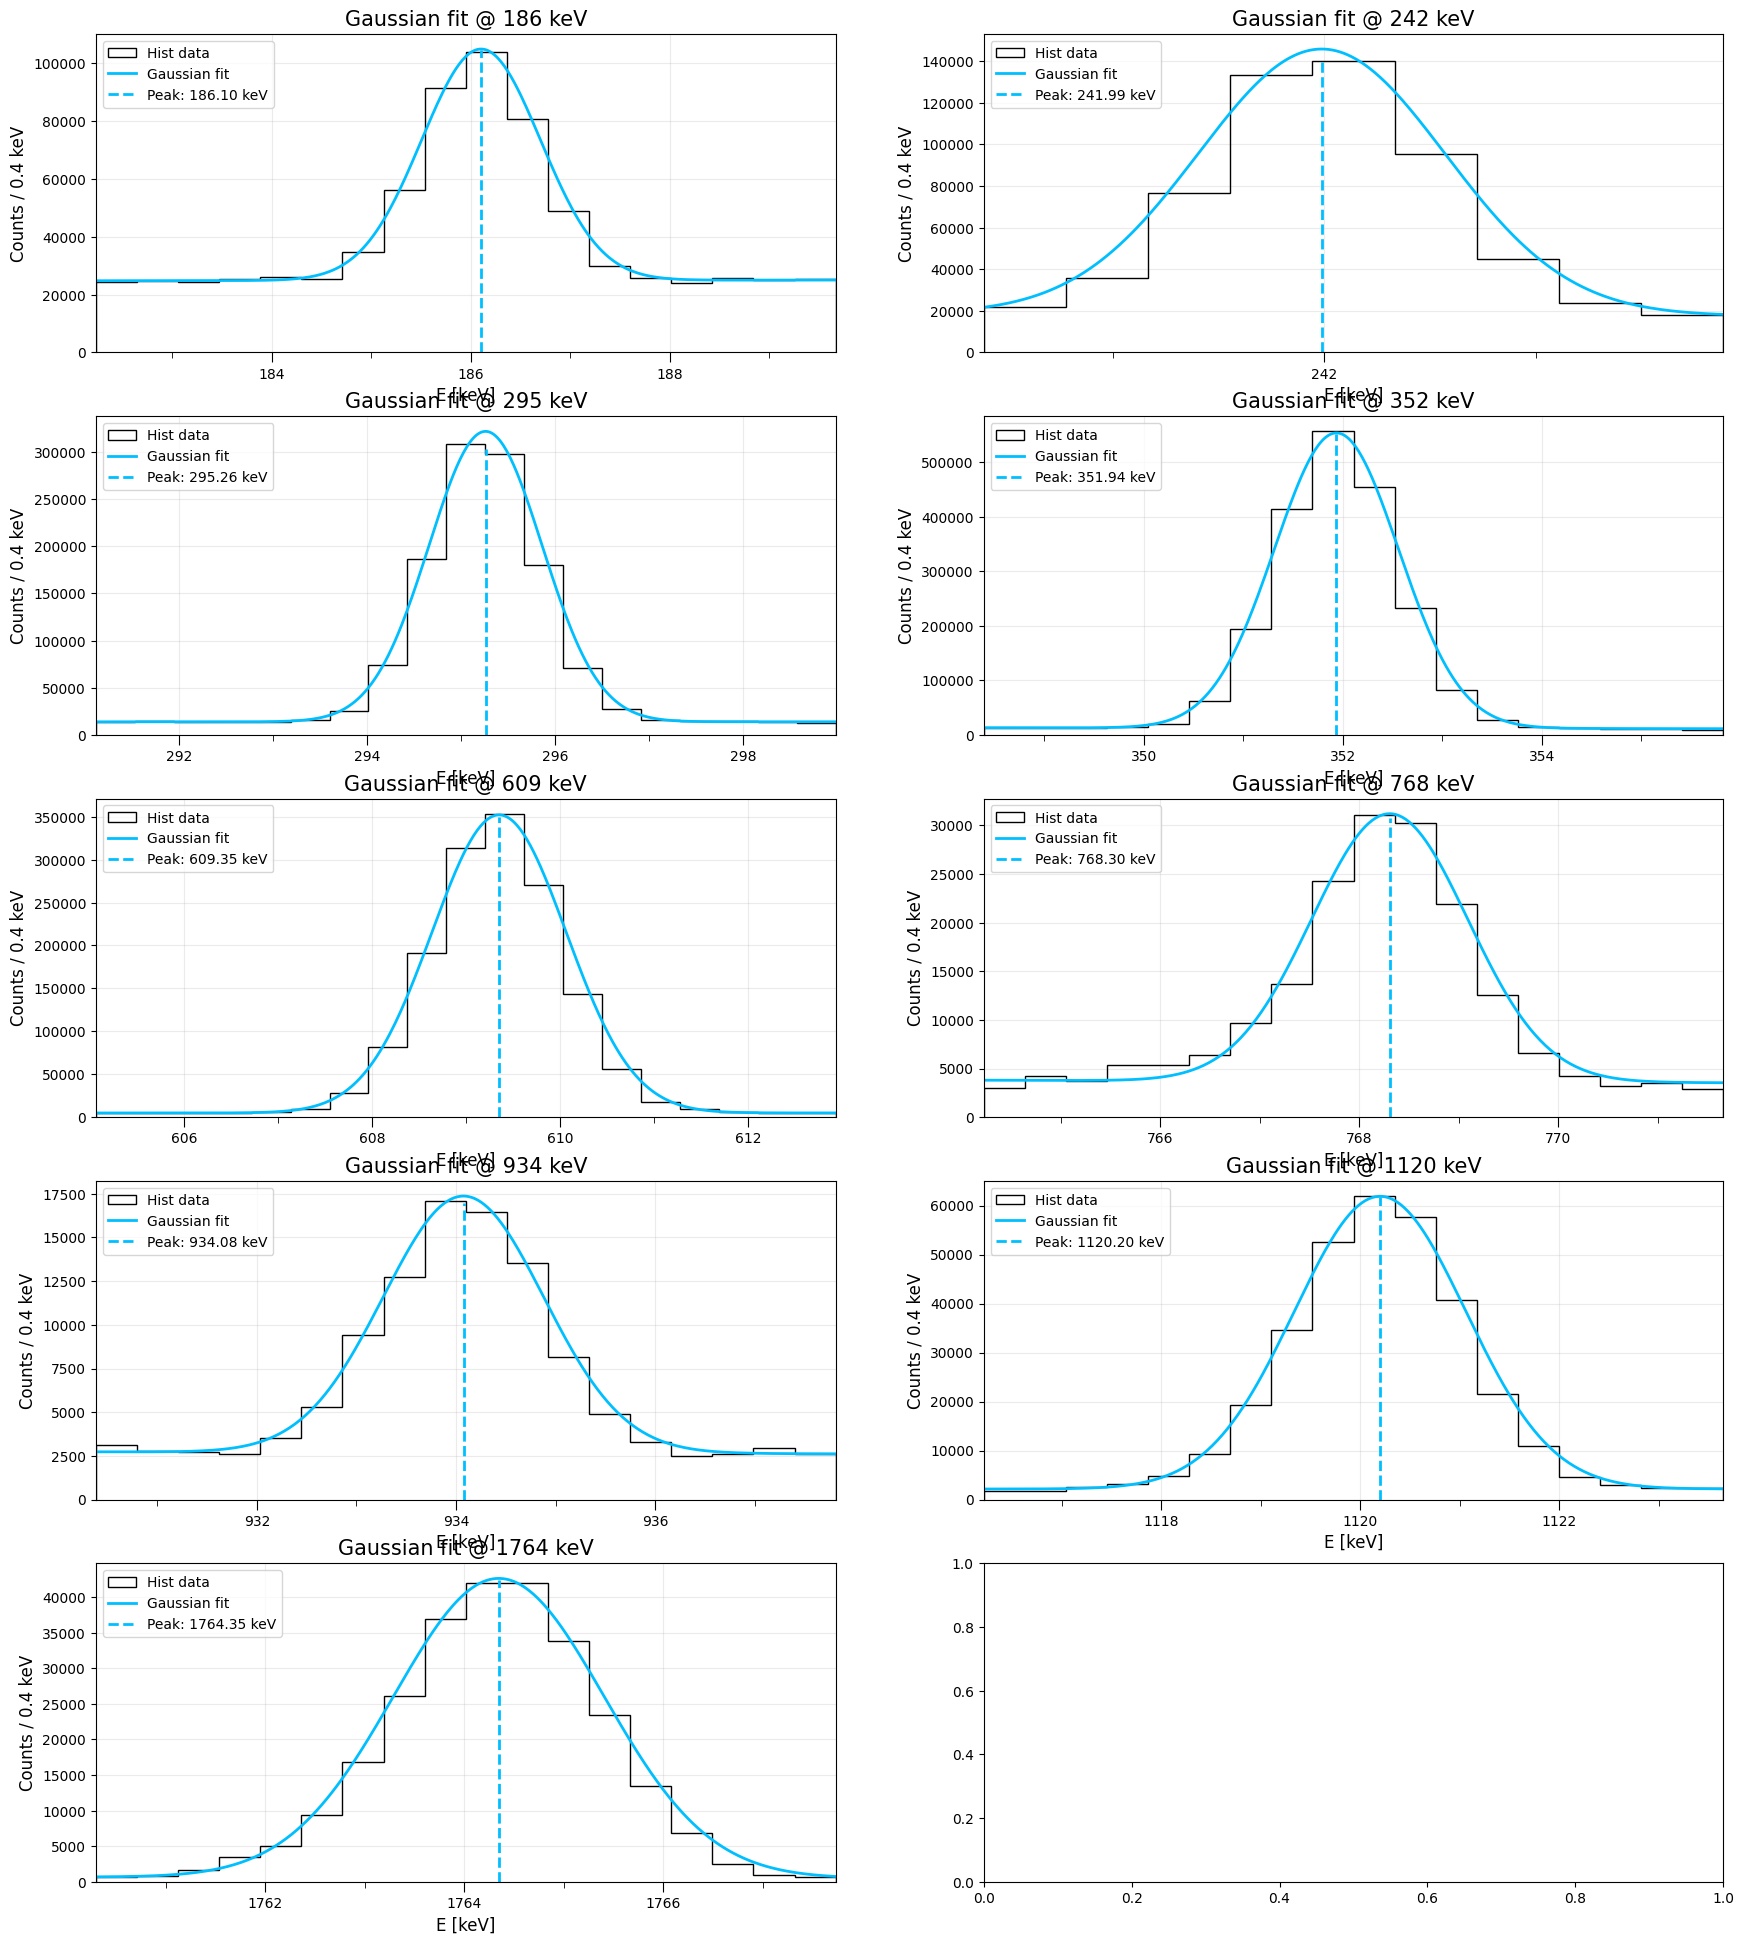

In [829]:
popts_U_kev = []
err_U_kev = []
dofs = []
fig, axes = plt.subplots(5,2, figsize=(21, 24))  # 1 riga, 3 colonne
for i, e in enumerate(E_kev_U):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    if e == E_kev_U[1]:
        dx = 2
    else:
        dx = 4
    popt, err, dof = fit_func(spectrum_U, e, dx =dx, kev = True, energies = energies, ax = ax)
    popts_U_kev.append(popt)
    err_U_kev.append(err*5)
    dofs.append(dof)
popts_U_kev = np.vstack(popts_U_kev)
err_U_kev = np.vstack(err_U_kev)

plt.savefig("HPGe images/ energy_peak_fit_U", dpi=300, bbox_inches='tight')

In [830]:
dofs

[13, 4, 14, 13, 14, 13, 13, 13, 13]

In [831]:
mu_kev=popts_U_kev[:,1]
mu_kev_err= err_U_kev[:,1]
for i in range(0, len(mu_kev)):
    mu_theo = E_kev_U[i]
    mu_exo = mu_kev[i]
    err = mu_kev_err[i]
    _ = t_test_theoretical(mu_exo,err,mu_theo, dof = 1)
    

t = -3.34
✅ p > 0.05 
p-value = 0.1853
t = -0.35
✅ p > 0.05 
p-value = 0.7843
t = 1.71
✅ p > 0.05 
p-value = 0.3365
t = 0.22
✅ p > 0.05 
p-value = 0.8641
t = 1.23
✅ p > 0.05 
p-value = 0.4344
t = -0.29
✅ p > 0.05 
p-value = 0.8176
t = 0.15
✅ p > 0.05 
p-value = 0.9057
t = 3.24
✅ p > 0.05 
p-value = 0.1907
t = -1.26
✅ p > 0.05 
p-value = 0.4259


incertezza grandi solo 3 punti del fit
paramters: [7.57877357e-02 1.84233408e-16]
Errori: [6.79574835e-03 1.07997918e+02]


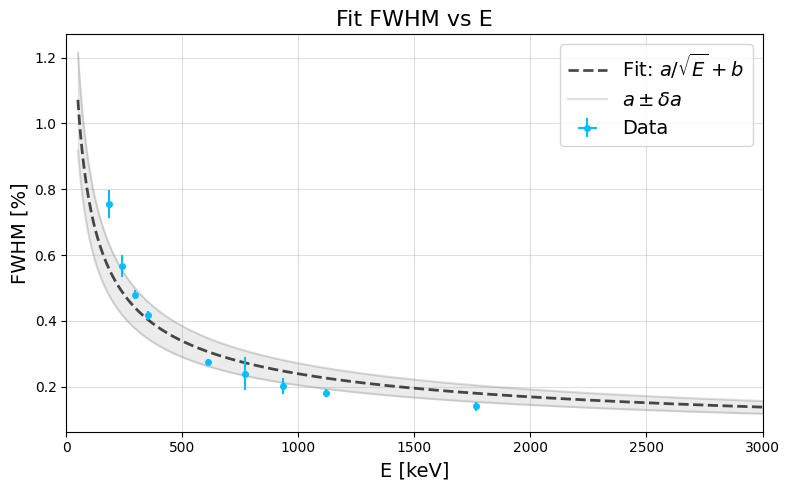

In [832]:
sigma=popts_U_kev[:,2]
sigma_err_kev = err_U_kev[:,2]
mu_kev=popts_U_kev[:,1]
mu_kev_err= err_U_kev[:,1]
# Calcolo FWHM e incertezza
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
FWHM_err = FWHM_err
# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,1])
p0=[0.1,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err, p0=p0, bounds=boundary)
perr_U_res = np.sqrt(np.diag(pcov))
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit,*popt )*100, label=r'Fit: $a/\sqrt{E} + b$ ', color='black', ls = '--', alpha = 0.7, lw=2)
# Dati con errore su x e y, e stile pallini
plt.errorbar(mu_kev, FWHM*100,
             xerr=mu_kev_err,
             yerr=FWHM_err*100,
             fmt='o',     
             color = 'deepskyblue', 
             markersize=4,               # dimensione punto
             label='Data')
upper_curve = fhwm_func(E_fit, popt[0] + 1.5*perr_U_res[0], popt[1]) * 100
lower_curve = fhwm_func(E_fit, popt[0] - 1.6*perr_U_res[0], popt[1]) * 100

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.25, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.25)
a_res_U = popt[0]
b_res_U  = popt[1]
# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.title('Fit FWHM vs E',  size = 16)
plt.xlim(0,3000)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("HPGe images/238U/ FWHM_U", dpi=300, bbox_inches='tight')
plt.show()

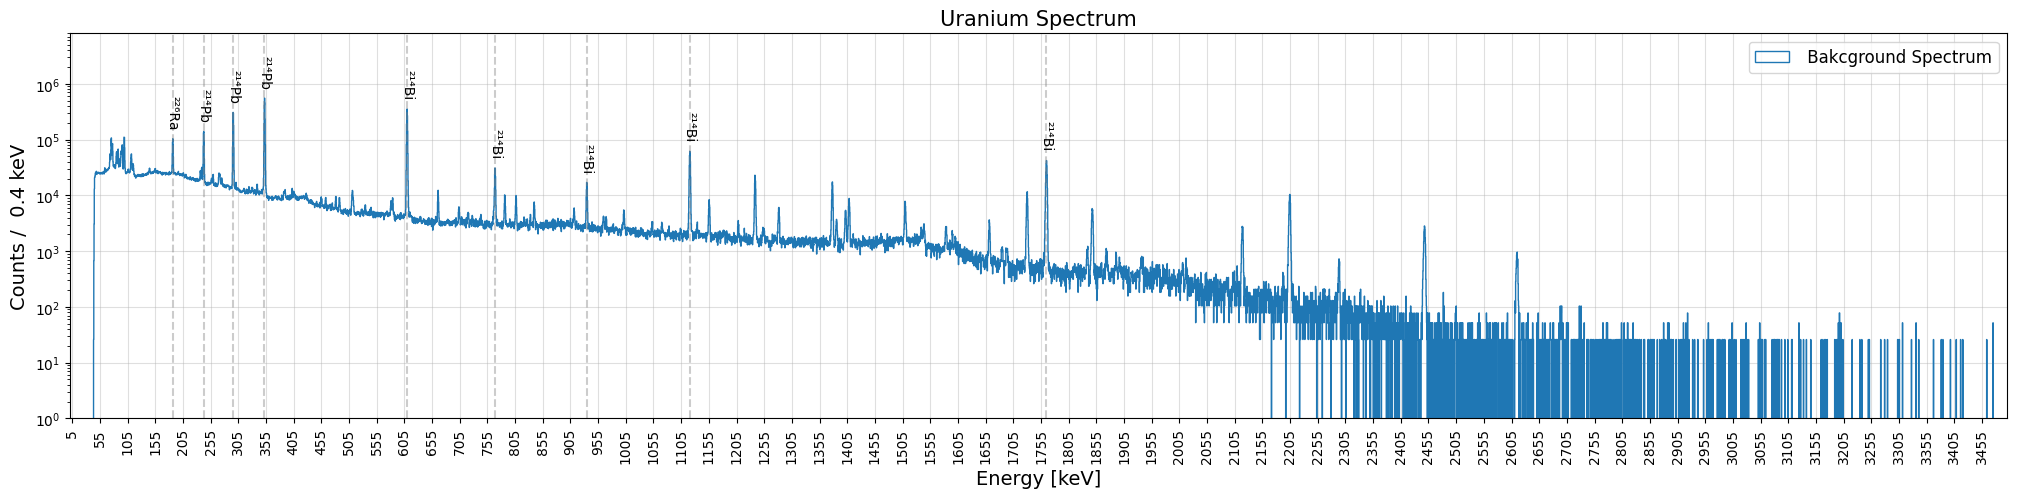

In [341]:
plt.figure(figsize=(25, 5))
bins = np.linspace(min(energies), max(energies), len(energies))
counts, bin_edge, _ = plt.hist(energies, bins = bins, weights = spectrum_U, lw = 0.25,  histtype='step',label=' Bakcground Spectrum')
db = bin_edge[1]-bin_edge[0]
# Colori per ogni fit
colors = plt.cm.cool(np.linspace(0, 1, len(popts_U_kev)))

# Fit gaussiani

for E, iso in zip(mu_kev, isotopes):
    y = np.interp(E, energies, spectrum_U)
    plt.text(E, y*1.5, f"{iso}",
             rotation=270, va='bottom', ha='center', size=10, color='black')
    plt.axvline(x=E, color='gray', linestyle='--', alpha=0.4)
    
plt.title('Sample Spectrum')
plt.xlabel('Energy [keV]', size=14)
plt.ylabel(f'Counts / {db : .1f} keV', size=14)
plt.title('Uranium Spectrum', size=15)
plt.xticks(np.arange(min(energies), max(energies), 50), rotation=90)
plt.xlim(0, 8000)
plt.ylim(1, 8e6)
plt.yscale('log')
plt.grid(alpha=0.4)
plt.xlim(0, 3500)
#plt.ylim(0, max(spectrum))
plt.yscale('log')
plt.legend(fontsize = 12)
plt.savefig("HPGe images/238U/U_energy_spectrum", dpi=300, bbox_inches='tight')
plt.show()

# Analis prova

In [126]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625


In [127]:
E_chn_U = [ 415, 528.9, 543,665,794,1320,
            1382, 1746,2125, 2551,4024,
            1510, 1787.4, 1832.14, 2630, 2820.2, 2918.41, 3140,
            3440.86, 3788, 3944, 4213,4835,5030,5234, 5586]
'''
E_chn_U = [ 415, 528.9, 543,665,794, 1382, 1746,2125, 2551,4024,
            1510, 1787.4, 1832.14, 2630, 2820.2, 2918.41, 3140,
            3440.86, 3944,  4835, 5030]
'''
E_chn_U = np.sort(E_chn_U)
'''
E_kev_U = [ 185.712, 242,295.224, 351.932,  609.312,768.356, 934.061, 1120.287,  1764.494,
             665.45, 785.35, 806.174, 1155.190, 1238.11, 1280.960, 1377.669,  1509.228, 1729.595, 2118.55,2204 ]
'''
E_kev_U = [ 185.712, 236, 242,295.224, 351.932, 580.13,
            609.312,768.356, 934.061, 1120.287,  1764.494,
             665.45, 785.356, 806.174, 1155.190, 1238.11, 1280.960, 1377.669, 
            1509.228, 1661.28, 1729.595,1847.42, 2118.55,
            2204 , 2293.4, 2447.86]
E_kev_U = np.sort(E_kev_U)

In [128]:
E_ann_chn = [1156]
E_ann_kev = [511]

In [129]:
E_chn_th = [ 534.8 ,
            763.0685714285713,
            1907.9600,
            2072.517714285714,
            2194.5565714285717,
           5968.2]
E_kev_th = [ 238.632, 338.32, 837.8, 911.204, 968.971, 2614]

In [130]:
E_chn_tot = np.concatenate((E_ann_chn , E_chn_U, E_chn_th))
E_kev_tot = np.concatenate((E_ann_kev, E_kev_U, E_kev_th))

In [131]:

len(E_kev_tot)

33

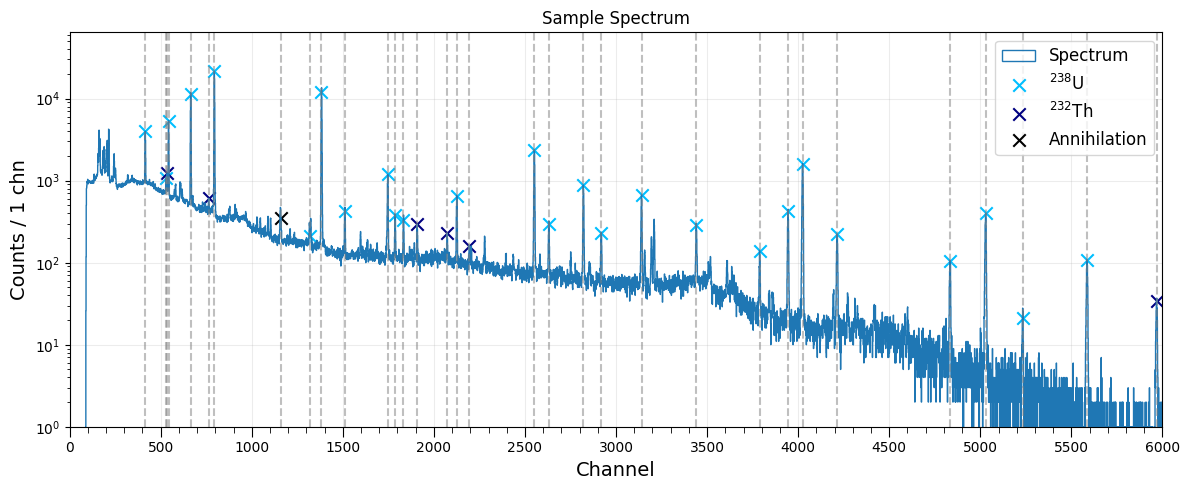

In [132]:

plt.figure(figsize=(12, 5))

dx = 500
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=7, labelsize=10)
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)

# Istogramma dello spettrot
chn = np.arange(len(spectrum_U))
bins = np.linspace(min(chn), max(chn), len(chn)+1)
counts, bin_edge, _ = plt.hist(
    chn,
    bins=bins,
    weights=spectrum_U,
    histtype='step',
    label='Spectrum'
)

db = bin_edge[1] - bin_edge[0]

# Flag per visualizzare etichette in legenda solo una volta
plotted_U = False
plotted_Th = False
plotted_ann = False

# Picchi 238U
for ch in E_chn_U:
    ch_idx = int(round(ch))
    if 0 <= ch_idx < len(spectrum_U):
        y = spectrum_U[ch_idx]
        plt.axvline(x=ch, color='grey', linestyle='--', alpha=0.5)
        plt.scatter(ch, y, color='deepskyblue', marker='x', s=80,
                    label=r'$^{238}$U' if not plotted_U else "")
        plotted_U = True

# Picchi 232Th
for ch in E_chn_th:
    ch_idx = int(round(ch))
    if 0 <= ch_idx < len(spectrum_U):
        y = spectrum_U[ch_idx]
        plt.axvline(x=ch, color='grey', linestyle='--', alpha=0.5)
        plt.scatter(ch, y, color='navy', marker='x', s=80,
                    label=r'$^{232}$Th' if not plotted_Th else "")
        plotted_Th = True




ch_ann = 1160
ch_idx = np.searchsorted(bin_edge, ch_ann) - 1
if 0 <= ch_idx < len(counts):
    y = counts[ch_idx]
    plt.axvline(x=ch_ann, color='grey', linestyle='--', alpha=0.5)
    plt.scatter(ch_ann, y, color='black', marker='x', s=80, label='Annihilation')

# Labels e stile grafico
plt.xlabel('Channel', size=14)
plt.ylabel(f'Counts / {db:.0f} chn', size=14)
plt.title('Sample Spectrum')
plt.xlim(0, 6000)
plt.ylim(1, max(spectrum_U)*3)
plt.yscale('log')
plt.grid(alpha=0.24)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig("new image/238U_channel", dpi=300, bbox_inches='tight')
plt.show()


## len(E_kev_tot )

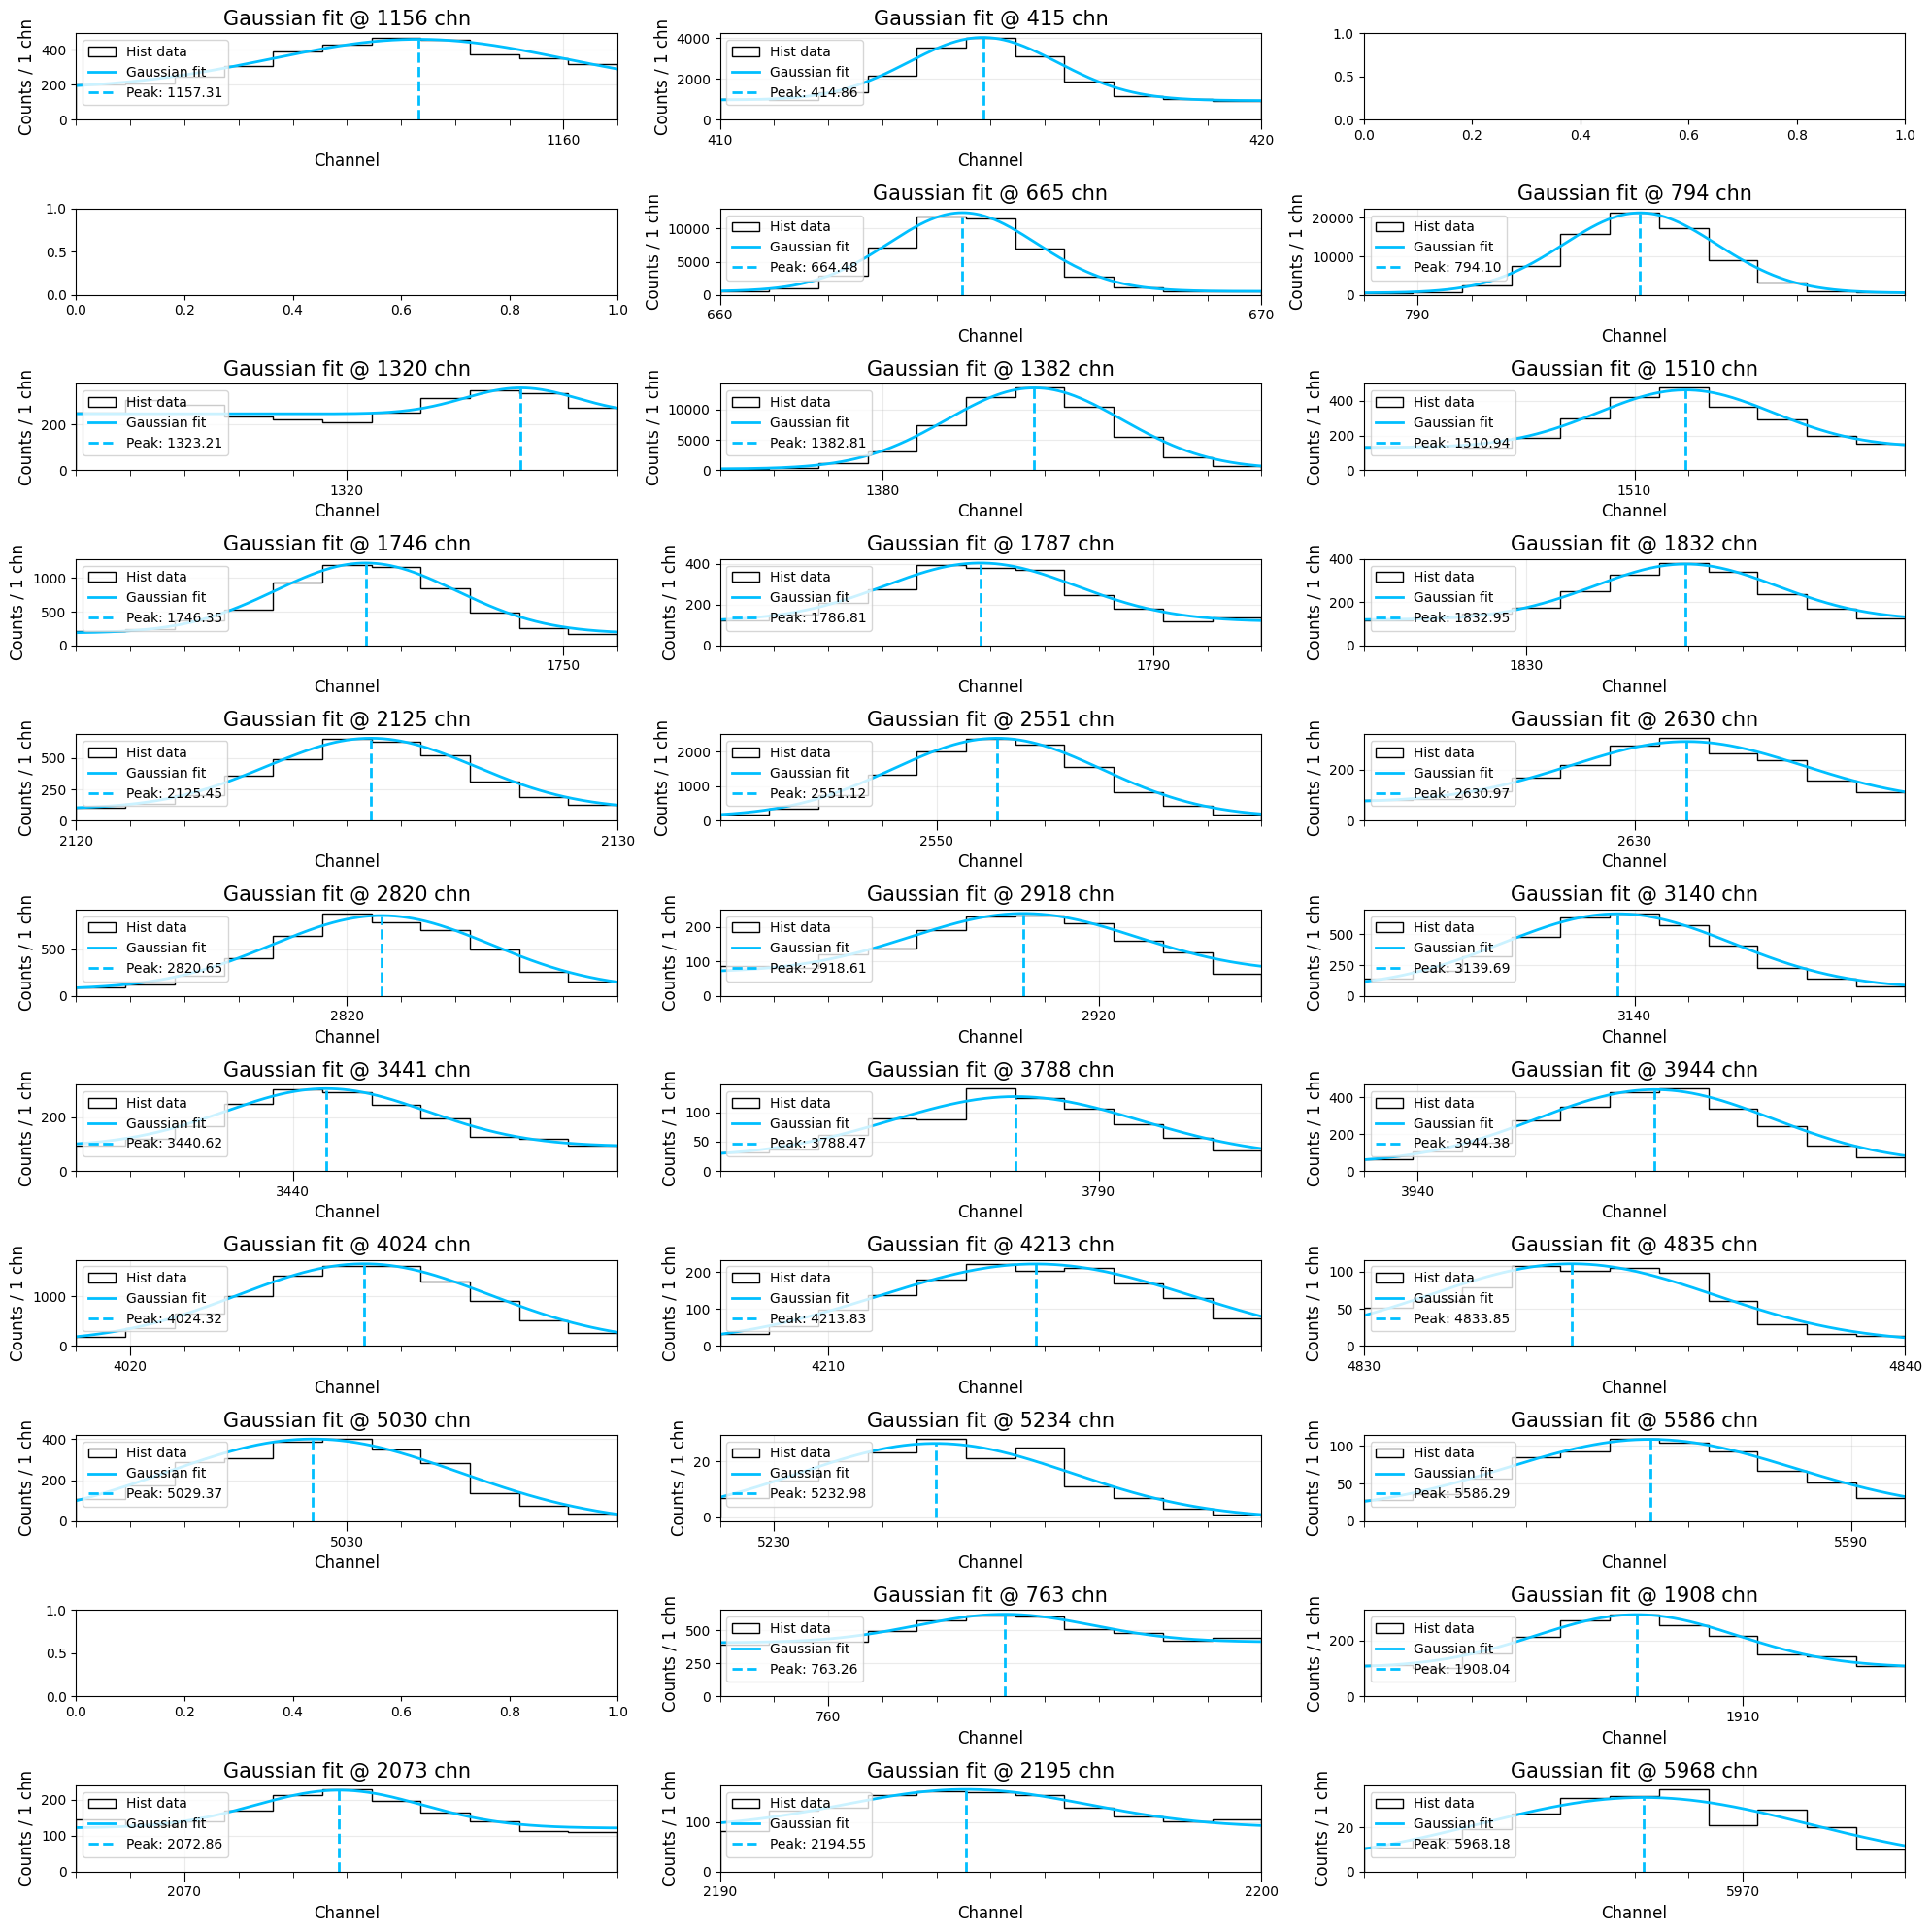

In [133]:
fig, axes = plt.subplots(11, 3, figsize=(20, 20))  # 10 subplot totali

popts_U = []
err_U = []

axes = axes.flatten()  # Rende la matrice 2D in un array 1D per iterare più facilmente

for i, e in enumerate(E_chn_tot):
    if e < 515 or e > 560:
        #print(i)
        ax = axes[i]
        if e == 528.9:
            dx = 3
        elif e == E_chn_tot[-1]:
            dx = 5
        else:
            dx = 5
        popt, err, _ = fit_func(spectrum_U, e, dx=dx, ax=ax)
        popts_U.append(popt)
        err_U.append(err)

# Rimuove i subplot vuoti
for j in range(len(E_chn_tot), len(axes)):
    fig.delaxes(axes[j])

popts_U = np.vstack(popts_U)
err_U = np.vstack(err_U)

plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()


In [134]:
def triple_gauss_offset(x,
                        A1, mu1, sigma1,
                        A2, mu2, sigma2,
                        A3, mu3, sigma3,
                        slope, offset):
    return (offset + slope *x +
            A1 * np.exp(- (x - mu1)**2 / (2*sigma1**2)) +
            A2 * np.exp(- (x - mu2)**2 / (2*sigma2**2)) +
            A3 * np.exp(- (x - mu3)**2 / (2*sigma3**2)) )



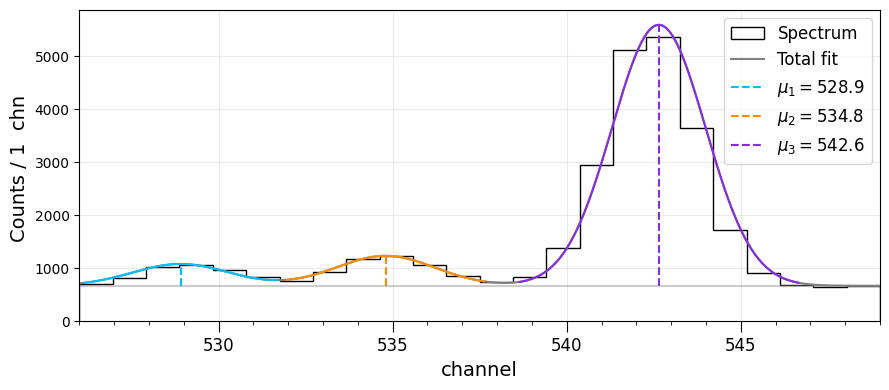

In [135]:
chn = np.arange(len(spectrum_U))

mask_2gauss = (chn > 525) & (chn < 550)

chn_2g = chn[mask_2gauss]
spectrum_2g = spectrum_U[mask_2gauss] 
plt.figure(figsize=(9, 4))

# Configura assi
dx = 5
dy = 1
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=8, labelsize=12
              )
ax.tick_params(axis='x', which='minor', length=3, labelsize=0)

# Fit tripla gaussiana + offset
p0 = [1000, 525, 0.5, 
      1000, 535, 0.5,
      2000, 543, 0.5,
      0, 100]

bounds = ([0, 500, 0,
           0, 500, 0,
           0, 500, 0,
           0, 0],
          [10000, 600,5,
           10000, 600, 5,
           10000, 600, 5,
           10000000, 100000000])

popt, pcov = curve_fit(triple_gauss_offset, chn_2g, spectrum_2g, p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))

# Estrai parametri
A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, slope, offset = popt
perr = np.sqrt(np.diag(pcov))

# Istogramma
bins = np.linspace(min(chn_2g), max(chn_2g), len(chn_2g) + 1)
counts, bin_edge, _ = plt.hist(chn_2g, bins=bins, weights=spectrum_2g,
                               histtype='step', color = 'black', label='Spectrum')
db = bin_edge[1] - bin_edge[0]

# Asse x continuo per la curva
x = np.linspace(min(chn_2g), max(chn_2g), 1000)

# Curva totale
plt.plot(x, triple_gauss_offset(x, *popt), label='Total fit', color = 'grey',linewidth=1.5)

# Singole gaussiane (fasce ±2σ)
x1 = x[(x > mu1 - 2 * sigma1) & (x < mu1 + 2 * sigma1)]
plt.plot(x1, triple_gauss_offset(x1, *popt),color = 'deepskyblue')
plt.vlines(mu1,  offset, triple_gauss_offset(mu1, *popt), color = 'deepskyblue', ls = '--' , label=rf'$\mu_1 = {mu1:.1f}$')



x2 = x[(x > mu2 - 2 * sigma2) & (x < mu2 + 2 * sigma2)]
plt.plot(x2, triple_gauss_offset(x2, *popt), color = 'darkorange')
plt.vlines(mu2,  offset, triple_gauss_offset(mu2, *popt), color = 'darkorange', ls = '--' , label=rf'$\mu_2 = {mu2:.1f} $')


x3 = x[(x > mu3 - 3 * sigma3) & (x < mu3 + 3 * sigma3)]
plt.plot(x3, triple_gauss_offset(x3, *popt), color = 'blueviolet')
plt.vlines(mu3,  offset, triple_gauss_offset(mu3, *popt), color = 'blueviolet', ls = '--' , label=rf'$\mu_3 = {mu3:.1f} $')



plt.hlines(offset, min(chn_2g), max(chn_2g), color = 'grey', alpha = 0.4 )
# Layout finale
plt.xlim(min(chn_2g), max(chn_2g))
plt.xlabel('channel', size = 14)
plt.ylabel(f'Counts / {db:.0f}  chn ', size = 14)
#plt.ylim(0, 200000)
plt.grid(alpha=0.25)
plt.legend(fontsize = 12)
plt.tight_layout()

plt.savefig("new image/ 235-245_chn_peak", dpi=300, bbox_inches='tight')

In [136]:
popt

array([4.11132646e+02, 5.28905604e+02, 1.37956236e+00, 5.64474185e+02,
       5.34794783e+02, 1.42227282e+00, 4.92146011e+03, 5.42646257e+02,
       1.34243710e+00, 4.86513427e-08, 6.73727546e+02])

In [137]:
perr

array([5.08478288e+01, 1.23426120e-01, 2.05264967e-01, 4.13264267e+01,
       8.31266150e-02, 1.14339142e-01, 3.16545051e+01, 9.43688871e-03,
       1.13643146e-02, 2.85792368e+00, 1.55790771e+03])

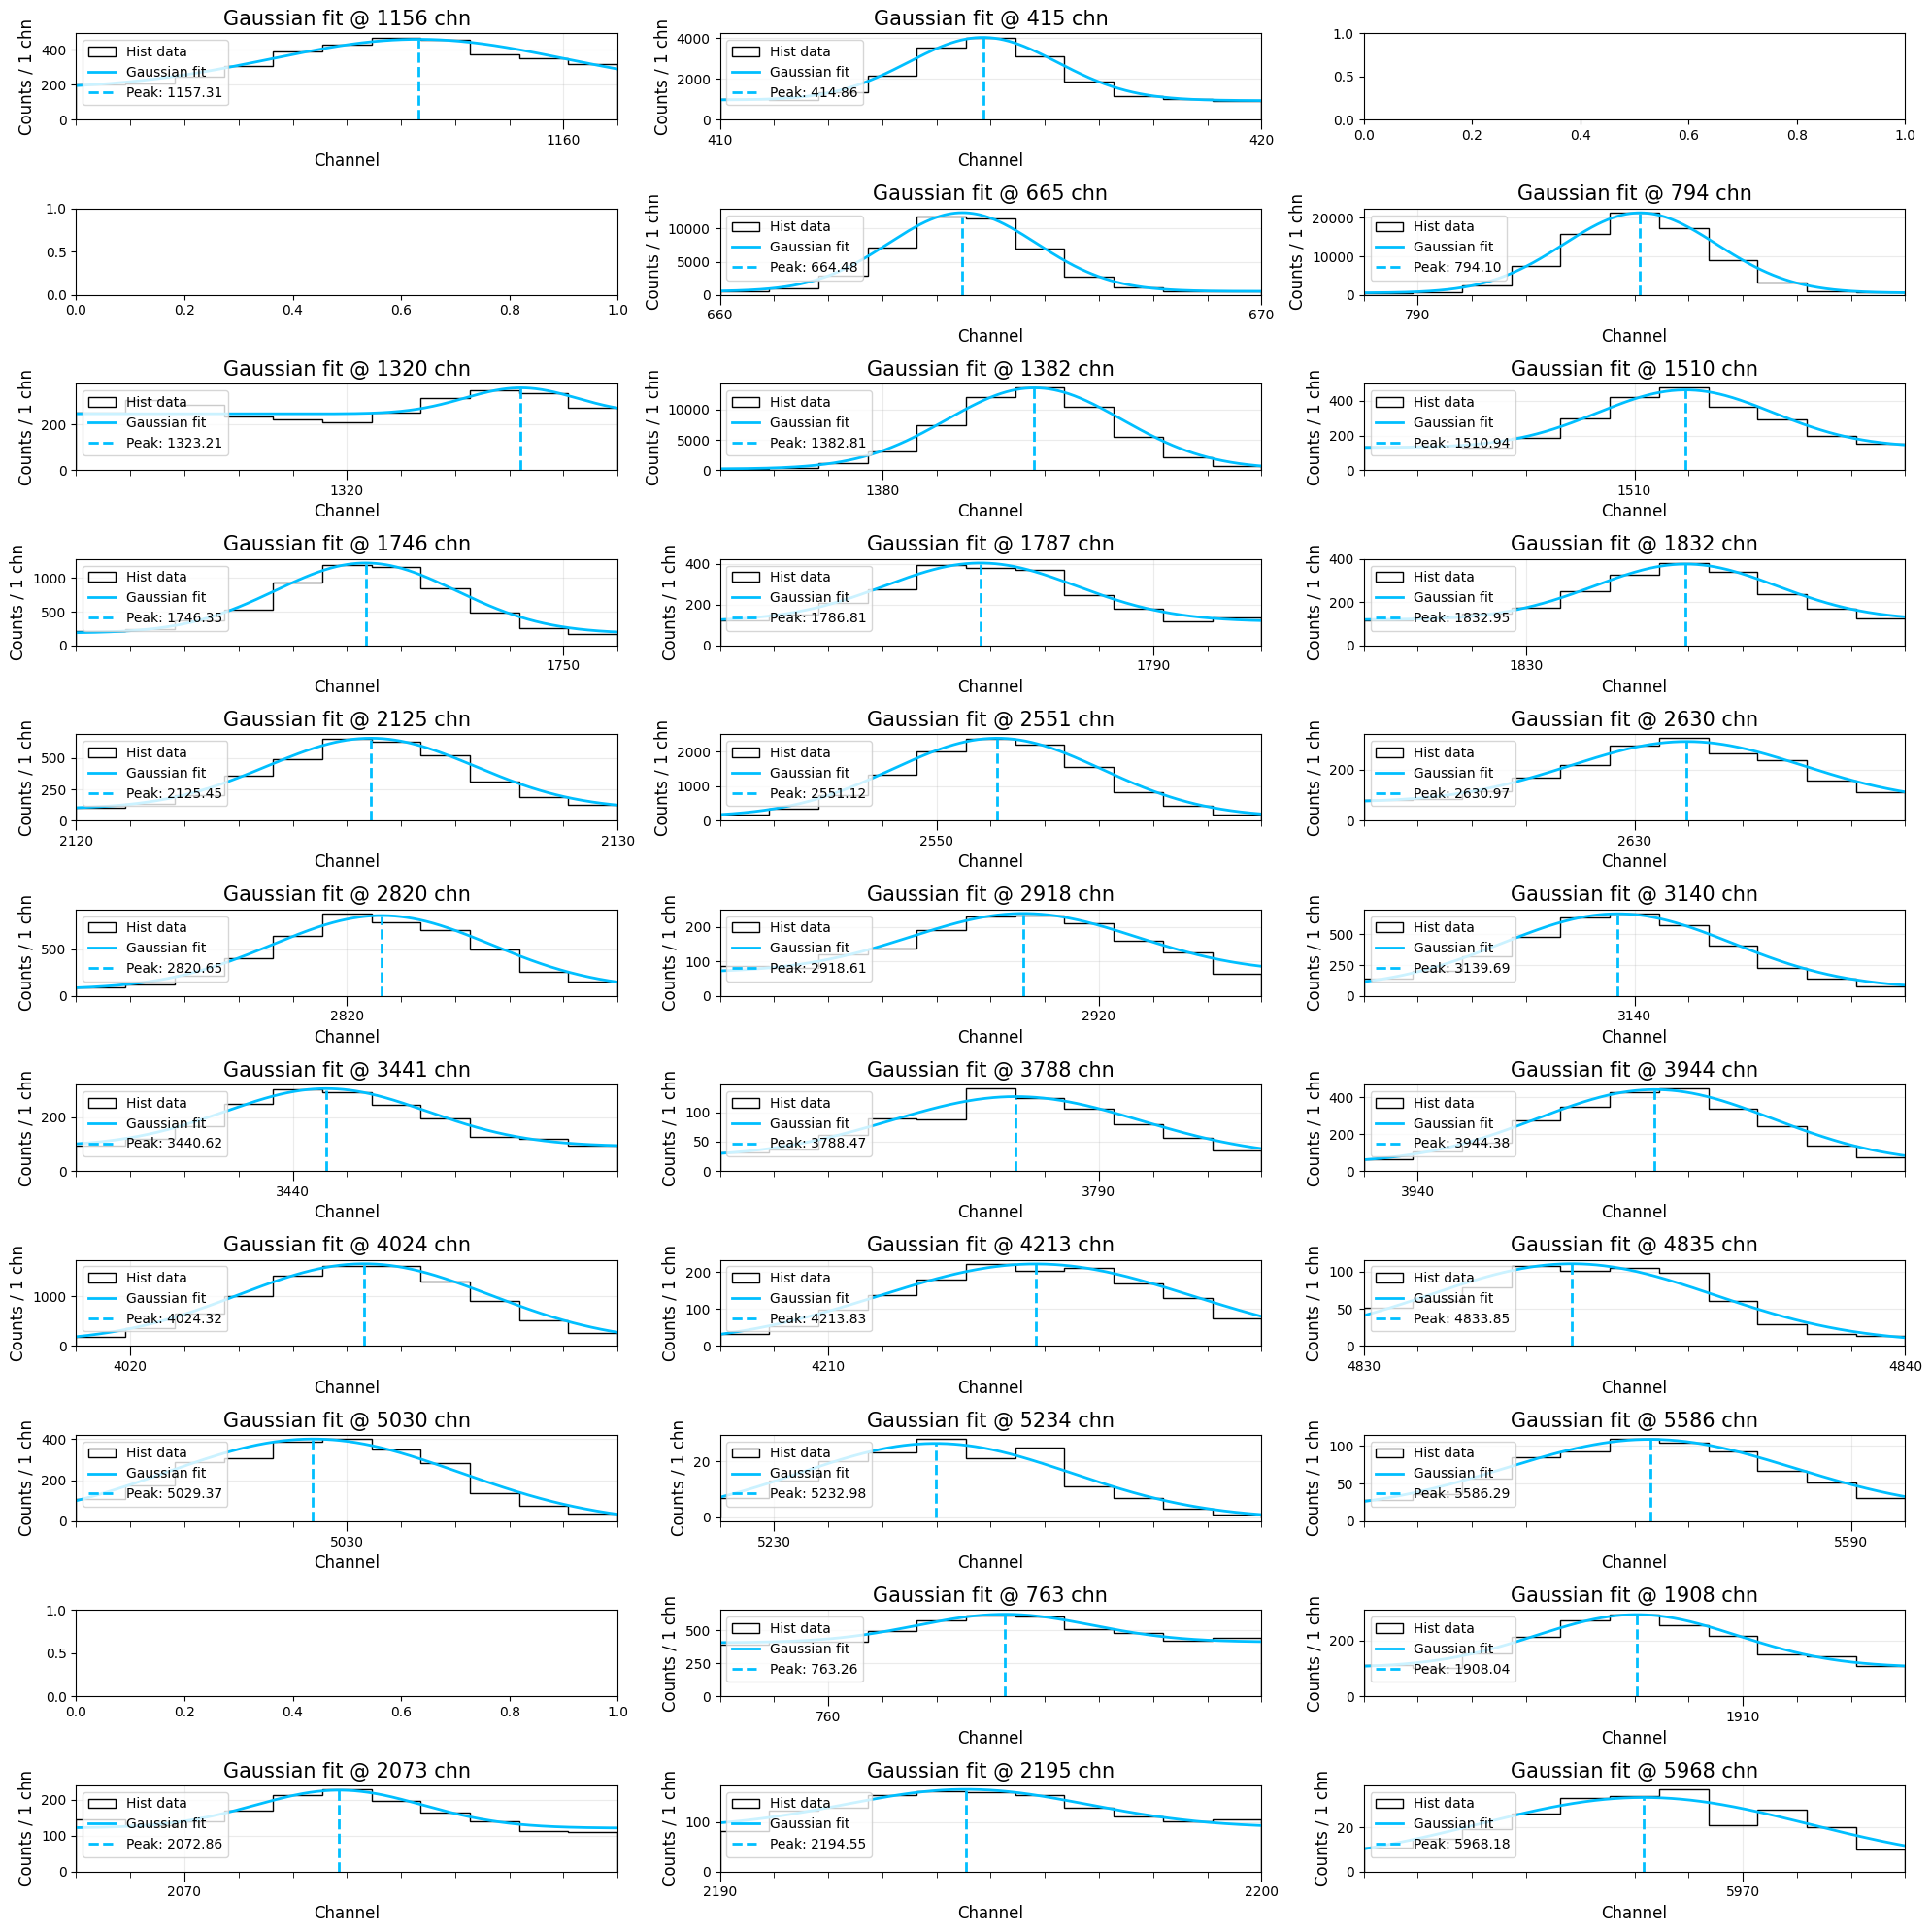

Valori mu finali: [1157.31275833  414.85897102  528.90560402  534.79478342  664.48015136
  794.10442021 1323.21120723 1382.80787539 1510.94236541 1746.34893574
 1786.81237417 1832.94792658 2125.44661236 2551.12089646 2630.96508093
 2820.64528666 2918.60768606 3139.68690692 3440.61834653 3788.4651888
 3944.37521547 4024.32105243 4213.83275452 4833.84695122 5029.37346247
 5232.98019063 5586.28887602  542.64625687  763.25830199 1908.03922361
 2072.85932928 2194.54769699 5968.1752783 ]
Errori mu finali: [0.45689597 0.01875721 0.12342612 0.08312661 0.01116716 0.00737971
 0.40352333 0.00825641 0.09809569 0.07975812 0.12173537 0.0725441
 0.05479419 0.02944827 0.12767473 0.08271676 0.23448695 0.08045811
 0.09949803 0.25893848 0.08654796 0.03582149 0.21849968 0.50957562
 0.25644943 0.36800564 0.14648629 0.00943689 0.1715701  0.15452833
 0.18440646 0.38226965 0.66714971]


In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assicurati che triple_gauss_offset, fit_func, chn_2g, spectrum_2g, spectrum_U, E_chn_tot siano definiti

fig, axes = plt.subplots(11, 3, figsize=(20, 20))
axes = axes.flatten()

mu_U = []
err_U = []

# Fit triplo centrale
p0 = [1000, 525, 0.5, 
      1000, 535, 0.5,
      2000, 543, 0.5,
      0, 100]

bounds = ([0, 500, 0,
           0, 500, 0,
           0, 500, 0,
           0, 0],
          [10000, 600,5,
           10000, 600, 5,
           10000, 600, 5,
           10000000, 100000000])

popt, pcov = curve_fit(triple_gauss_offset, chn_2g, spectrum_2g, p0=p0, bounds=bounds)
perr = np.sqrt(np.diag(pcov))
mu_vals = [popt[1], popt[4], popt[7]]
mu_errs = [perr[1], perr[4], perr[7]]
#mu_vals = [popt[1],popt[7]]
#mu_errs = [perr[1],perr[7]]
mu_err_pairs = sorted(zip(mu_vals, mu_errs), key=lambda x: x[0])
sorted_mu_vals, sorted_mu_errs = zip(*mu_err_pairs)

# Plot dei picchi
for i, e in enumerate(E_chn_tot):
    ax = axes[i]
    if 525 <= e <= 555:
        peaks_in_range = [x for x in E_chn_tot if 525 <= x <= 555]
        idx_in_range = peaks_in_range.index(e)
        mu_U.append(sorted_mu_vals[idx_in_range])
        err_U.append(sorted_mu_errs[idx_in_range])
    else:
        dx = 2 if e == 535.2102857142858 else 5
        popt_single, err_single, _ = fit_func(spectrum_U, e, dx=dx, ax=ax)
        mu_U.append(popt_single[1])
        err_U.append(err_single[1])

# Rimuove **tutti** gli assi rimasti non usati (compresi in mezzo)
for ax in axes[len(E_chn_tot):]:
    ax.remove()

# Ridisegna layout
plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()

mu_U = np.array(mu_U)
err_U = np.array(err_U)

print("Valori mu finali:", mu_U)
print("Errori mu finali:", err_U)



 a: 0.437, on b: 4.53
Uncertainty on a: 0.000148, on b: 0.44


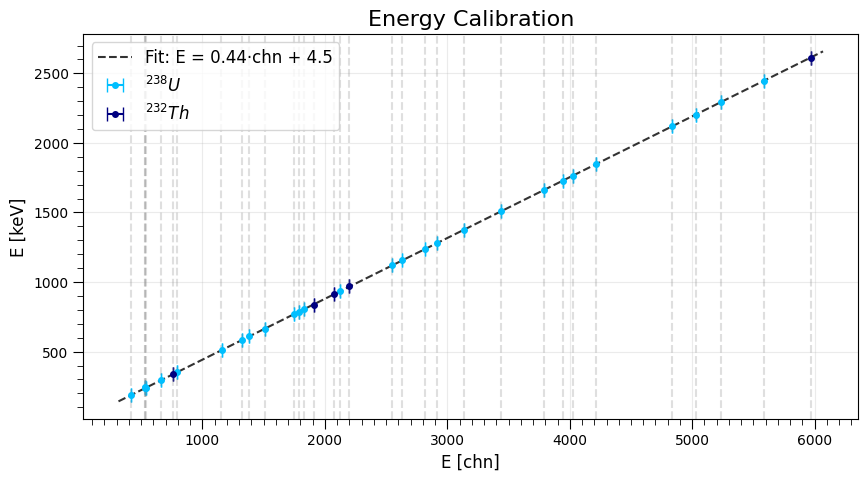

In [139]:
mu_chn = mu_U
mu_chn_err = err_U
plt.figure(figsize=(10, 5))




dx = 1000
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

dx = 500
dy = 100
ax = plt.gca()
ax.yaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.yaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='y', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='y', which='minor', length=4, labelsize=0)   # tacche piccole, no numero







plt.errorbar( mu_chn[:-5],E_kev_tot[:-5], xerr=mu_chn_err[:-5], fmt='o', color = 'deepskyblue', markersize = 4, capsize=5, label=r'$^{238}U$')
plt.errorbar( mu_chn[-5:],E_kev_tot[-5:], xerr=mu_chn_err[-5:], fmt='o', color = 'navy',markersize = 4,  capsize=5, label=r'$^{232}Th$')

p0 = [0.4, 0]
popt, pcov = curve_fit(k_calibration, mu_chn, E_kev_tot, p0=p0 )
# Incertezze
perr_U = np.sqrt(np.diag(pcov))
print(f" a: {popt[0]:.3f}, on b: {popt[1]:.2f}")
print(f"Uncertainty on a: {perr_U[0]:.6f}, on b: {perr_U[1]:.2f}")
a = popt[0]
b = popt[1]

# Plot
x_fit = np.linspace(min(mu_chn)-100, max(mu_chn)+100, 500)
y_fit = k_calibration(x_fit, *popt)
plt.plot(x_fit, y_fit, label=f"Fit: E = {popt[0]:.2f}·chn + {popt[1]:.1f}", color='black', ls = '--', alpha = 0.8)
for chn in E_chn_tot:
    plt.axvline(x=chn, color='gray', linestyle='--', alpha=0.25)
plt.legend(fontsize = 12, loc = 'upper left' )
plt.xlabel('E [chn]', size = 12)
plt.ylabel('E [keV]', size = 12)
plt.title('Energy Calibration', size = 16)
plt.grid(alpha =0.25)
plt.savefig("new image/E_ene_cal_sample", dpi=300, bbox_inches='tight')

In [140]:
channels = np.arange(len(spectrum_U))         # x originale
energies = a * channels + b
#b_prime = 6
#energies = a * channels + b_prime

In [141]:
print('b', b)
print('b bkg', b_bkg)
print('a', perr_U[0])
print('a bkg', a_bkg)

b 4.532351599600002
b bkg 4.679438014857306
a 0.00014796849233460722
a bkg 0.43738478665371805


In [159]:
mask = (energies > 60) & (energies < 3000)
spectr_3Mev = spectrum_U[mask]

print(np.sum(spectr_3Mev))
print('attività grezza', np.sum(spectr_3Mev)/(t_live_u), 'cps')

1225100
attività grezza 2038.4359400998337 cps


In [142]:
perr

array([5.08478288e+01, 1.23426120e-01, 2.05264967e-01, 4.13264267e+01,
       8.31266150e-02, 1.14339142e-01, 3.16545051e+01, 9.43688871e-03,
       1.13643146e-02, 2.85792368e+00, 1.55790771e+03])

[4.19262282e+02 2.35834354e+02 6.56143628e-01 5.80528774e+02
 2.38432238e+02 6.38109915e-01 4.93449194e+03 2.41857345e+02
 5.90125255e-01 4.72808842e-21 6.55546011e+02]


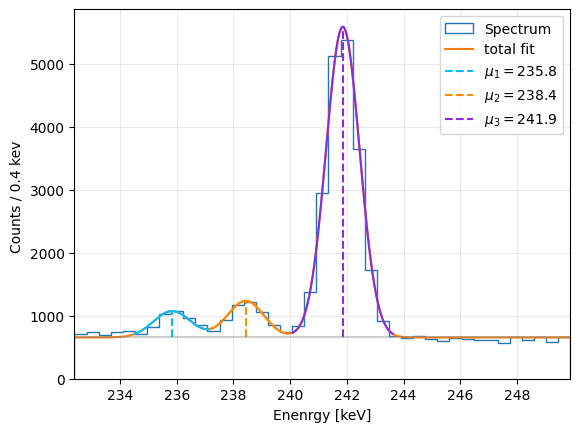

In [143]:
mask_new = (energies > 232) & (energies < 250)
ene_2g = energies[mask_new]
spectrum_2g = spectrum_U[mask_new]
bins =  np.linspace(min(ene_2g), max(ene_2g), len(ene_2g) +1 )
counts, bin_edge, _ = plt.hist(ene_2g, bins = bins, weights = spectrum_2g,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]

# Prima fai il fit triplo per i picchi centrali (una sola volta)
p0 = [1000, 236, 0.5, 
      1000, 238, 0.5,
      2000, 242, 0.5,
      0, 100]

bounds = ([0, 0.95*236, 0,
           0, 0.95*238, 0,
           0, 0.95*242, 0,
          0,  0],
          [10000, 1.05*236, 1,
           10000, 1.05*238, 1,
           10000, 1.1*242, 1,
           100, 1000])

popt, pcov = curve_fit(triple_gauss_offset, ene_2g, spectrum_2g, p0=p0, bounds = bounds)
perr = np.sqrt(np.diag(pcov))
A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, slope, offset = popt
x  = np.linspace(min(ene_2g), max(ene_2g), 1000)
plt.plot(x, triple_gauss_offset(x, *popt), label = 'total fit')
# Singole gaussiane (fasce ±2σ)
x1 = x[(x > mu1 - 2 * sigma1) & (x < mu1 + 2 * sigma1)]
plt.plot(x1, triple_gauss_offset(x1, *popt),color = 'deepskyblue')
plt.vlines(mu1,  offset, triple_gauss_offset(mu1, *popt), color = 'deepskyblue', ls = '--' , label=rf'$\mu_1 = {mu1:.1f}$')



x2 = x[(x > mu2 - 2 * sigma2) & (x < mu2 + 2 * sigma2)]
plt.plot(x2, triple_gauss_offset(x2, *popt), color = 'darkorange')
plt.vlines(mu2,  offset, triple_gauss_offset(mu2, *popt), color = 'darkorange', ls = '--' , label=rf'$\mu_2 = {mu2:.1f} $')


x3 = x[(x > mu3 - 3 * sigma3) & (x < mu3 + 3 * sigma3)]
plt.plot(x3, triple_gauss_offset(x3, *popt), color = 'blueviolet')

plt.vlines(mu3,  offset, triple_gauss_offset(mu3, *popt), color = 'blueviolet', ls = '--' , label=rf'$\mu_3 = {mu3:.1f} $')


plt.hlines(offset, min(ene_2g), max(ene_2g), color = 'grey', alpha = 0.4 )
# Layout finale
plt.xlim(min(ene_2g), max(ene_2g))
plt.grid(alpha = 0.25)
plt.xlabel('Enenrgy [keV]')
plt.ylabel(f'Counts / {db:.1f} kev ')
plt.legend()
print(popt)

In [144]:
perr

array([3.90542350e+01, 6.84099690e-02, 7.74754267e-02, 3.90069413e+01,
       4.84215497e-02, 5.22757348e-02, 3.88356746e+01, 5.25814913e-03,
       5.54831380e-03, 1.79283754e+00, 4.36738515e+02])

In [145]:
1.13/7.43

0.15208613728129206

In [146]:
5.69971131e+02/4.92542446e+03

0.11572020556376576

[4.19262282e+02 2.35834354e+02 6.56143628e-01 5.80528774e+02
 2.38432238e+02 6.38109915e-01 4.93449194e+03 2.41857345e+02
 5.90125255e-01 4.72808842e-21 6.55546011e+02]
235.83435443002685 238.43223757030776 241.85734527314457
sigma errs [np.float64(0.07747542670805765), np.float64(0.05227573476228806), np.float64(0.005548313796571658)]


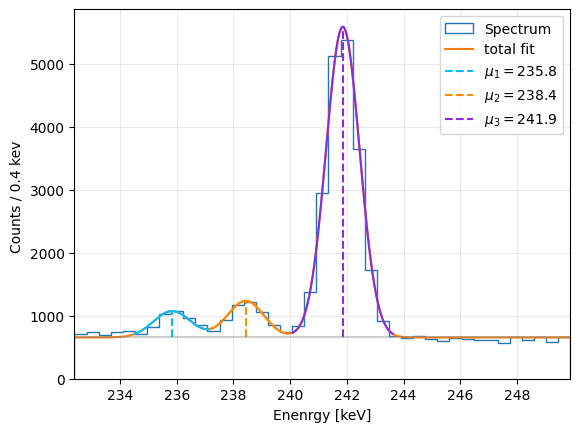

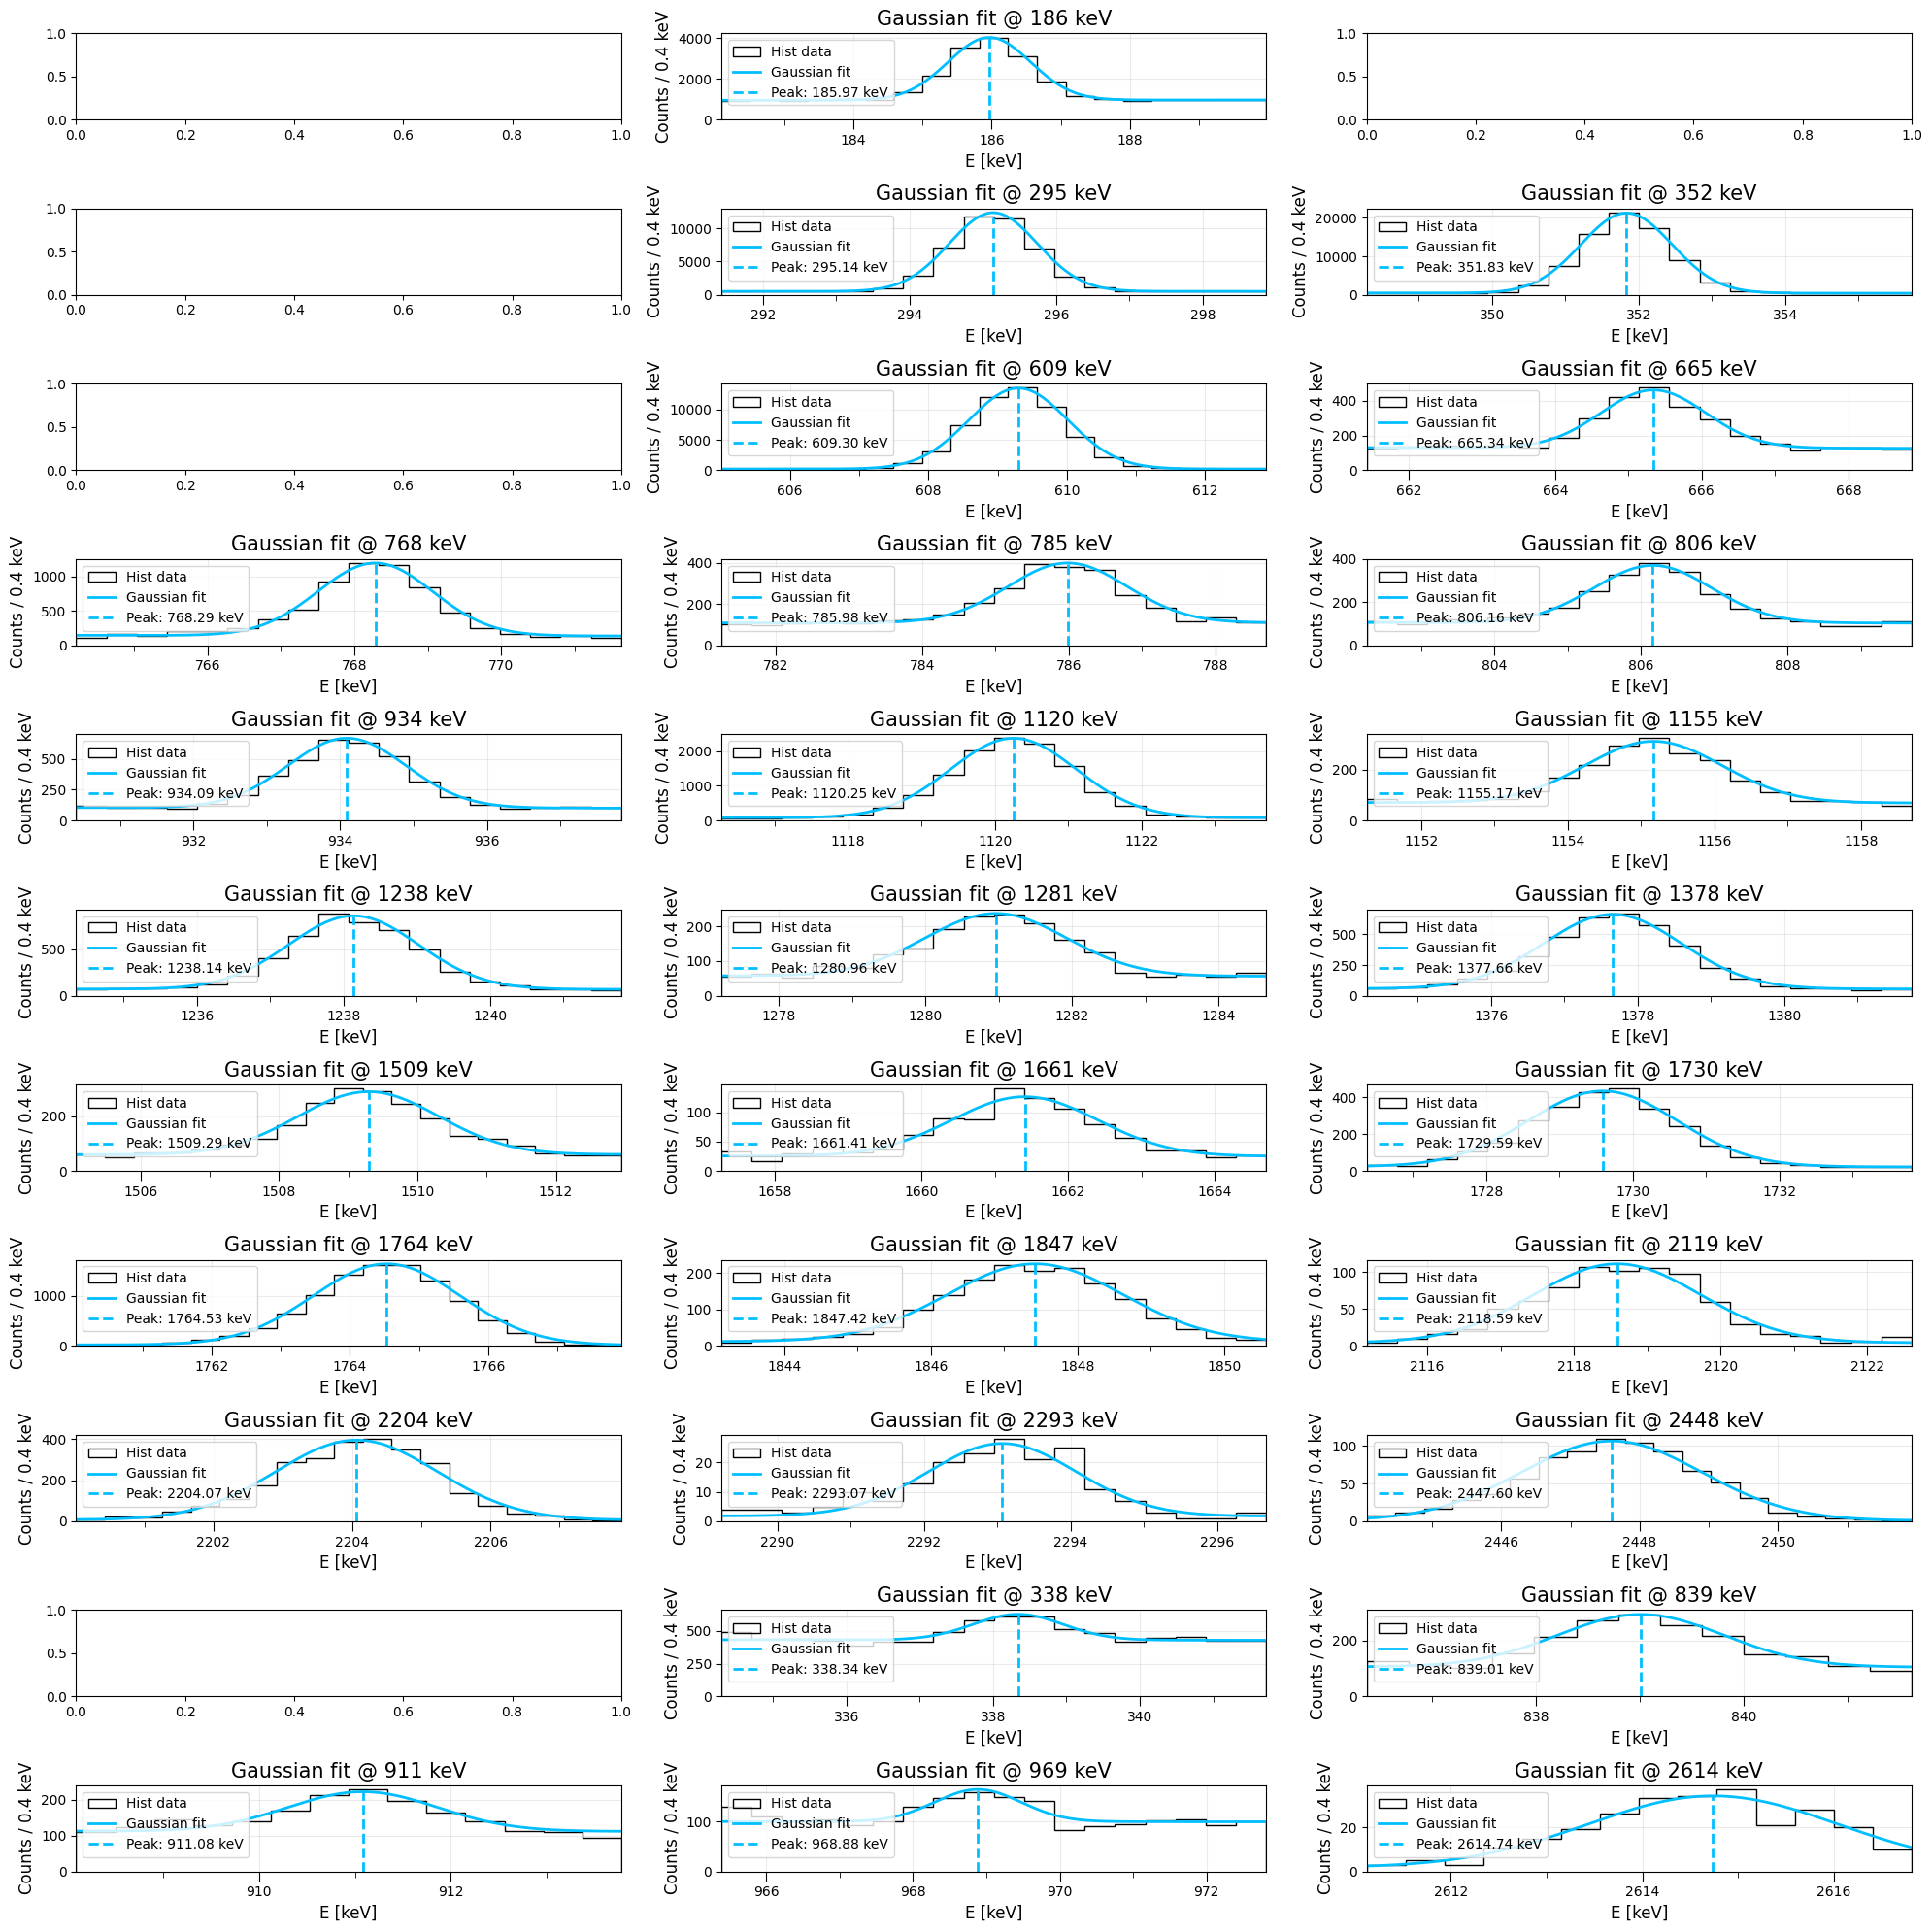

In [147]:
mu_U_kev = []
err_mu_U_kev = []
sigma_U_kev = []
err_sigma_U_kev = []

# Fit triplo
mask_new = (energies > 232) & (energies < 250)
ene_2g = energies[mask_new]
spectrum_2g = spectrum_U[mask_new]
bins =  np.linspace(min(ene_2g), max(ene_2g), len(ene_2g) +1 )
counts, bin_edge, _ = plt.hist(ene_2g, bins = bins, weights = spectrum_2g,  histtype='step', label = 'Spectrum' )
db = bin_edge[1]-bin_edge[0]

# Prima fai il fit triplo per i picchi centrali (una sola volta)
p0 = [1000, 236, 0.5, 
      1000, 238, 0.5,
      2000, 242, 0.5,
      0, 100]

bounds = ([0, 0.95*236, 0,
           0, 0.95*238, 0,
           0, 0.95*242, 0,
          0,  0],
          [10000, 1.05*236, 1,
           10000, 1.05*238, 1,
           10000, 1.1*242, 1,
           100, 1000])

popt, pcov = curve_fit(triple_gauss_offset, ene_2g, spectrum_2g, p0=p0, bounds = bounds)
perr = np.sqrt(np.diag(pcov))
A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, slope, offset = popt
dA1, dmu1, dsigma1, dA2, dmu2, dsigma2, dA3, dmu3, dsigma3, dslope, doffset = perr
x  = np.linspace(min(ene_2g), max(ene_2g), 1000)
plt.plot(x, triple_gauss_offset(x, *popt), label = 'total fit')
# Singole gaussiane (fasce ±2σ)
x1 = x[(x > mu1 - 2 * sigma1) & (x < mu1 + 2 * sigma1)]
plt.plot(x1, triple_gauss_offset(x1, *popt),color = 'deepskyblue')
plt.vlines(mu1,  offset, triple_gauss_offset(mu1, *popt), color = 'deepskyblue', ls = '--' , label=rf'$\mu_1 = {mu1:.1f}$')



x2 = x[(x > mu2 - 2 * sigma2) & (x < mu2 + 2 * sigma2)]
plt.plot(x2, triple_gauss_offset(x2, *popt), color = 'darkorange')
plt.vlines(mu2,  offset, triple_gauss_offset(mu2, *popt), color = 'darkorange', ls = '--' , label=rf'$\mu_2 = {mu2:.1f} $')


x3 = x[(x > mu3 - 3 * sigma3) & (x < mu3 + 3 * sigma3)]
plt.plot(x3, triple_gauss_offset(x3, *popt), color = 'blueviolet')

plt.vlines(mu3,  offset, triple_gauss_offset(mu3, *popt), color = 'blueviolet', ls = '--' , label=rf'$\mu_3 = {mu3:.1f} $')


plt.hlines(offset, min(ene_2g), max(ene_2g), color = 'grey', alpha = 0.4 )
# Layout finale
plt.xlim(min(ene_2g), max(ene_2g))
plt.grid(alpha = 0.25)
plt.xlabel('Enenrgy [keV]')
plt.ylabel(f'Counts / {db:.1f} kev ')
plt.legend()
print(popt)

# estrai e ordina mu e sigma con errori
mu_vals = [mu1,mu2, mu3]
print(mu1,mu2, mu3)
sigma_vals = [sigma1, sigma2, sigma3]
mu_errs =  [dmu1,dmu2, dmu3]
sigma_errs = [dsigma1, dsigma2, dsigma3]
#mu_vals = [popt[1], popt[7]]
#sigma_vals = [popt[2], popt[8]]
#mu_errs = [perr[1],  perr[7]]
#sigma_errs = [perr[2], perr[8]]
print('sigma errs', sigma_errs)
mu_err_pairs = sorted(zip(mu_vals, mu_errs, sigma_vals, sigma_errs), key=lambda x: x[0])
sorted_mu_vals, sorted_mu_errs, sorted_sigma_vals, sorted_sigma_errs = zip(*mu_err_pairs)
fig, axes = plt.subplots(11, 3, figsize=(20, 20))  # 27 subplot
axes = axes.flatten()
# ciclo sui picchi
for i, e in enumerate(E_kev_tot):
    ax = axes[i]
    
    if 220 <= e <= 250:
        peaks_in_range = [x for x in E_kev_tot if 220 <= x <= 250]
        idx_in_range = peaks_in_range.index(e)
        
        mu_U_kev.append(sorted_mu_vals[idx_in_range])
        err_mu_U_kev.append(sorted_mu_errs[idx_in_range])
        
        sigma_U_kev.append(sorted_sigma_vals[idx_in_range])
        err_sigma_U_kev.append(sorted_sigma_errs[idx_in_range])
        
    else:
        if e == E_kev_tot[-1]:
            dx = 3
        elif e ==  583.5:
            dx = 4
        elif e ==  338.5:
            dx = 4
        elif e == 837.8:
            e = e+1
            dx = 3
        elif e ==911.204:
            dx = 3
        elif e ==580.13:
            continue
        elif e ==511:
            continue
        else:
            dx = 4
            #print('mao')
        popt_single, err_single, _ = fit_func(spectrum_U, e, dx=dx, kev=True, energies=energies, ax=ax)
        
        mu_U_kev.append(popt_single[1])
        err_mu_U_kev.append(err_single[1])
        sigma_U_kev.append(popt_single[2])        # sigma
        err_sigma_U_kev.append(err_single[2])     # errore sigma


plt.tight_layout()
plt.savefig("HPGe images/238U/U_chn_peak", dpi=300, bbox_inches='tight')
plt.show()

mu_U_kev = np.array(mu_U_kev)
err_mu_U_kev = np.array(err_mu_U_kev)
sigma_U_kev = np.array(sigma_U_kev)
err_sigma_U_kev = np.array(err_sigma_U_kev)



In [148]:
E_kev_tot

array([ 511.   ,  185.712,  236.   ,  242.   ,  295.224,  351.932,
        580.13 ,  609.312,  665.45 ,  768.356,  785.356,  806.174,
        934.061, 1120.287, 1155.19 , 1238.11 , 1280.96 , 1377.669,
       1509.228, 1661.28 , 1729.595, 1764.494, 1847.42 , 2118.55 ,
       2204.   , 2293.4  , 2447.86 ,  238.632,  338.32 ,  837.8  ,
        911.204,  968.971, 2614.   ])

In [149]:

def reorder_arr1(E_kev_tot, mu_kev):
    reordered = []
    used_indices = set()
    for val in mu_kev:
        # Trova indice in arr1 con valore più vicino a val e non ancora usato
        diffs = np.abs(E_kev_tot - val)
        for idx in np.argsort(diffs):
            if idx not in used_indices:
                used_indices.add(idx)
                reordered.append(E_kev_tot[idx])
                break
    return np.array(reordered)

In [150]:
mu_kev = reorder_arr1(E_kev_tot, mu_kev)

In [151]:
E_kev_tot

array([ 511.   ,  185.712,  236.   ,  242.   ,  295.224,  351.932,
        580.13 ,  609.312,  665.45 ,  768.356,  785.356,  806.174,
        934.061, 1120.287, 1155.19 , 1238.11 , 1280.96 , 1377.669,
       1509.228, 1661.28 , 1729.595, 1764.494, 1847.42 , 2118.55 ,
       2204.   , 2293.4  , 2447.86 ,  238.632,  338.32 ,  837.8  ,
        911.204,  968.971, 2614.   ])

In [152]:
mu_kev

array([ 238.632,  295.224,  338.32 ,  351.932,  580.13 ,  609.312,
        665.45 ,  911.204,  968.971, 1120.287, 1238.11 , 1377.669,
       1509.228, 1280.96 , 1661.28 , 1729.595, 1764.494, 2204.   ,
       2614.   ])

In [153]:
np.sort(mu_U_kev)[-5]

np.float64(2118.5891637770037)

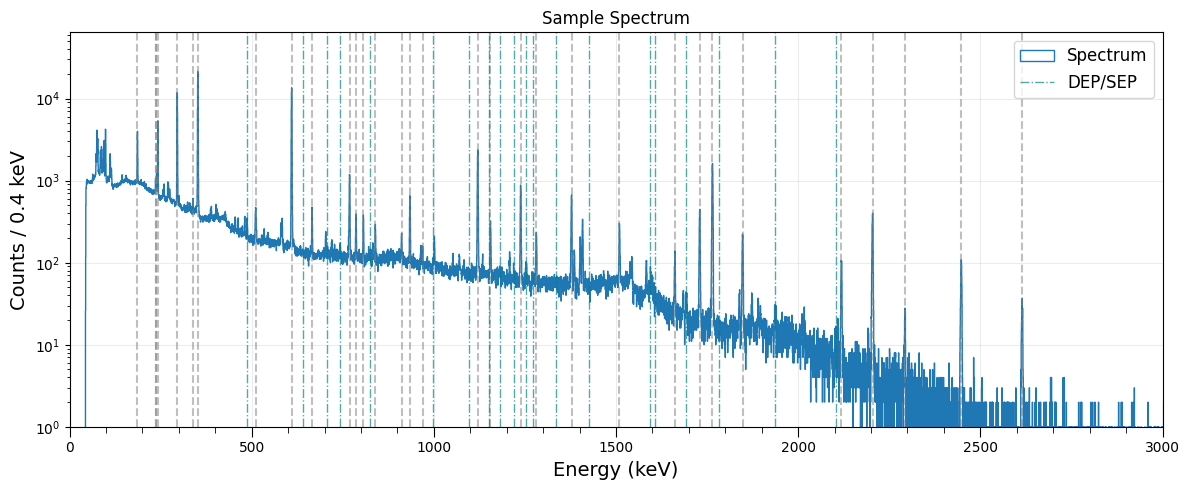

In [154]:

plt.figure(figsize=(12, 5))

dx = 500
dy = 100
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=7, labelsize=10)
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)

# Istogramma dello spettro
chn = np.arange(len(spectrum_U))
bins = np.linspace(min(energies), max(energies), len(energies)+1)
counts, bin_edge, _ = plt.hist(
    energies,
    bins=bins,
    weights=spectrum_U,
    histtype='step',
    label='Spectrum'
)

db = bin_edge[1] - bin_edge[0]

# Flag per visualizzare etichette in legenda solo una volta
plotted_U = False
plotted_Th = False

# Picchi 238U
for ch in mu_U_kev[:-6]:
    ch_idx = np.searchsorted(bin_edge, ch) 
    if 0 <= ch_idx < len(counts):
        y = counts[ch_idx]
        plt.axvline(x=ch, color='grey', linestyle='--', alpha=0.5)
        #plt.scatter(ch, y, color='deepskyblue', marker='x', s=80,
                    #label=r'$^{238}$U' if not plotted_U else "")
        plotted_U = True

# Picchi 232Th
for ch in mu_U_kev[-6:]:
    ch_idx = np.searchsorted(bin_edge, ch) - 1
    if 0 <= ch_idx < len(counts):
        y = counts[ch_idx]
        
        plt.axvline(x=ch, color='grey', linestyle='--', alpha=0.5)
        #plt.scatter(ch, y, color='navy', marker='x', s=80,
                    #label=r'$^{232}$Th' if not plotted_Th else "")
        plotted_Th = True

ch_ann = 511
ch_idx = np.searchsorted(bin_edge, ch_ann) - 1
if 0 <= ch_idx < len(counts):
    y = counts[ch_idx]
    plt.axvline(x=ch_ann, color='grey', linestyle='--', alpha=0.5)
    #plt.scatter(ch_ann, y, color='black', marker='x', s=80, label='Annihilation')


for i, v in enumerate(np.sort(mu_U_kev)):
    if v >= 1400:
        # Label only the first vertical line once
        label = 'DEP/SEP' if i == np.argmax(mu_U_kev) else None
        
        # DEP/SEP di 214-Bi 2204 keV
        plt.vlines(v-511, 1, np.max(spectrum_U)*100,  color = 'teal', lw = 1, ls = '-.',alpha = 0.68, label = label)
        plt.vlines(v-511-511, 1, np.max(spectrum_U)*100,  color = 'teal', lw = 1,ls = '-.', alpha = 0.68)


        

# Labels e stile grafico
plt.xlabel('Energy (keV)', size=14)
plt.ylabel(f'Counts / {db:.1f} keV', size=14)
plt.title('Sample Spectrum')
plt.xlim(0, 3000)
plt.ylim(1, max(counts)*3)

plt.xlim(0, 3000)
plt.yscale('log')
plt.grid(alpha=0.24)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("new image/238U_kev", dpi=300, bbox_inches='tight')
plt.show()


In [155]:
FWHM_errindex_anomalous = np.argmax(FWHM_err)
print("Indice del valore anomalo:", FWHM_errindex_anomalous)
print(mu_kev[FWHM_errindex_anomalous])
print(FWHM_err[FWHM_errindex_anomalous])
print(sigma[FWHM_errindex_anomalous])
print(sigma_err_kev[FWHM_errindex_anomalous])


Indice del valore anomalo: 6
665.45
0.0003138735630729533
0.8080188935498179
0.08819286527115423


In [156]:
mu_U_kev

array([ 185.96568971,  235.83435443,  238.43223757,  295.14130613,
        351.83333361,  609.30085937,  665.34173064,  768.28660339,
        785.98452061,  806.15875839,  934.09144933, 1120.25386758,
       1155.17338672, 1238.13928347, 1280.95903549, 1377.66072998,
       1509.29395853, 1661.40734987, 1729.5916677 , 1764.53172452,
       1847.42233439, 2118.58916378, 2204.06761637, 2293.06794161,
       2447.59560145,  241.85734527,  338.34085092,  839.00876192,
        911.0822527 ,  968.88388266, 2614.73643562])

incertezza grandi solo 3 punti del fit
paramters: [7.37270035e-02 6.96519264e-25]
Errori: [3.42200968e-03 3.93128223e+01]


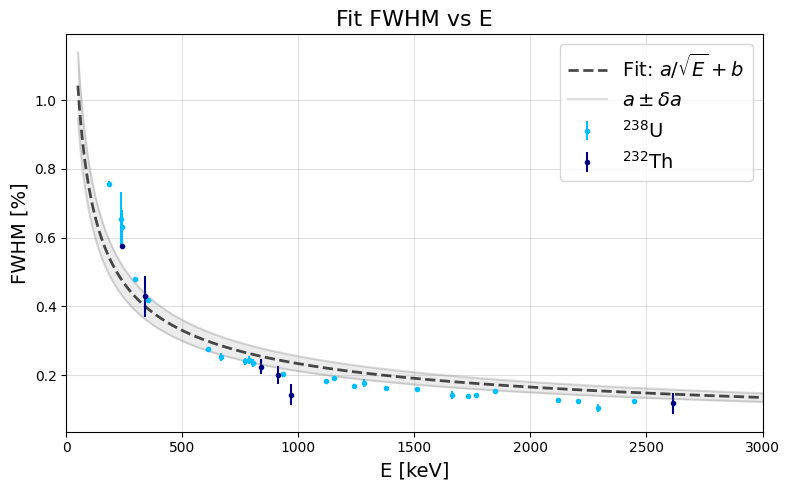

In [160]:


sigma=sigma_U_kev
sigma_err_kev =err_sigma_U_kev
mu_kev=mu_U_kev
mu_kev_err=err_mu_U_kev
# Calcolo FWHM e incertezza
FWHM, FWHM_err = fwhm_percentuale(sigma, sigma_err_kev, mu_kev, mu_kev_err)
FWHM_err = FWHM_err


# Fit con curve_fit, usando incertezza su y
boundary = ([0,0],[100,100])
p0=[0.1,0]
popt, pcov = curve_fit(fhwm_func, mu_kev, FWHM, sigma = FWHM_err, p0=p0, bounds=boundary)
perr_U_res = np.sqrt(np.diag(pcov))
print('incertezza grandi solo 3 punti del fit')
print("paramters:", popt)
print("Errori:", np.sqrt(np.diag(pcov)))

# Preparazione plot
E_fit = np.linspace(50, (3000), 1000)

plt.figure(figsize=(8, 5))
plt.ylabel('FWHM [%]')
# Fit teorico
plt.plot(E_fit, fhwm_func(E_fit,*popt )*100, label=r'Fit: $a/\sqrt{E} + b$ ', color='black', ls = '--', alpha = 0.7, lw=2)
# Dati con errore su x e y, e stile pallini
# Fino al -5: Uranio
plt.errorbar(mu_kev[:-6], FWHM[:-6] * 100,
             
             #yerr =  0.1,
             yerr=FWHM_err[:-6]* 100,
             fmt='o',
             color='deepskyblue',
             markersize=3,
             label=r'$^{238}$U')

# Ultimi 5: Torio
plt.errorbar(mu_kev[-6:], FWHM[-6:] * 100,
             
             yerr=FWHM_err[-6:]* 100,
             fmt='o',
             color='navy',
             markersize=3,
             label=r'$^{232}$Th')

upper_curve = fhwm_func(E_fit, popt[0] + 2*perr_U_res[0], popt[1]) * 100
lower_curve = fhwm_func(E_fit, popt[0] - 2*perr_U_res[0], popt[1]) * 100

# Riempie l'area tra le due curve
plt.fill_between(E_fit, lower_curve, upper_curve, color='gray', alpha=0.15)

# Traccia le due curve (come già fai)
plt.plot(E_fit, upper_curve,  color='gray', alpha=0.25, label=r"$a \pm \delta a$")
plt.plot(E_fit, lower_curve, color='gray', alpha=0.25)
a_res_U = popt[0]
b_res_U  = popt[1]
# Etichette
plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.title('Fit FWHM vs E',  size = 16)
plt.xlim(0,3000)
plt.grid(alpha=0.4)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("new image/FWHM_U", dpi=300, bbox_inches='tight')
plt.show()

# Subtracted Spectrum

In [265]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values

# correggo col dead time il background
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto



In [266]:
# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto

spectrum_U 

array([0, 0, 0, ..., 0, 0, 0], shape=(8192,))

In [267]:

conversion = t_live_u/t_live_b

In [268]:
spectrum_bkg_norm = spectrum_bkg*conversion

In [269]:
spectrum_fin = spectrum_U-spectrum_bkg_norm

In [270]:
len(spectrum_fin)

8192

In [271]:
chn = np.linspace(0, len(spectrum_fin), len(spectrum_fin))
energies = chn*a + b

(1, 100000.0)

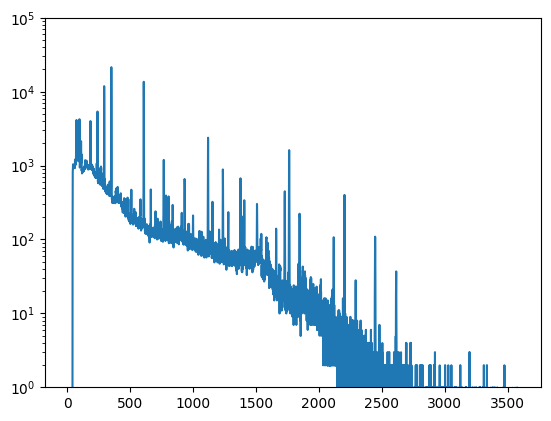

In [272]:
plt.plot(energies, spectrum_fin)
plt.yscale('log')
plt.ylim(1, 1e5)

## X-ray peaks below 240 keV

In [273]:
x_peaks_uranio = {
    72.8: 'Lβ₂',
    74.97: 'Lβ₁',
    77.16: 'Lβ₃',
    84.6: 'Lγ₁',
    87.2: 'Lγ₂/γ₃',
}


In [274]:
import matplotlib.pyplot as plt
from pastamarkers import pasta, salsa


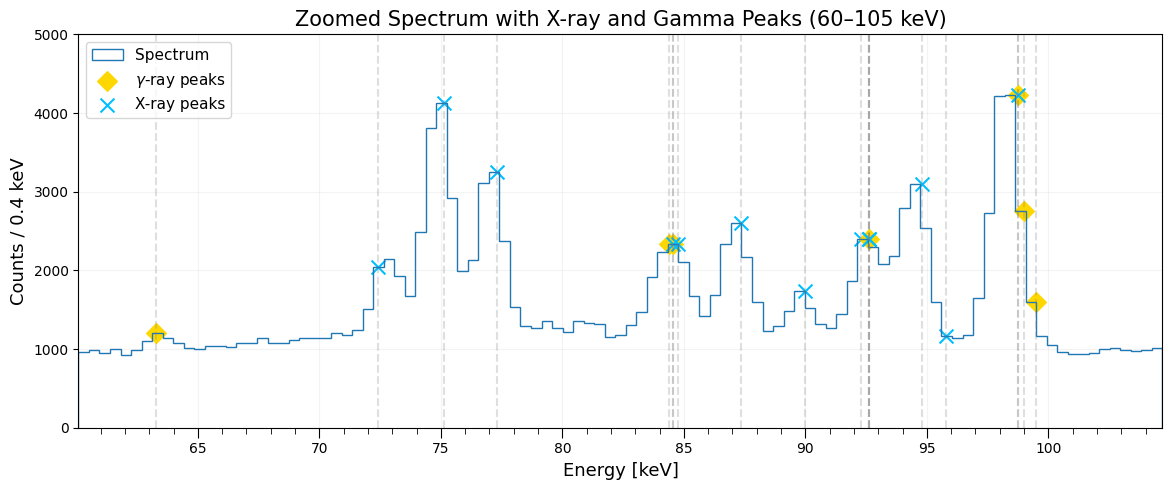

In [275]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from matplotlib.ticker import MultipleLocator
from collections import defaultdict
import os

# Maschera per lo zoom nello spettro
mask = (energies > 60) & (energies < 105)
energies_X = energies[mask]
spec_X = spectrum_fin[mask]

# Trova picchi sopra soglia
peaks, properties = find_peaks(spec_X, height=3.1e4)

# Serie L dell’Uranio
x_peaks_uranio = {
    72.8: 'Lβ₂',
    74.97: 'Lβ₁',
    77.16: 'Lβ₃',
    84.6: 'Lγ₁',
    87.2: 'Lγ₂/γ₃',
}

# Altri picchi gamma noti
extra_peaks = {
    63.290 : r'$^{234}$Th',
    84.373 : r'$^{228}$Th',
    92.5: r'$^{234}$Th',
    99.0: r'$^{228}$Ac',
}

# X-ray e gamma-ray
x_ray = {
    72.43 : r'Kα₂ Pb/ Kα₁ Tl',
    75.11 : r'Kα₂ Bi/ Kα₁ Pb',
    77.30 : r'Kα₁ Bi',
    84.74 : r'Kβ₃ Pb/ Kβ₁ Pb/ Kβ₂ Tl',
    87.36 : r'Kβ₂ Pb/ Kβ₁ Bi',
    89.98 : r'Kα₂ Th/ Kβ₂ Bi/ Kβ₁ Po',
    92.61 : r'Kα₁ Th',
    92.28 : r'Kα₂ Pa',
    94.79 : r'Kα₂ Th',
    95.8  : r'Kα₁ Pa',
    98.73 : r'Kα₁ U'
}

gamma_ray = {
    63.290: r'$^{228}$Th',
    84.373: r'$^{228}$Th',
    92.61 : r'$^{228}$Th',
    98.73 : r'$^{228}$Ac',
    99.509: r'$^{228}$Ac'
}

# Picchi combinati
merged_peaks = {
    84.56: [
        ('x-ray', x_ray[84.74]),
        ('gamma', gamma_ray[84.373])
    ],
    92.6: [
        ('x-ray', x_ray[92.61]),
        ('x-ray', x_ray[92.28]),
        ('gamma', gamma_ray[92.61])
    ],
    63.29: [('gamma', gamma_ray[63.290])],
    98.73: [('x-ray', x_ray[98.73]), ('gamma', gamma_ray[98.73])],
    99.0: [('gamma', extra_peaks[99.0])],
}

# Aggiungi picchi non sovrapposti
for e, l in x_ray.items():
    if e not in merged_peaks:
        merged_peaks[e] = [('x-ray', l)]

for e, l in gamma_ray.items():
    if e not in merged_peaks:
        merged_peaks[e] = [('gamma', l)]

# Plot setup
plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(axis='x', which='major', length=7, labelsize=10)
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)

# Spettro
bins = np.linspace(min(energies_X), max(energies_X), len(energies_X)+1)
hist, bins_edge, _ = plt.hist(energies_X, bins=bins, weights=spec_X,
                              histtype='step', label='Spectrum')
db = (bins_edge[1] - bins_edge[0])
plt.xlabel('Energy [keV]', fontsize=13)
plt.ylabel(f'Counts / {db:.1f} keV', fontsize=13)
plt.title(f'Zoomed Spectrum with X-ray and Gamma Peaks ({min(energies_X):.0f}–{max(energies_X):.0f} keV)', fontsize=15)
plt.xlim(min(energies_X), max(energies_X))
plt.ylim(0, 150000)

# Gestione spostamenti orizzontali (X) per etichette
sorted_peaks = sorted(merged_peaks.items(), key=lambda x: x[0])
x_shifts = {}
shift_amount = 0.35
last_energy = None
shift_direction = 1

for energy, _ in sorted_peaks:
    if last_energy is not None and abs(energy - last_energy) < 1.0:
        if abs(energy - 92.61) < 0.2 or abs(energy - 94.79) < 0.2:
            x_shifts[energy] = shift_direction * 1.2  # spostamento maggiore per Kα₁/Kα₂ Th
        else:
            x_shifts[energy] = shift_direction * shift_amount
        shift_direction *= -1
    else:
        x_shifts[energy] = 0
        shift_direction = 1
    last_energy = energy

# Flag per evitare label duplicate
plotted_labels = {'x-ray': False, 'gamma': False}

# Plot dei picchi con etichette spostate
for energy, entries in sorted_peaks:
    idx = (np.abs(energies_X - energy)).argmin()
    count = spec_X[idx]
    shift_x = x_shifts[energy]

    for j, (ptype, label) in enumerate(sorted(entries, key=lambda x: 0 if x[0] == 'gamma' else 1)):
        offset_y = 8000 + j * 40000
        marker = 'D' if ptype == 'gamma' else 'x'
        color = 'gold' if ptype == 'gamma' else 'deepskyblue'
        size = 100

        # Marker al picco
        plt.scatter(energy, count, color=color, marker=marker, s=size,
                    label=r'$\gamma$-ray peaks' if (ptype == 'gamma' and not plotted_labels['gamma']) else (
                          'X-ray peaks' if (ptype == 'x-ray' and not plotted_labels['x-ray']) else ""))

        # Etichetta spostata sull’asse X
       
        plt.axvline(energy, 0, color='grey', alpha=0.25, ls='--')

        plotted_labels[ptype] = True

plt.grid(alpha=0.15)
plt.legend(fontsize=11)
plt.tight_layout()
plt.ylim(0,5000)
# Salva immagine
save_path = "new image"
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "x-rays_zoomed.png"), dpi=300, bbox_inches='tight')
plt.show()


In [276]:
# picco a 90 -- picchi gamma del th
#picco a 99 kev è il picco gamma dell'>Ac dalla catena del thorio

## Continue activity

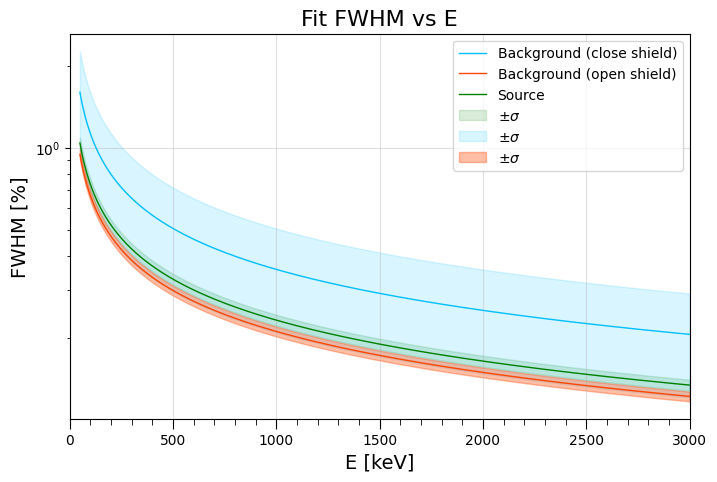

In [277]:
# Parametri per tacche su asse x
dx = 500  # numeri ogni 500 keV
dy = 100  # tacche ogni 100 keV

E_fit = np.linspace(50, 3000, 1000)

plt.figure(figsize=(8, 5))

# === IMPOSTA TICKS X PRIMA DEL PLOT ===
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=7, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

plt.plot(E_fit, fhwm_func(E_fit,a_res_bkg, b_res_bkg)*100, lw = 1, color = 'deepskyblue', label=r'Background (close shield)')
plt.plot(E_fit, fhwm_func(E_fit,a_open_res, b_open_res)*100, lw = 1, color = 'orangered', label=r'Background (open shield)')
plt.plot(E_fit, fhwm_func(E_fit,a_res_U, b_res_U)*100, lw = 1, color = 'green',  label = 'Source')
#plt.plot(E_fit, fhwm_func(E_fit,a_res, b_res)*100, label=r'Source - Background')


#curva source
upper_curve = fhwm_func(E_fit,a_res_U + perr_U_res[0],b_res_U) * 100
lower_curve = fhwm_func(E_fit, a_res_U - perr_U_res[0], b_res_U) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='green', alpha=0.15, label = r'$\pm \sigma$')


#baclgroung
upper_curve = fhwm_func(E_fit, a_res_bkg + perr_back_res[0], b_res_bkg) * 100
lower_curve = fhwm_func(E_fit, a_res_bkg - perr_back_res[0],b_res_bkg) * 100
plt.fill_between(E_fit, lower_curve, upper_curve, color='deepskyblue', alpha=0.15, label = r'$\pm \sigma$')

#background open
upper_curve = fhwm_func(E_fit,a_open_res + perr_open_res[0], b_open_res)*100
lower_curve = fhwm_func(E_fit,a_open_res - perr_open_res[0], b_open_res)*100
plt.fill_between(E_fit, lower_curve, upper_curve, color='orangered', alpha=0.35, label = r'$\pm \sigma$')


plt.yscale('log')

plt.xlabel('E [keV]' ,size = 14)
plt.ylabel('FWHM [%]',  size = 14)
plt.title('Fit FWHM vs E',  size = 16)
plt.grid(alpha=0.4)
plt.legend(fontsize=10)
plt.xlim(0,3000)
plt.savefig("new image/ comparison_res", dpi=300, bbox_inches='tight')


### !!!

Manually creating a bettere enrgy resolution ---> cancelig the widers tails

[Aggiungi]

## Average activity Estimation

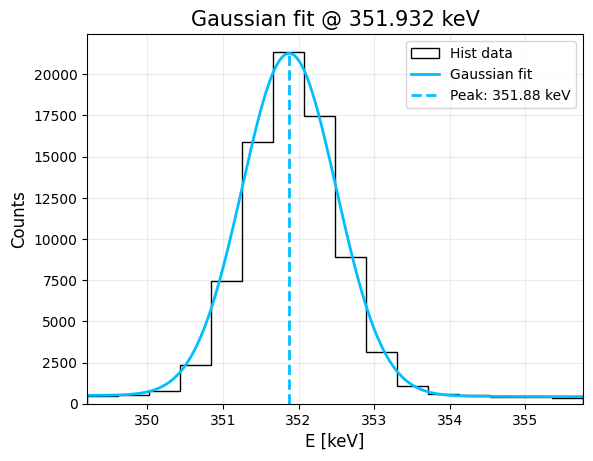

In [278]:

E_214Pb = 295.224
I_214Pb = 0.193

E_214Pb = 241.997
I_214Pb = 0.0743


E_214Pb = 351.932
I_214Pb = 0.376



dx = 3
popt_214, err_214, _ = fit_func_sottratto( spectrum_U, spectrum_bkg_norm, E_214Pb, dx=dx, kev = True, energies= energies)

A_eff = popt_214[0]/(I_214Pb * t_real_u)

# the maximum efficiency is around 5%
eff_max = 0.045

A_max = A_eff/(eff_max)
dA_max = err_214[0]/(I_214Pb * t_real_u)

In [279]:
A_max

np.float64(3071.1597728424945)

In [280]:
dA_max

np.float64(1.1107243226407792)

# Average activity estimation

In [281]:
perr[4]

np.float64(0.020146974772587343)

In [282]:
channels = np.arange(len(spectrum_U))         # x originale
energies = a * channels + b

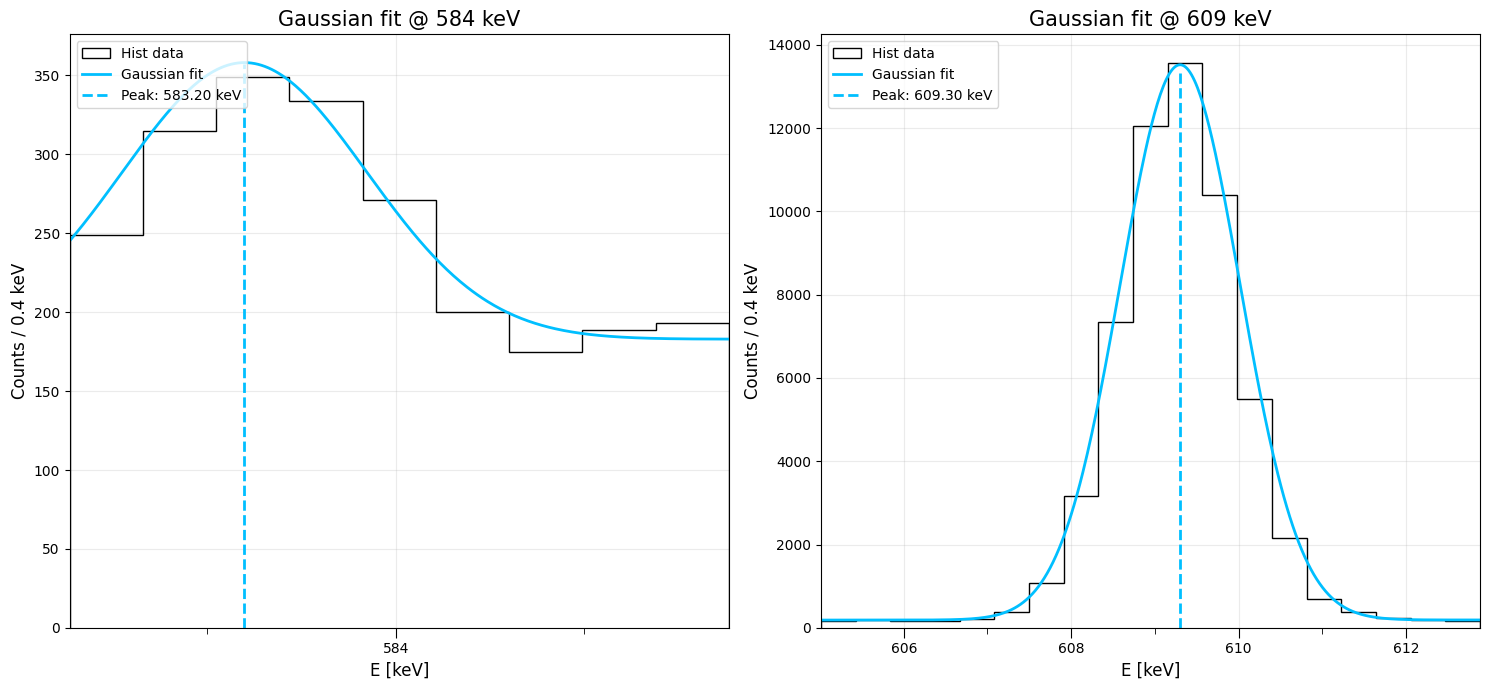

In [283]:
fig, axes = plt.subplots(1,2, figsize=(15, 7))  # 1 riga, 3 colonne
E_kev = np.sort([609, 584.12]) #kev
popt_kev = []
popt_kev_err = []
N_kev = []
N_kev_err = []
dofs = []
for i, e in enumerate(E_kev):
    if e == E_kev[0]:
        dx = 2
    else:
        dx=4
    popt, err, dof = fit_func( spectrum_U, e, dx = dx, kev = True, energies = energies, ax=axes[i])
    popt_kev.append(popt[1])
    popt_kev_err.append(err[1])
    N_kev.append(popt[0])
    N_kev_err.append(err[0])
    dofs.append(dof)
popt_kev = np.vstack(popt_kev)
popt_kev_err = np.vstack(popt_kev_err)
#dofs = np.vstack(dofs)

plt.tight_layout()
plt.savefig("new image/energy_peak_fit_bkg", dpi=300, bbox_inches='tight')
plt.show()


In [284]:
popt_kev

array([[583.19545407],
       [609.30085937]])

In [285]:
N_kev[0]

np.float64(286.2406935078326)

In [286]:
cps_total = np.sum(spectrum_fin)/t_real_u

In [287]:
frac_th = ((N_kev[0]*0.3036)/(N_kev[1]*0.461))
print(frac_th)
cps_thorium = cps_total * frac_th*4# numero isotopi che maggiormente contirbuiscono alla catrena del 232Th

cps_U = cps_total - cps_thorium
print(f' cps totale {cps_total:.0f} cps')
print(f' cps thorium {cps_thorium:.0f} cps')
print(f' cps uranium  {cps_U:.0f} cps')

0.007901184580770815
 cps totale 2014 cps
 cps thorium 64 cps
 cps uranium  1950 cps


In [288]:
cps_U /4

np.float64(487.55975958121564)

In [289]:
def propagated_uncertainty(Ui, N1, sigma_N1, Y1, N2, sigma_N2, Y2):
    dUf_dN1 = -Ui * Y1 / (N2 * Y2)
    dUf_dN2 = Ui * N1 * Y1 / (N2**2 * Y2)
    
    sigma_Uf = np.sqrt((dUf_dN1 * sigma_N1)**2 + (dUf_dN2 * sigma_N2)**2)
    return sigma_Uf


In [290]:
dcps_U = propagated_uncertainty(cps_total,N_kev[0],N_kev_err[0],0.3036,N_kev[1],N_kev_err[1],0.461 )

In [291]:
# mi divio il count rate totale in 4 isotopi principali

A0 = cps_U/4
dA0= dcps_U/4
print('A0', A0)
print('dA0', dA0)

eff_max = 0.05

A_max_new = A0/(eff_max)
dA_max_new= dA0 / eff_max

print('diviso efficineza', A_max_new)
print('err efficineza', dA_max_new)

A0 487.55975958121564
dA0 1.8830959303509864
diviso efficineza 9751.195191624312
err efficineza 37.66191860701973


# Attività

In [292]:
def potenza(E, a, k):
    return k * np.pow(E, -a)

In [293]:
def linear(x,a,b):
    return -a*x + b

### Lead 214 Pb

In [310]:
b_p = 5.3
energies = a * channels + b_p

In [311]:
1/3.07

0.32573289902280134

In [312]:
90.6/3.07

29.5114006514658

In [313]:



E_214Bi = [
    609.312,
    934.061,
    1120.287,
    1238.110,
    1377.669,
    1764.494,
    2204.210
]

I_214Bi = [
    0.461,
    0.0303,
    0.151,
    0.0579,
    0.04,
    0.150,
    0.058
]



In [314]:
E_214Bi =  [2204.21,
            2118.55,
            1847.42,
            1764.49,
            1729.595,
            1377.669]
I_214Bi = [0.05,
          0.01,
          0.02,
          0.15,
          0.03,
          0.04]

In [315]:
E_214Pb = [ 241.997,
            295.224,
            351.932]

I_214Pb = [ 0.0743,
            0.193,
            0.376]

E_Ra = [ 186.221]

I_Ra = [ 0.0359]


In [316]:
0.02811+ 0.0277

0.05581

In [317]:
###### faccio un unico picco a 90 kev 
E_th = [63.290, 92.60]
I_th = [0.0484, 0.05581]

In [318]:
E_pa = [766.380, 1001, 1554.1 , 1174.2 ]
I_pa = [0.003, 0.0084, 0.00808, 0.00190]


In [319]:
E_tot = []
#E_tot.extend(E_pa)
E_tot.extend(E_th)
E_tot.extend(E_Ra)
E_tot.extend(E_214Pb)
E_tot.extend(E_214Bi)
E_tot = np.array(E_tot)


In [320]:
I_tot = []
#I_tot.extend(I_pa)
I_tot.extend(I_th)
I_tot.extend(I_Ra)
I_tot.extend(I_214Pb)
I_tot.extend(I_214Bi)

I_tot = np.array(I_tot)

In [321]:
len(I_tot)

12

In [322]:
E_tot[6]

np.float64(2204.21)

(91.02009079034156, 104.57786025207925)

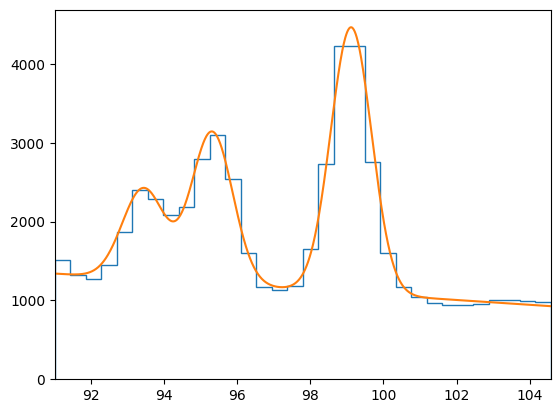

In [324]:
mask_th = (energies > 91) & (energies < 105)
ene_th = energies[mask_th]
spec_th = spectrum_fin[mask_th]
bins = np.linspace(min(ene_th), max(ene_th), len(ene_th)+1)
counts, bin_edge, _ = plt.hist(ene_th, bins = bins, weights = spec_th, histtype='step' )


p0 = [400, 93, 0.1, 
      400, 95,  0.1, 
      800, 99,  0.1, 
      0, 10000]

bounds = ([0,0.9*92,0,
          0,0.9*93,0,
          0,0.9*99,0,
          -1000, 0],
         [1000000,1.1*92,2,
         1000000,1.1*93,2,
         1000000,1.1*99,2,
         1000, 10000000])

popt, pcov = curve_fit(triple_gauss_offset,
                       ene_th, spec_th,
                       p0=p0, bounds = bounds)
perr = np.sqrt(np.diag(pcov))

A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, slope, offset = popt

x  = np.linspace(min(bins), max(bins), 1000)
plt.plot(x, triple_gauss_offset(x, *popt), label = 'total fit')

plt.xlim(min(ene_th), max(ene_th))

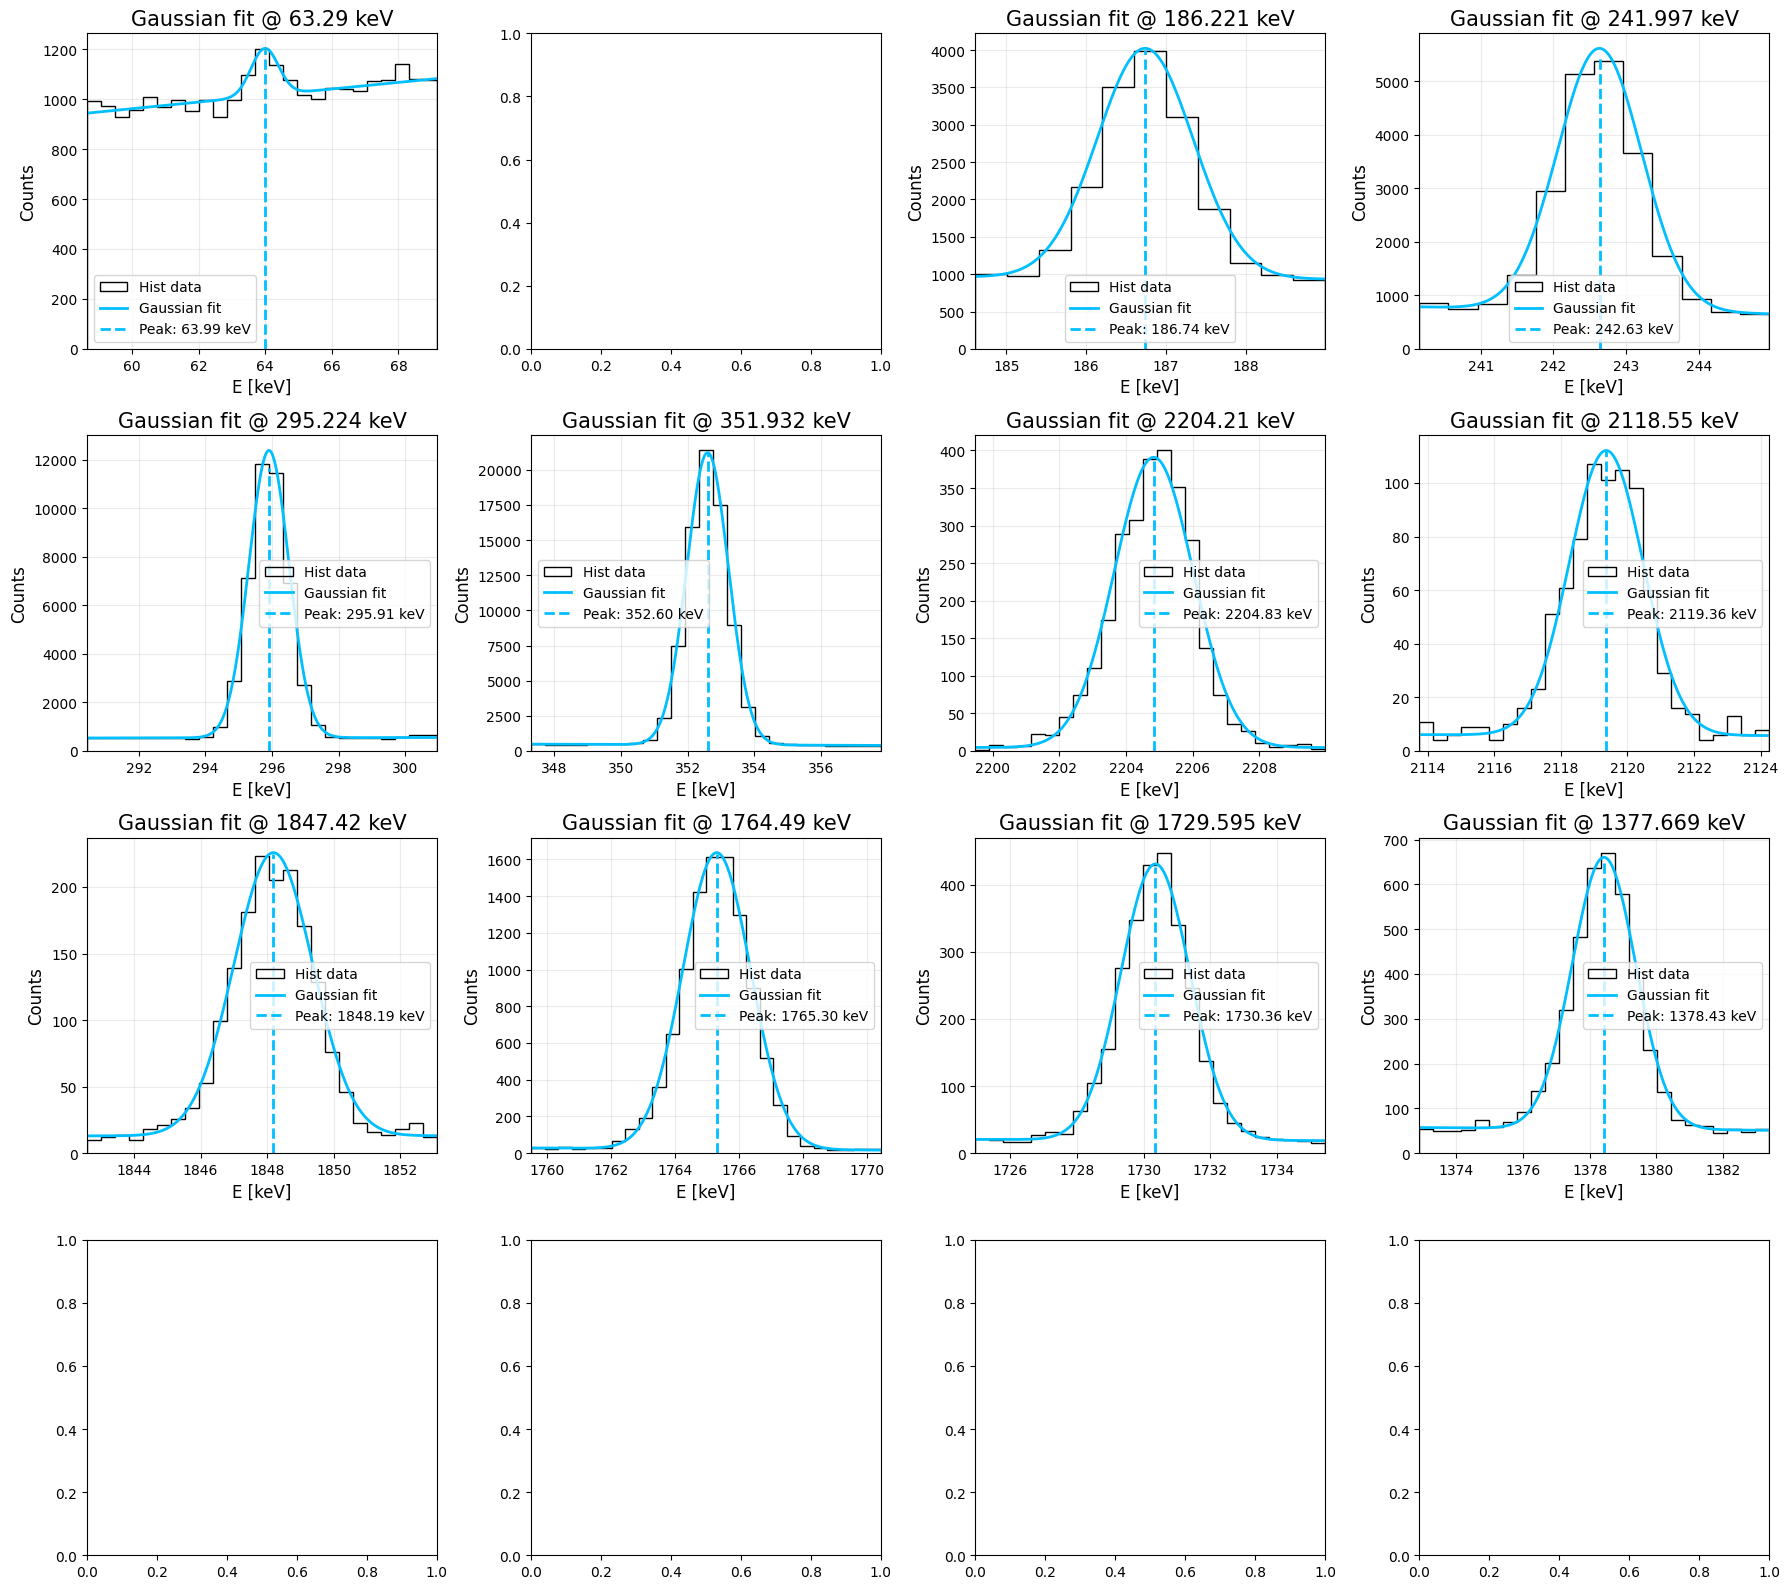

In [386]:
popts_N = []
errs_N = []

popts_mu = []
errs_mu = []
popts_N.append(A1)
errs_N.append(perr[0])
popts_mu.append(mu1)
errs_mu.append(perr[1])

fig, axes = plt.subplots(4, 4, figsize=(18, 16))  # 4 righe, 2 colonne

axes = axes.flatten() 
for i, e in enumerate(E_tot):
    ax = axes[i]
    
    if e == 92.60:
        continue
    
    if e == 186.221 or e==241.997:
        dx =2

    else:
        dx = 5


    popt, err, _ = fit_func_sottratto(
        spectrum_U, spectrum_bkg_norm, e,
        dx=dx, kev=True, energies=energies, ax=ax
    )

    if popt is not None:
        popts_N.append(popt[0])
        errs_N.append(err[0] )
        popts_mu.append(popt[1])
        errs_mu.append(err[1] )




plt.tight_layout()
plt.show()


In [411]:
# Scambiare primo e secondo elemento
popts_N[0], popts_N[1] = popts_N[1], popts_N[0]
errs_N[0], errs_N[1] = errs_N[1], errs_N[0]
popts_mu[0], popts_mu[1] = popts_mu[1], popts_mu[0]
errs_mu[0], errs_mu[1] = errs_mu[1], errs_mu[0]


In [412]:
Y = []
sigma_Y = []
sigma_logY = []

import numpy as np

# Converti in array nel caso non lo siano
mu_kev = np.array(popts_mu)
mu_kev_err = np.array(errs_mu)
N_U = np.array(popts_N)
N_U_err = np.array(errs_N)


for i in range(len(N_U)):
    # non divido per l'efficienza
    num = N_U[i]
    sigma_num = N_U_err[i]  # deve essere definito

    #eff = get_eff_value(mu_kev[i], x_eff, eff_value)
    den = t_live_u  * I_tot[i]

    Y_i = num / den
    sigma_Y_i = sigma_num / den

    sigma_logY.append( (sigma_num)/num)
    Y.append(Y_i)
    sigma_Y.append(sigma_Y_i)

-3.906858289604865
-3.906858289604865
-0.10516324561429208
0.0007595217499115336
5.201129224044903e-05


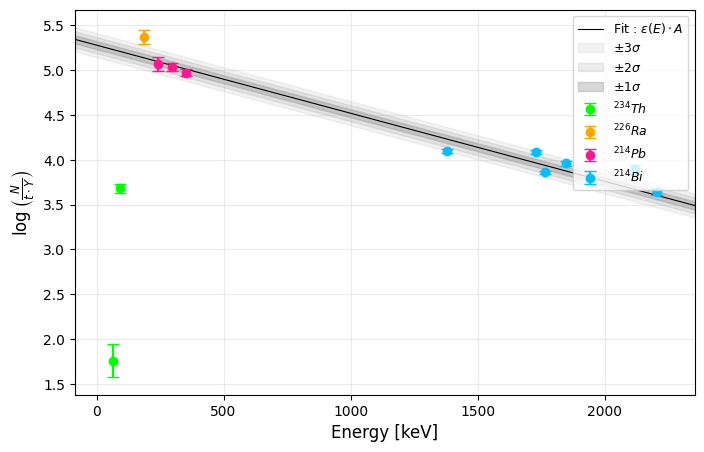

In [413]:
y_fit = Y[2:]
mu_fit = mu_kev[2:]
sigma_err = sigma_logY[2:]

x = np.linspace(min(mu_kev)-150, max(mu_kev)+150, 10000)

plt.figure(figsize=(8,5))

bounds = ([0, 8.15],[1, 8.20])
p0 = [0.05, 8.18]
popt, cov = curve_fit(linear,mu_fit ,np.log(y_fit), sigma=np.abs(sigma_err) )#, p0 = p0, bounds = bounds)
m = popt[0]
q_prime = popt[1]

m_err = np.sqrt(np.diag(cov))[0]
q_prime_err =  np.sqrt(np.diag(cov))[1]

#q = q_prime - np.log(A_max)
q = q_prime - np.log(A_max_new)
q_err = q_prime_err - 0.15 
print(q)
print(q)
print(q_err)
print(m)
print(m_err)

# Calcolo i valori di fit per il parametro q_prime ± n*sigma
fit_central = linear(x, popt[0], popt[1])
fit_p1 = linear(x, popt[0], popt[1] + q_prime_err)
fit_m1 = linear(x, popt[0], popt[1] - q_prime_err)
fit_p2 = linear(x, popt[0], popt[1] + 2*q_prime_err)
fit_m2 = linear(x, popt[0], popt[1] - 2*q_prime_err)
fit_p3 = linear(x, popt[0], popt[1] + 3*q_prime_err)
fit_m3 = linear(x, popt[0], popt[1] - 3*q_prime_err)

# Plot della curva centrale
plt.plot(x, fit_central, color='black', lw=0.8, label=r'Fit : $\varepsilon(E) \cdot A$')

# Riempio le bande di incertezza con grigi sempre più chiari
plt.fill_between(x, fit_m3, fit_p3, color='gray', alpha=0.1, label=r'$\pm 3\sigma$')
plt.fill_between(x, fit_m2, fit_p2, color='gray', alpha=0.15, label=r'$\pm 2\sigma$')
plt.fill_between(x, fit_m1, fit_p1, color='gray', alpha=0.3, label=r'$\pm 1\sigma$')
'''
# Linee tratteggiate per ±1σ, ±2σ, ±3σ (opzionale)
plt.plot(x, fit_p1, color='black', lw=0.75, ls='--', alpha=0.8)
plt.plot(x, fit_m1, color='black', lw=0.75, ls='--', alpha=0.8)
plt.plot(x, fit_p2, color='black', lw=0.75, ls=':', alpha=0.7)
plt.plot(x, fit_m2, color='black', lw=0.75, ls=':', alpha=0.7)
plt.plot(x, fit_p3, color='black', lw=0.75, ls='-.', alpha=0.6)
plt.plot(x, fit_m3, color='black', lw=0.75, ls='-.', alpha=0.6)
'''
# Errorbar per i dati
plt.errorbar(mu_kev[:2], np.log(Y[:2]), yerr=np.abs(sigma_logY[:2]), fmt='o', color='lime', label=r'$^{234}Th$', markersize=6, capsize=4)
plt.errorbar(mu_kev[2], np.log(Y[2]), yerr=np.abs(sigma_logY[2])*5, fmt='o', color='orange', label=r'$^{226}Ra$', markersize=6, capsize=4)
plt.errorbar(mu_kev[3:6], np.log(Y[3:6]), yerr=np.abs(sigma_logY[3:6])*5, fmt='o', color='deeppink', label=r'$^{214}Pb$', markersize=6, capsize=4)
plt.errorbar(mu_kev[6:], np.log(Y[6:]), yerr=np.abs(sigma_logY[6:]), fmt='o', color='deepskyblue', label=r'$^{214}Bi$', markersize=6, capsize=4)

plt.xlabel("Energy [keV]", size=12)
plt.xlim(min(x), max(x))
plt.ylabel(r"$\log\left(\frac{N}{t \cdot Y}\right)$", size=12)
plt.grid(alpha=0.25)
plt.legend(fontsize=9, loc = 'upper right')
plt.savefig("new image/Y_vs_E", dpi=300, bbox_inches='tight')
plt.show()


y_fit = Y[2:]
mu_fit = mu_kev[2:]
sigma_err = sigma_logY[2:]

x = np.linspace(min(mu_kev)-50, max(mu_kev)+150, 10000)

plt.figure(figsize=(8,5))

bounds = ([0, 8.28],[1, 8.3])
p0 = [0.05, 8.29]
popt, cov = curve_fit(linear,mu_fit ,np.log(y_fit), sigma=np.abs(sigma_err) , p0 = p0, bounds = bounds)
m = popt[0]
q_prime = popt[1]

m_err = np.sqrt(np.diag(cov))[0]
q_prime_err =  np.sqrt(np.diag(cov))[1]

q = q_prime - np.log(A_max)
q_err = q_prime_err - 0.15 
print(q)
print(q_prime)

# Calcolo i valori di fit per il parametro q_prime ± n*sigma
fit_central = linear(x, popt[0], popt[1])

# Plot della curva centrale
plt.plot(x, fit_central, color='black', lw=0.8, label=r'Fit high energy')


bounds = ([-10, 0],[0, 15])
p0 = [-0.05, 8.29]
popt, cov = curve_fit(linear,mu_kev[:3] ,np.log(Y[:3]), sigma=np.abs(sigma_logY[:3]),  p0 = p0, bounds = bounds)
m = popt[0]
q_prime = popt[1]

m_err = np.sqrt(np.diag(cov))[0]
q_prime_err =  np.sqrt(np.diag(cov))[1]

q = q_prime - np.log(A_max)
q_err = q_prime_err - 0.15 
print(q)
print(q_prime)

# Calcolo i valori di fit per il parametro q_prime ± n*sigma
x1 = np.linspace(0, 200,1000)
fit_central = linear(x1, popt[0], popt[1])
# Plot della curva centrale
plt.plot(x1, fit_central, color='black', lw=0.8, label=r'Fit low energy')


# Errorbar per i dati
plt.errorbar(mu_kev[:2], np.log(Y[:2]), yerr=np.abs(sigma_logY[:2]), fmt='o', color='lime', label=r'$^{234}Th$', markersize=6, capsize=4)
plt.errorbar(mu_kev[2], np.log(Y[2]), yerr=np.abs(sigma_logY[2])*5, fmt='o', color='orange', label=r'$^{226}Ra$', markersize=6, capsize=4)
plt.errorbar(mu_kev[3:5], np.log(Y[3:5]), yerr=np.abs(sigma_logY[3:5])*5, fmt='o', color='deeppink', label=r'$^{214}Pb$', markersize=6, capsize=4)
plt.errorbar(mu_kev[5:], np.log(Y[5:]), yerr=np.abs(sigma_logY[5:])*5, fmt='o', color='deepskyblue', label=r'$^{214}Bi$', markersize=6, capsize=4)

plt.xlabel("Energy [keV]", size=12)
plt.xlim(min(x), max(x))
plt.ylabel(r"$\log\left(\frac{N}{t \cdot Y}\right)$", size=12)
plt.grid(alpha=0.25)
plt.legend(fontsize=9, loc = 'upper right')
plt.savefig("HPGe images/activity/Y_vs_E", dpi=300, bbox_inches='tight')
plt.show()


In [414]:
def eff_err(E_tot, m, q, m_err, q_err):
    eff = np.exp(linear(E_tot, m, q)) 
    d1 = -E_tot * m_err
    d2 = q_err
    return eff*np.sqrt(d1**2 + d2**2)

In [415]:
np.log(0.05) + np.log(A_max_new)

np.float64(6.189412866681467)

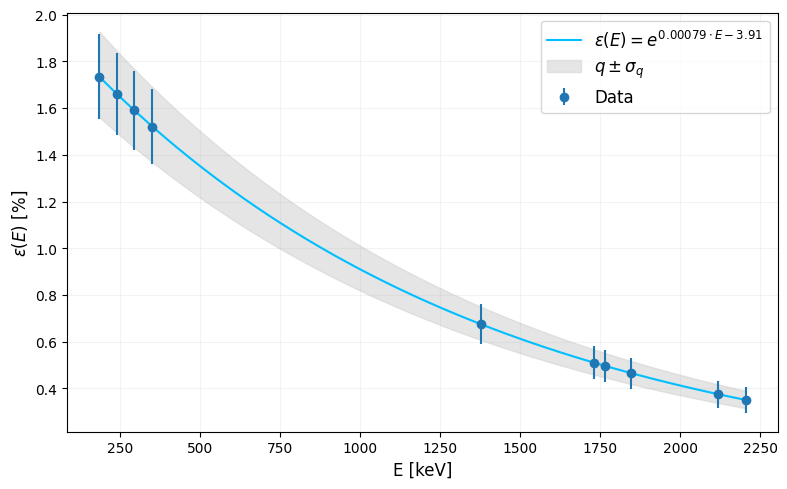

In [416]:
plt.figure(figsize = (8,5))
m = 7.922e-4
# Calcolo efficienza e incertezza
eff = np.exp(linear(E_tot[2:], m, q)) * 100
eff_err_vals = eff_err(E_tot[2:], m, q, m_err, q_err) * 100

# Plot dati con barre d'errore
plt.errorbar(E_tot[2:], eff, yerr = eff_err_vals, fmt = 'o', label='Data')

# Range continuo per le curve
x = np.linspace(min(E_tot[2:]), max(E_tot[2:]), 200)
central = np.exp(linear(x, m, q)) * 100
upper = np.exp(linear(x, m, q +q_err)) * 100
lower = np.exp(linear(x, m, q - q_err)) * 100



# Curve centrale
plt.plot(x, central, color='deepskyblue', 
         label=rf'$\varepsilon(E) = e^{{{m:.5f} \cdot E {q:+.2f}}}$')
# Banda grigia di incertezza ±3σ
plt.fill_between(x, lower, upper, color='lightgray', alpha=0.58, label=r'$q \pm \sigma_q$')
plt.xlabel('E [keV]', size = 12)
plt.ylabel(r'$\varepsilon(E)$ [%]', size = 12)
plt.grid(alpha = 0.15)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig("new image/eff_curve", dpi=300, bbox_inches='tight')
plt.show()


In [424]:
eff_new = np.exp(linear(mu_kev[:2], m, q)) 
print(100*np.exp(linear(mu_kev[0], m, q))/(3*6.15))
print(100*np.exp(linear(mu_kev[1], m, q))/5.95)

0.10118751015186453
0.32117466959882474


In [425]:
def A_err(mu_kev, Y,N_U, N_U_err, m, q, m_err, q_err):
    dY = (Y/N_U)*N_U_err
    deff_1 = -mu_kev*np.exp(linear(mu_kev, m, q))*m_err
    deff_2 = np.exp(linear(mu_kev, m, q))*q_err

    return np.sqrt(dY**2 +deff_1**2 + deff_2**2)
    
    
    

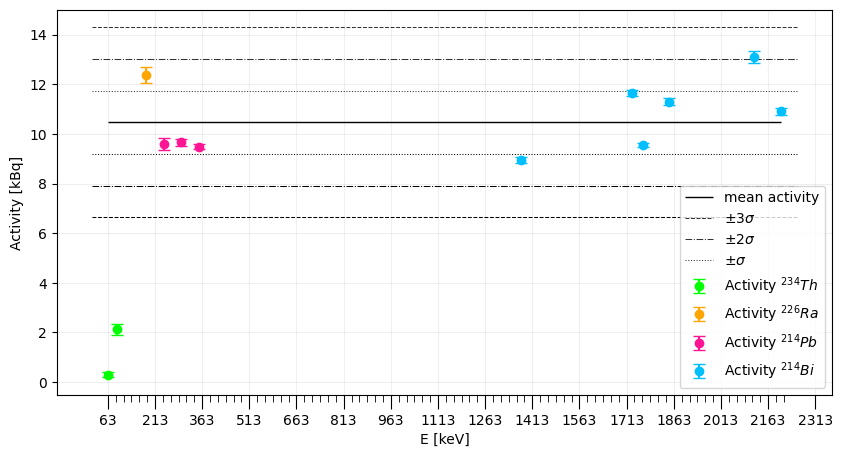

In [426]:

plt.figure(figsize=(10, 5))

A = np.array(Y) / np.exp(linear(mu_kev, m, q))
dA = A_err(mu_kev, Y, N_U, N_U_err, m, q, m_err, q_err)



plt.errorbar(mu_kev[:2], A[:2] / 1000, yerr=dA[:2] / 10, fmt='o', color='lime', capsize=4, label=r'Activity $^{234}Th$')
plt.errorbar(mu_kev[2], A[2] / 1000, yerr=dA[2] / 10, fmt='o', color='orange', capsize=4, label=r'Activity $^{226}Ra$')
plt.errorbar(mu_kev[3:6], A[3:6] / 1000, yerr=dA[3:6] / 10, fmt='o', color='deeppink', capsize=4, label=r'Activity $^{214}Pb$')
plt.errorbar(mu_kev[6:], A[6:] / 1000, yerr=dA[6:] / 10, fmt='o', color='deepskyblue', capsize=4, label=r'Activity $^{214}Bi$')

plt.grid(alpha=0.2)

A_equilibrium = A[3:]
mean_activity = np.mean(A_equilibrium / 1000)
std_activity = np.std(A_equilibrium / 1000)

xmin, xmax = min(mu_kev), max(mu_kev)

plt.hlines(mean_activity, xmin, xmax, color='black', lw=1, label=r'mean activity')
plt.hlines(mean_activity + 3 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='--', label=r'$\pm 3 \sigma$')
plt.hlines(mean_activity - 3 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='--')
plt.hlines(mean_activity + 2 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='-.', label=r'$\pm 2 \sigma$')
plt.hlines(mean_activity - 2 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='-.')
plt.hlines(mean_activity + std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='dotted', label=r'$\pm \sigma$')
plt.hlines(mean_activity - std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='dotted')

#plt.hlines(A_max/1000, xmin - 50, xmax + 50, color='red', lw=0.75, ls='dotted')


plt.ylabel('Activity [kBq]')
plt.xlabel('E [keV]')

# Impostare tacchette sull'asse x
minor_ticks = np.arange(xmin, xmax + 25, 25)  # tacchette ogni 25 keV
major_ticks = np.arange(xmin, xmax + 150,150)  # tacchette con label ogni 100 keV

plt.gca().set_xticks(minor_ticks, minor=True)
plt.gca().set_xticks(major_ticks)
plt.gca().set_xticklabels([str(int(tick)) for tick in major_ticks])

plt.gca().tick_params(axis='x', which='minor', length=5)  # lunghezza tacchette minori
plt.gca().tick_params(axis='x', which='major', length=10)  # lunghezza tacchette maggiori

plt.legend(loc='lower right')
plt.savefig("new image/attivita_finali", dpi=300, bbox_inches='tight')
plt.show()

In [427]:
print(f'A equilibrio {np.mean(A_equilibrium/1000):.0f} kBq pm {np.std(A_equilibrium/1000):.0f}')
print(f'A Th {np.mean(A[:2]/1000):.0f} kBq pm {np.std(A[:2]/1000):.0f}')
print(f'A Ra {(A[2]/1000):.0f} kBq pm {(A[2]*0.15/1000):.0f}')
print(f'A Bi {np.mean(A[3:6]/1000):.0f} kBq pm {np.std(A[3:6]/1000):.0f}')
print(f'A Pb {np.mean(A[6:]/1000):.0f} kBq pm {np.std(A[6:]/1000):.0f}')




A equilibrio 10 kBq pm 1
A Th 1 kBq pm 1
A Ra 12 kBq pm 2
A Bi 10 kBq pm 0
A Pb 11 kBq pm 1


In [428]:
m_sasso = 0.6*0.001 #kg

print(f'A equilibrio {np.mean(A_equilibrium/1000)/m_sasso:.0f} kBq/kg')
print(f'A Ra {(A[0]/1000)/m_sasso:.0f} kBq/kq')
print(f'A Bi {np.mean(A_equilibrium[1:4]/1000)/m_sasso:.0f} kBq/kg pm {np.std(A_equilibrium[1:4]/1000/m_sasso):.0f}')
print(f'A Pb {np.mean(A_equilibrium[4:]/1000)/m_sasso:.0f} kBq/kg pm {np.std(A_equilibrium[4:]/1000/m_sasso):.0f}')



A equilibrio 17446 kBq/kg
A Ra 3541 kBq/kq
A Bi 16694 kBq/kg pm 1051
A Pb 18188 kBq/kg pm 2486


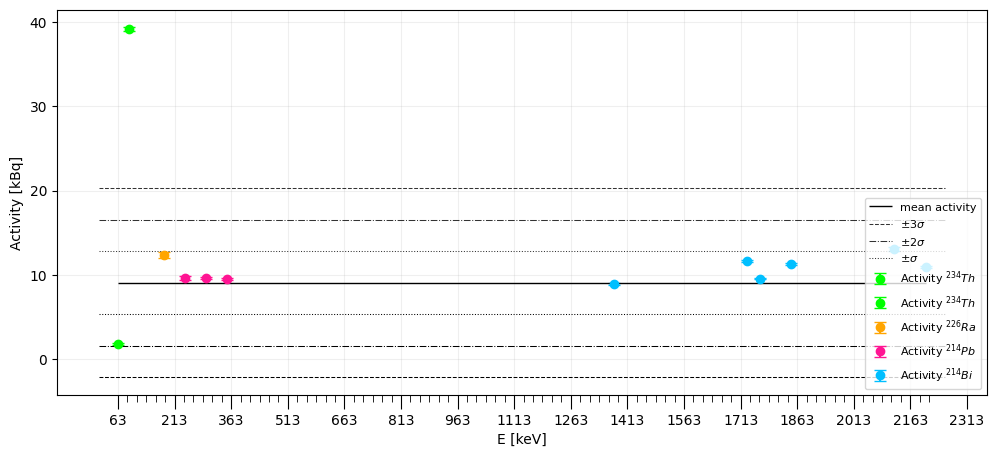

In [429]:

plt.figure(figsize=(12, 5))

A = np.array(Y) / np.exp(linear(mu_kev, m, q))
dA = A_err(mu_kev, Y, N_U, N_U_err, m, q, m_err, q_err)


plt.errorbar(mu_kev[0], A[0]*(3*6.15) / 1000, yerr=dA[0] / 10, fmt='o', color='lime', capsize=4, label=r'Activity $^{234}Th$')
plt.errorbar(mu_kev[1], A[1]*5.95 / 1000, yerr=dA[1] / 10, fmt='o', color='lime', capsize=4, label=r'Activity $^{234}Th$')
plt.errorbar(mu_kev[2], A[2] / 1000, yerr=dA[2] / 10, fmt='o', color='orange', capsize=4, label=r'Activity $^{226}Ra$')
plt.errorbar(mu_kev[3:6], A[3:6] / 1000, yerr=dA[3:6] / 10, fmt='o', color='deeppink', capsize=4, label=r'Activity $^{214}Pb$')
plt.errorbar(mu_kev[6:], A[6:] / 1000, yerr=dA[6:] / 10, fmt='o', color='deepskyblue', capsize=4, label=r'Activity $^{214}Bi$')

plt.grid(alpha=0.2)

#A_equilibrium = A[:3]
A_equilibrium = A
mean_activity = np.mean(A_equilibrium / 1000)
std_activity = np.std(A_equilibrium / 1000)

xmin, xmax = min(mu_kev), max(mu_kev)

plt.hlines(mean_activity, xmin, xmax, color='black', lw=1, label=r'mean activity')
plt.hlines(mean_activity + 3 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='--', label=r'$\pm 3 \sigma$')
plt.hlines(mean_activity - 3 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='--')
plt.hlines(mean_activity + 2 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='-.', label=r'$\pm 2 \sigma$')
plt.hlines(mean_activity - 2 * std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='-.')
plt.hlines(mean_activity + std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, alpha=0.8, ls='dotted', label=r'$\pm \sigma$')
plt.hlines(mean_activity - std_activity, xmin - 50, xmax + 50, color='black', lw=0.75, ls='dotted')

#plt.hlines(A_max/1000, xmin - 50, xmax + 50, color='red', lw=0.75, ls='dotted')


plt.ylabel('Activity [kBq]')
plt.xlabel('E [keV]')

# Impostare tacchette sull'asse x
minor_ticks = np.arange(xmin, xmax + 25, 25)  # tacchette ogni 25 keV
major_ticks = np.arange(xmin, xmax + 150,150)  # tacchette con label ogni 100 keV

plt.gca().set_xticks(minor_ticks, minor=True)
plt.gca().set_xticks(major_ticks)
plt.gca().set_xticklabels([str(int(tick)) for tick in major_ticks])

plt.gca().tick_params(axis='x', which='minor', length=5)  # lunghezza tacchette minori
plt.gca().tick_params(axis='x', which='major', length=10)  # lunghezza tacchette maggiori

plt.legend(loc='lower right', fontsize = 8)
plt.savefig("new image/attivita_vero_valore_eff", dpi=300, bbox_inches='tight')
plt.show()

0.10118751015186453
0.32117466959882474
parametri [-0.01378484 -0.85470704] err [0.00147298 0.19119934]


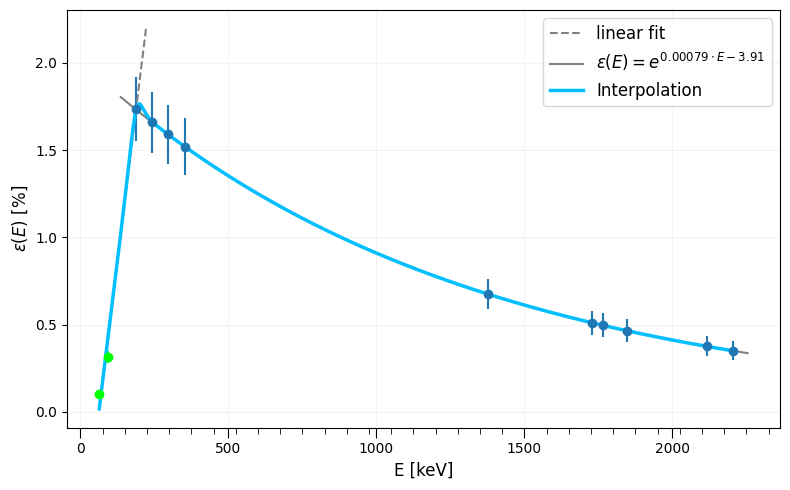

In [430]:
# Interpolazione continua tra retta bassa energia e curva esponenziale
def eff_low(E):  # Fit lineare bassa energia
    return linear(E, *popt)

def eff_high(E):  # Fit esponenziale generale
    return np.exp(linear(E, m, q)) * 100

def weight(E, E_trans=190, k=0.1):  # Funzione peso per transizione morbida
    return 1 / (1 + np.exp(k * (E - E_trans)))

def eff_interp(E):  # Interpolazione continua
    w = weight(E)
    return w * eff_low(E) + (1 - w) * eff_high(E)


# ----------------- CODICE COMPLETO -----------------
plt.figure(figsize = (8,5))


dx = 500
dy = 75
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))
ax.xaxis.set_minor_locator(MultipleLocator(dy))
ax.tick_params(axis='x', which='major', length=7, labelsize=10)
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)


# Calcolo efficienza e incertezza
eff = np.exp(linear(E_tot[2:], m, q)) * 100
eff_err_vals = eff_err(E_tot[2:], m, q, m_err, q_err) * 100

print(100*np.exp(linear(mu_kev[0], m, q))/(3*6.15))
print(100*np.exp(linear(mu_kev[1], m, q))/5.95)

# Plot dati con barre d'errore
plt.errorbar(E_tot[2:], eff, yerr = eff_err_vals, fmt = 'o')
plt.errorbar(E_tot[0], np.exp(linear(E_tot[0], m, q)) * 100/(3*6.15),
             yerr = eff_err(E_tot[0], m, q, m_err, q_err) * 100/(3*6.15), color ='lime', fmt = 'o')
plt.errorbar(E_tot[1], np.exp(linear(E_tot[1], m, q)) * 100/5.95,
             yerr =eff_err(E_tot[1], m, q, m_err, q_err) * 100 /5.95 ,color ='lime', fmt = 'o')

ene_low_ene = np.array([E_tot[0],E_tot[1], E_tot[2]])
eff_ene_low = np.array([
    np.exp(linear(E_tot[0], m, q)) * 100/(3*6.15),
    np.exp(linear(E_tot[1], m, q)) * 100/5.95,
    eff[0]
])
eff_ene_low_err = np.array([
    eff_err(E_tot[0], m, q, m_err, q_err) * 100,
    eff_err(E_tot[1], m, q, m_err, q_err) * 100,
    eff_err_vals[0]
])

# Fit bassa energia
p0 = [1, 0.01]
bounds = ([-10,-100],
         [10, 100])
popt, pcov = curve_fit(linear, ene_low_ene, eff_ene_low, sigma = eff_ene_low_err ,  p0 = p0, bounds = bounds )
x_low = np.linspace(min(ene_low_ene), max(ene_low_ene)+35, 200)
plt.plot(x_low, linear(x_low,*popt), '--', color='grey', label=rf'linear fit')
print('parametri', popt, 'err', np.sqrt(np.diag(pcov)) )
# Curve centrale
x = np.linspace(min(E_tot[2:])-50, max(E_tot[2:])+50, 200)
central = np.exp(linear(x, m, q)) * 100
upper = np.exp(linear(x, m, q +q_err)) * 100
lower = np.exp(linear(x, m, q - q_err)) * 100

# Fit esponenziale (alta energia)
plt.plot(x, central, color='grey',
         label=rf'$\varepsilon(E) = e^{{{m:.5f} \cdot E {q:+.2f}}}$')
#plt.fill_between(x, lower, upper, color='lightgray', alpha=0.58, label=r'$q \pm \sigma_q$')

# Interpolazione continua tra le due curve
x_interp = np.linspace(min(E_tot), max(E_tot), 300)
plt.plot(x_interp, eff_interp(x_interp), color='deepskyblue', lw = 2.5 , label='Interpolation')
# Grafico
plt.xlabel('E [keV]', size = 12)
plt.ylabel(r'$\varepsilon(E)$ [%]', size = 12)
plt.grid(alpha = 0.15)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.savefig("new image/CORREZIONE_A_MANO_eff_curve", dpi=300, bbox_inches='tight')
plt.show()


In [431]:
64/4

16.0

# background comparison


In [432]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values

# correggo col dead time il background
t_live_b = 76747
t_real_b = 76752
# correggo subito per il tempo morto
D_b = 1-(t_live_b/t_real_b)

spectrum_bkg = spectrum_bkg

print(np.sum(spectrum_bkg)/t_real_b, 'cps')

# normalizzo al tmepo dell'uranio
spectrum_bkg = spectrum_bkg*(t_real_u/ t_real_b)


1.0338101938711695 cps


In [401]:



# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values

# correggo col dead time l'uranio
t_live_u = 601
t_real_u = 625
# correggo subito per il tempo morto
D_u = 1-(t_live_u/t_real_u)

spectrum_U = spectrum_U
print(np.sum(spectrum_U)/t_real_u, 'cps')


2014.8816 cps


In [402]:
# Load the spectrum data
file_path = "Bckg_OPEN.csv"
data = pd.read_csv(file_path, header=None)

# Ensure data is 1D (each count per channel/bin)
spectrum_open = data[0].values

# correggo col dead time il background---> lo faccio subito in modod talr da avere già lo sesso spettro corretto ed avere la stessa risoluszione enrgetica. il dead time peggior la risoluzione
t_live_open = 58348
t_real_open = 58394
# correggo subito per il tempo morto
D_b = 1-(t_live_open/t_real_open)
# normalizzo anche al tempo pou corto dell'uranio
spectrum_open = spectrum_open
spectrum_open = spectrum_open*(t_real_u/ t_real_open)
spectrum_open[spectrum_open < 0] = 0 


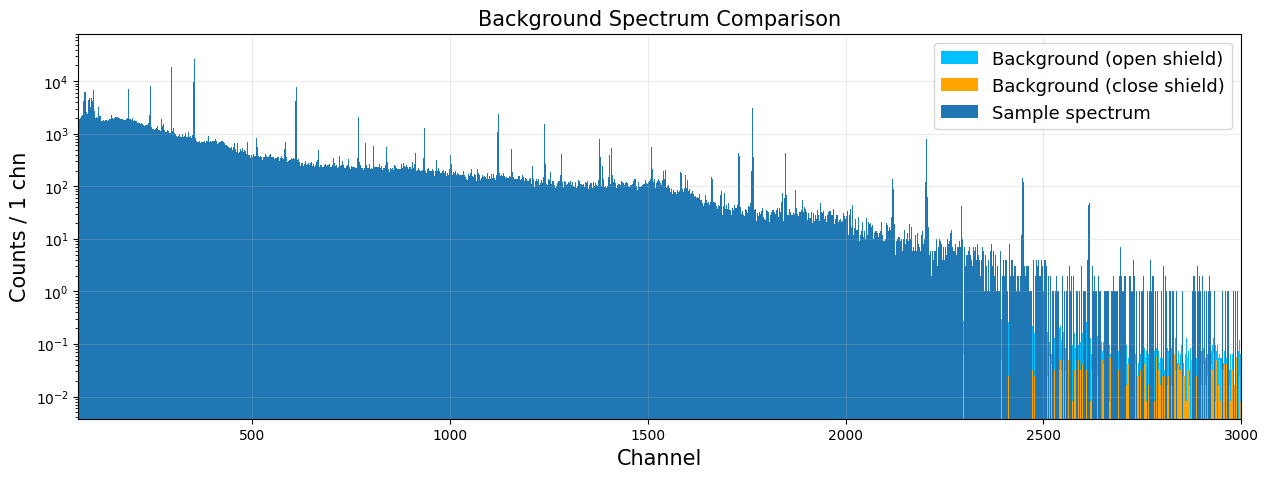

In [403]:
plt.figure(figsize=(15, 5))

# Prepara canali e bins
chn_open = np.arange(len(spectrum_open))
chn_U = np.arange(len(spectrum_U))
chn_bkg = np.arange(len(spectrum_bkg))

# Calcolo bins una volta sola
bins_open = np.linspace(min(energies_open), max(energies_open), int(len(energies_open)/2))
bins_U = np.linspace(min(energies), max(energies), int(len(energies)/2))
bins_bkg = np.linspace(min(energies_bkg), max(energies_bkg), int(len(energies_bkg)/2))

# Plot in ordine logico

plt.hist(energies_open, bins=bins_open, weights=spectrum_open, color='deepskyblue', label='Background (open shield)')
plt.hist(energies_bkg, bins=bins_bkg, weights=spectrum_bkg, color='orange', label='Background (close shield)')
plt.hist(energies, bins=bins_U, weights=spectrum_U, label='Sample spectrum')

# Impostazioni asse y
plt.yscale('log')
#plt.ylim(100, 8e5)

# Asse x
#plt.xticks(np.arange(0, max(len(spectrum_U), len(spectrum_open), len(spectrum_bkg)), 500), rotation=45)
plt.xlim(60,3000)

# Etichette e titolo
plt.xlabel('Channel', size=15)
plt.ylabel('Counts / 1 chn', size=15)  # db è sempre 1 con binning fatto così
plt.title('Background Spectrum Comparison', size=15)
plt.legend(loc='upper right', fontsize=13)
plt.grid(alpha=0.25)

# Salva figura
plt.savefig("HPGE open background/spettro_chn_op", dpi=300, bbox_inches='tight')


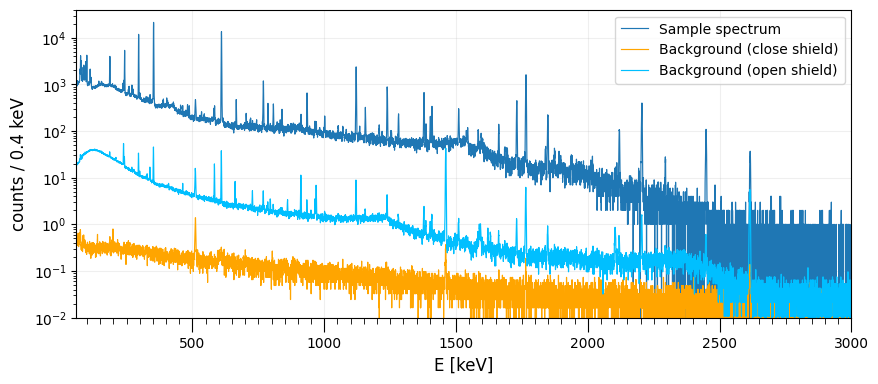

In [404]:
plt.figure(figsize = ( 10,4))
# Plot in ordine logico

plt.plot(energies,spectrum_U,lw = 0.85, label='Sample spectrum')
plt.plot(energies_bkg,spectrum_bkg, color='orange',lw = 0.85, label='Background (close shield)')

plt.plot(energies_open, spectrum_open, color='deepskyblue', lw = 0.85, label='Background (open shield)')

dx = 500
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=10, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

plt.ylim(0.01, 4e4)
plt.yscale('log')
plt.xlim(60, 3000)
plt.grid(alpha = 0.2)
plt.legend(loc = 'upper right', fontsize= 10)
plt.xlabel('E [keV]', size =12)
plt.ylabel('counts / 0.4 keV', size =12)
plt.savefig("new image/spectrum comparison", dpi=300, bbox_inches='tight')

In [405]:

print(f'attività grezza background closed {np.sum(spectrum_bkg)/(t_real_u):.0f} cps')
print(f'attività grezza background open {np.sum(spectrum_open)/(t_real_u):.0f} cps')
print(f'attività grezza source {np.sum(spectrum_U)/(t_real_u):.0f} cps')

attività grezza background closed 1 cps
attività grezza background open 38 cps
attività grezza source 2015 cps


In [406]:
100*(15869/48683)

32.59659429369595

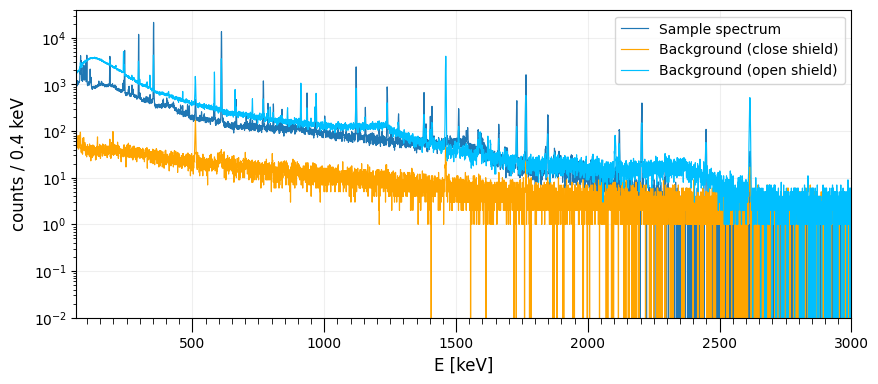

In [407]:
# Load the spectrum data
file_path = "BKG_only.csv"
data = pd.read_csv(file_path, header=None)
# Ensure data is 1D (each count per channel/bin)
spectrum_bkg = data[0].values



# Load the spectrum data
file_path = "HPGe/238U.csv"
data = pd.read_csv(file_path, header=None)
# Ensure data is 1D (each count per channel/bin)
spectrum_U = data[0].values



# Load the spectrum data
file_path = "Bckg_OPEN.csv"
data = pd.read_csv(file_path, header=None)
# Enure data is 1D (each count per channel/bin)
spectrum_open = data[0].values






plt.figure(figsize = ( 10,4))
# Plot in ordine logico

plt.plot(energies,spectrum_U,lw = 0.85, label='Sample spectrum')
plt.plot(energies_bkg,spectrum_bkg, color='orange',lw = 0.85, label='Background (close shield)')

plt.plot(energies_open, spectrum_open, color='deepskyblue', lw = 0.85, label='Background (open shield)')

dx = 500
dy = 50
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(dx))   # Tacche principali con etichetta
ax.xaxis.set_minor_locator(MultipleLocator(dy))   # Tacche secondarie senza etichetta
ax.tick_params(axis='x', which='major', length=10, labelsize=10)  # numeri grandi
ax.tick_params(axis='x', which='minor', length=4, labelsize=0)   # tacche piccole, no numero

plt.ylim(0.01, 4e4)
plt.yscale('log')
plt.xlim(60, 3000)
plt.grid(alpha = 0.2)
plt.legend(loc = 'upper right', fontsize= 10)
plt.xlabel('E [keV]', size =12)
plt.ylabel('counts / 0.4 keV', size =12)
plt.savefig("new image/spectrum comparison", dpi=300, bbox_inches='tight')